### UTILIZING MULTIPLE COUNTRIES DATA AS ADDITIONAL REGRESSOR TO PREDICT UPCOMING CASES

Consider for country 1 the we started seeing the confirmed cases much earlier then country 2. We can utilize the state 1 data as additional regressor to predict upcoming cases in state 2.

In [14]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 

### Data Pre-Processing

In [2]:
data =pd.read_csv("time_series_covid19_confirmed_global.csv")
data =data.drop(["Province/State","Lat","Long"],1).groupby('Country/Region').sum()
data = data[data.iloc[:,-1] > 300]
all_data = data.T
all_data.head(5)


Country/Region  Afghanistan  Albania  Algeria  Andorra  Argentina  Armenia  \
1/22/2020                 0        0        0        0          0        0   
1/23/2020                 0        0        0        0          0        0   
1/24/2020                 0        0        0        0          0        0   
1/25/2020                 0        0        0        0          0        0   
1/26/2020                 0        0        0        0          0        0   

Country/Region  Australia  Austria  Azerbaijan  Bahrain  ...  Tunisia  Turkey  \
1/22/2020               0        0           0        0  ...        0       0   
1/23/2020               0        0           0        0  ...        0       0   
1/24/2020               0        0           0        0  ...        0       0   
1/25/2020               0        0           0        0  ...        0       0   
1/26/2020               4        0           0        0  ...        0       0   

Country/Region  US  Ukraine  United Arab Emirates  United Kingdom  Uruguay  \
1/22/2020        1        0                     0               0        0   
1/23/2020        1        0                     0               0        0   
1/24/2020        2        0                     0               0        0   
1/25/2020        2        0                     0               0        0   
1/26/2020        5        0                     0               0        0   

Country/Region  Uzbekistan  Venezuela  West Bank and Gaza  
1/22/2020                0          0                   0  
1/23/2020                0          0                   0  
1/24/2020                0          0                   0  
1/25/2020                0          0                   0  
1/26/2020                0          0                   0  

[5 rows x 120 columns]

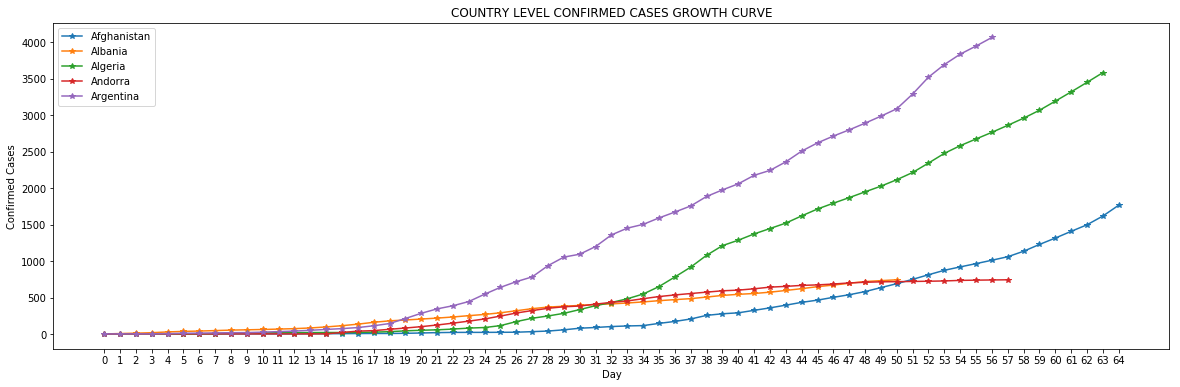

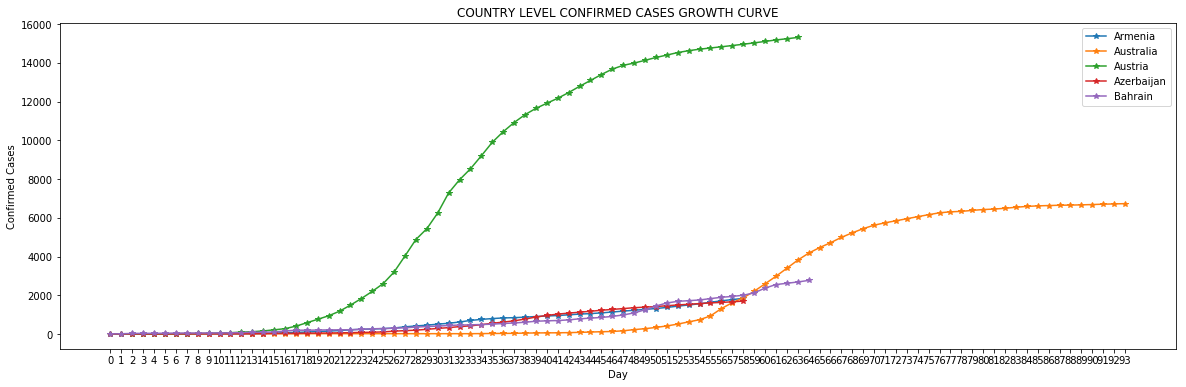

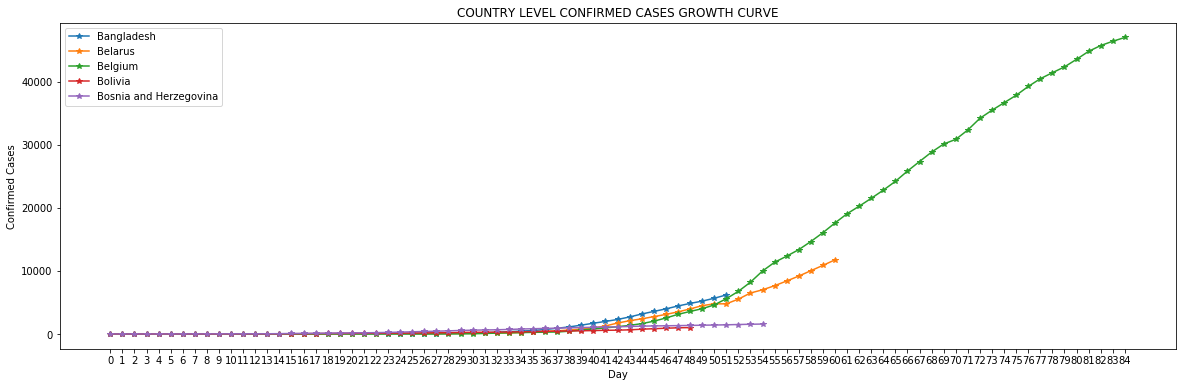

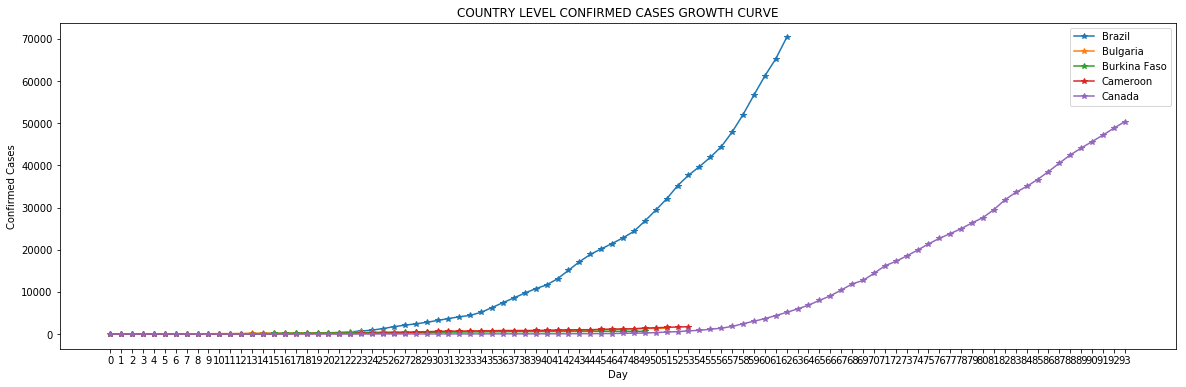

In [3]:
for j in range(1,5):   
    plt.figure(figsize=(20,6))
    for tt in all_data.columns[(j-1)*5:j*5]:
        data = all_data[[tt]]
        data = data[data[tt]> 0].reset_index(drop=True)
        data = data.rolling(2).mean().fillna(0)
        plt.plot([str(i) for i in data[tt].index],data[tt],marker='*',label=tt)
        
    plt.title("COUNTRY LEVEL CONFIRMED CASES GROWTH CURVE")
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('Confirmed Cases')
    plt.show()

### Testing the correlation coefficient between growth curves and plotting the curves which have more than 90% correlation and less than 100 MSE

Here I have tried to find the correlation and mean square distance between the curves and then selecting the curves which have highest correlation more than 90% and MSE less than 100. This gives information within US states how the cases are increasing with time. With this approach we can utilize the growth rate available form past experience to forecast future risk.

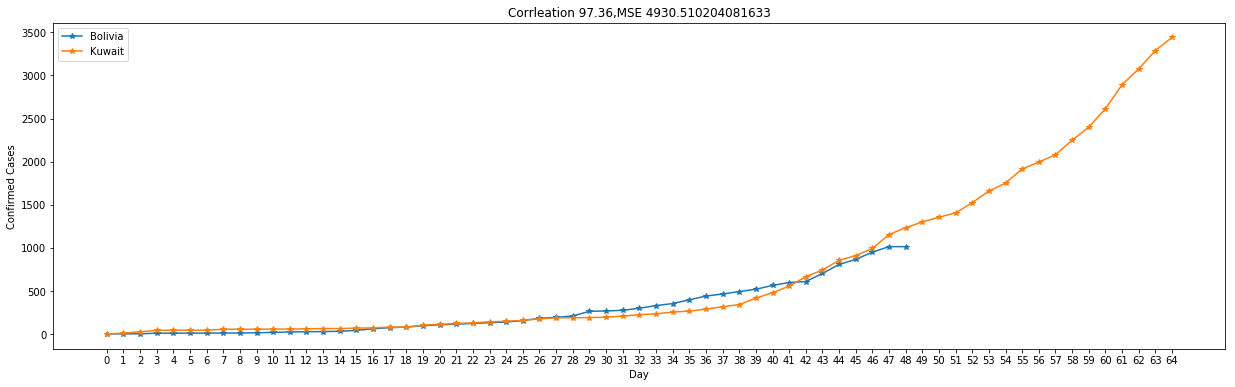

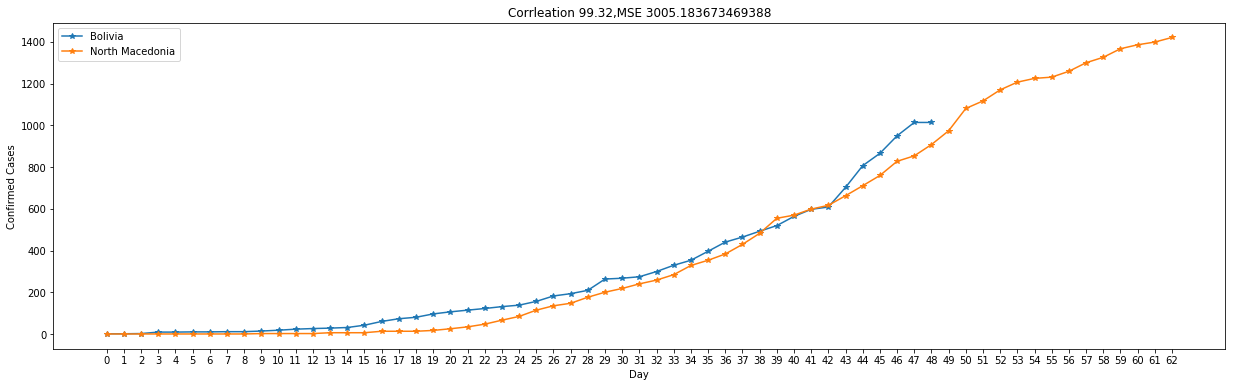

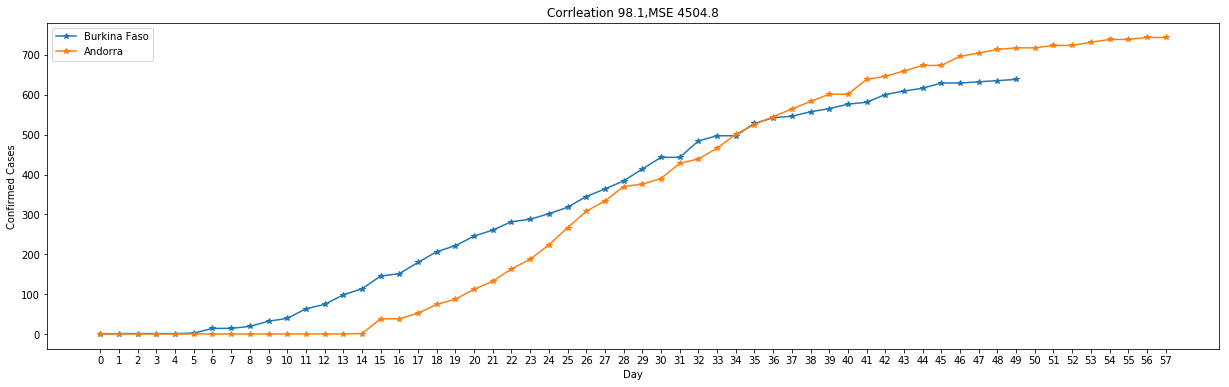

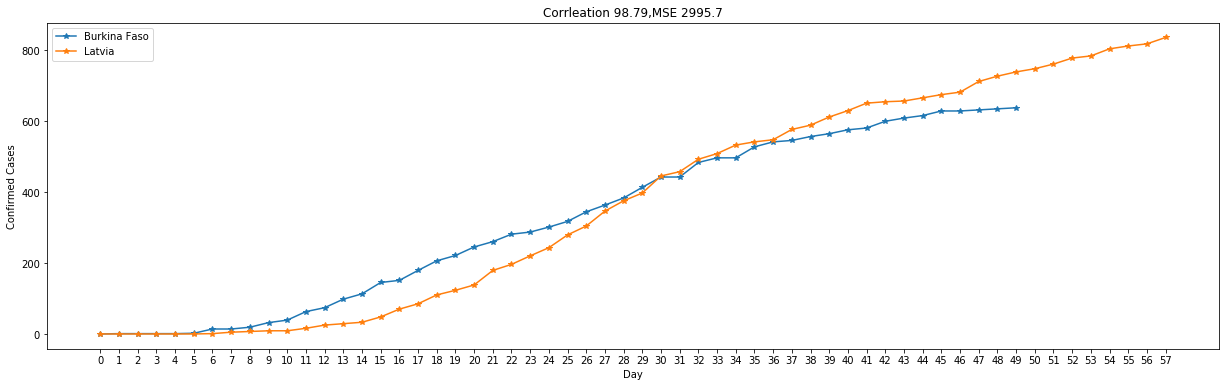

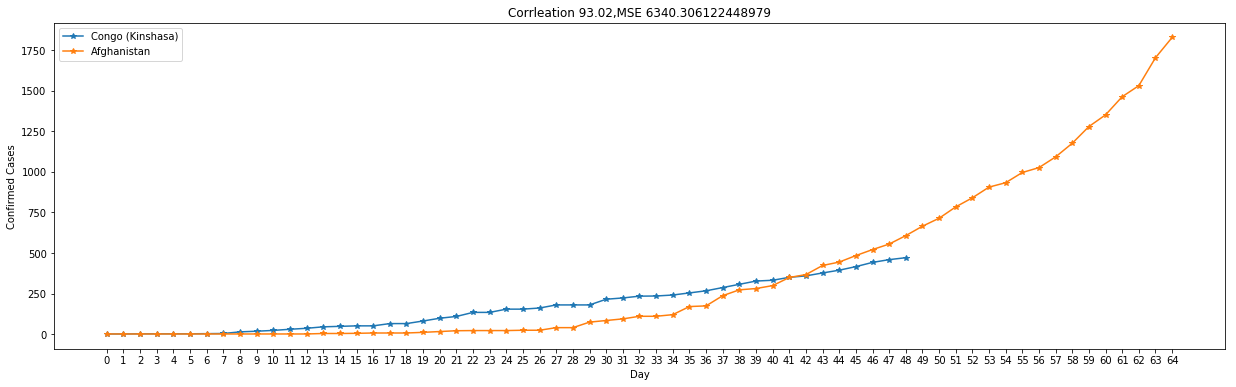

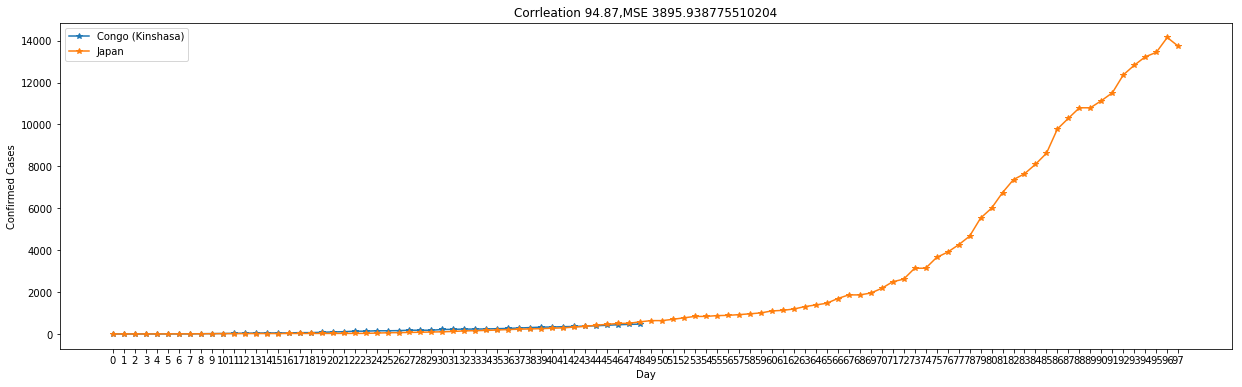

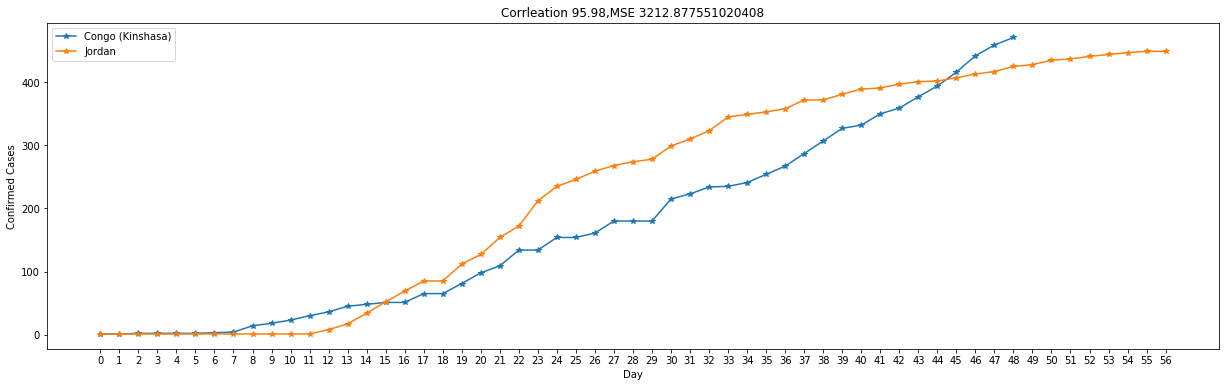

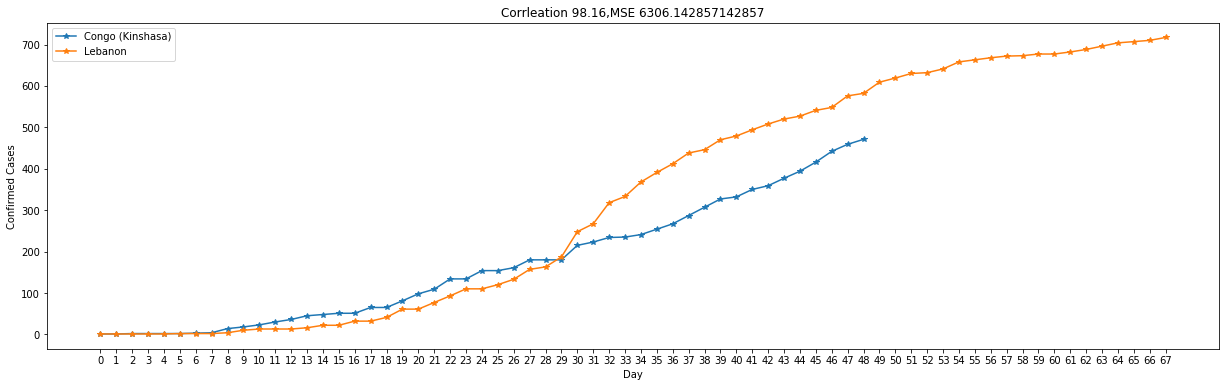

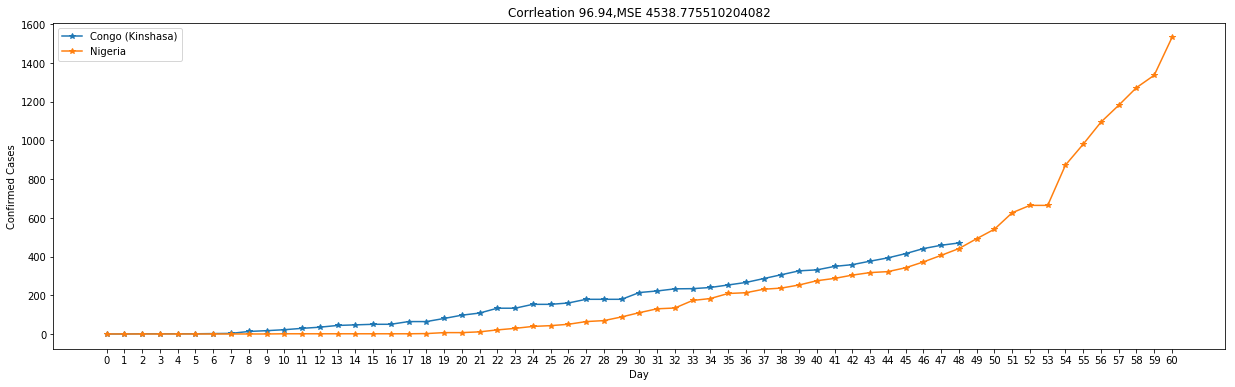

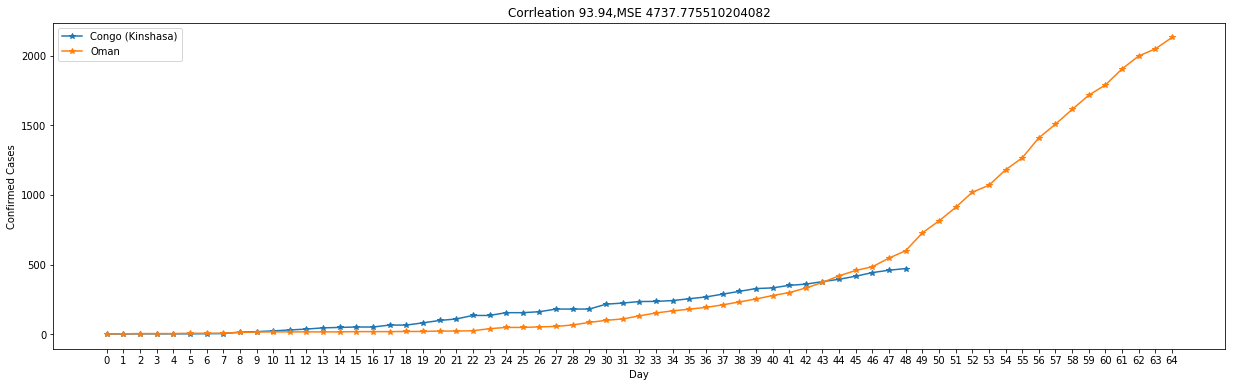

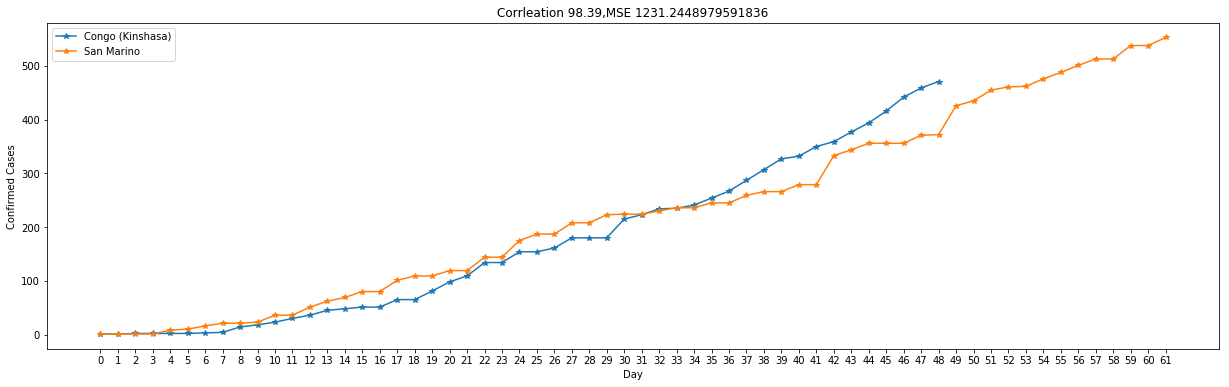

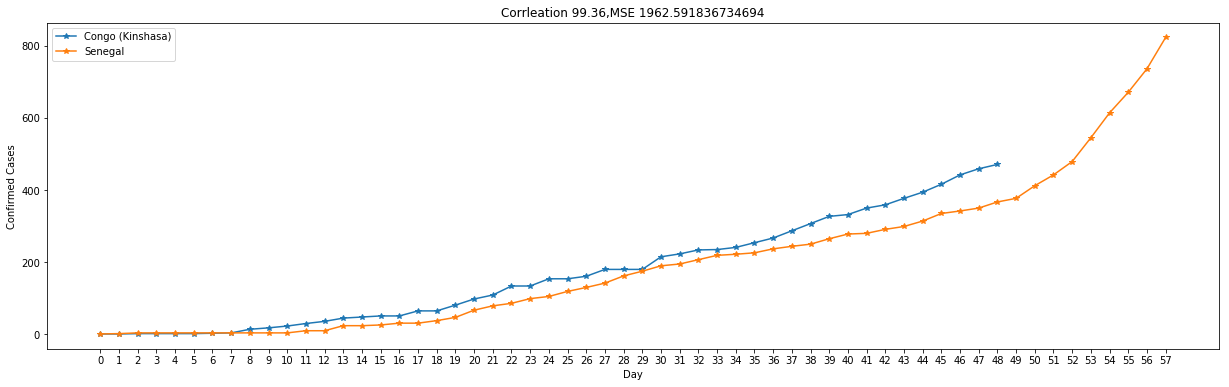

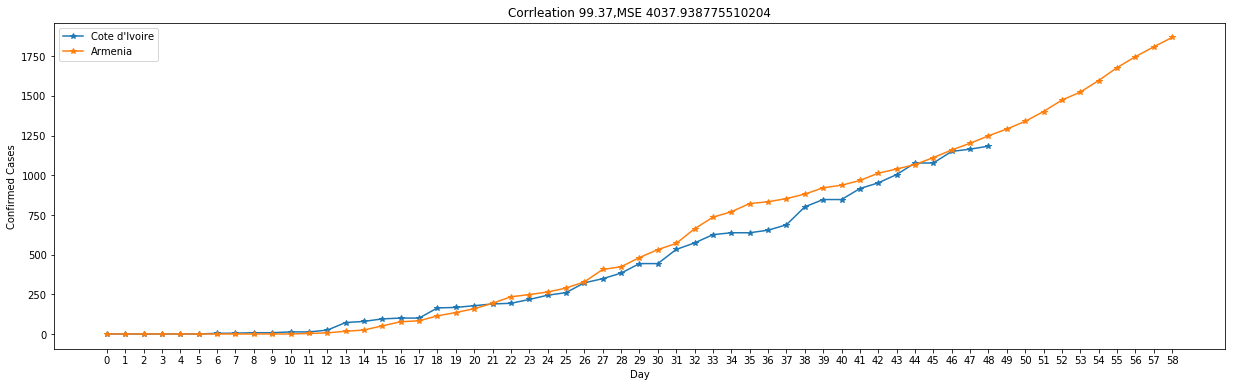

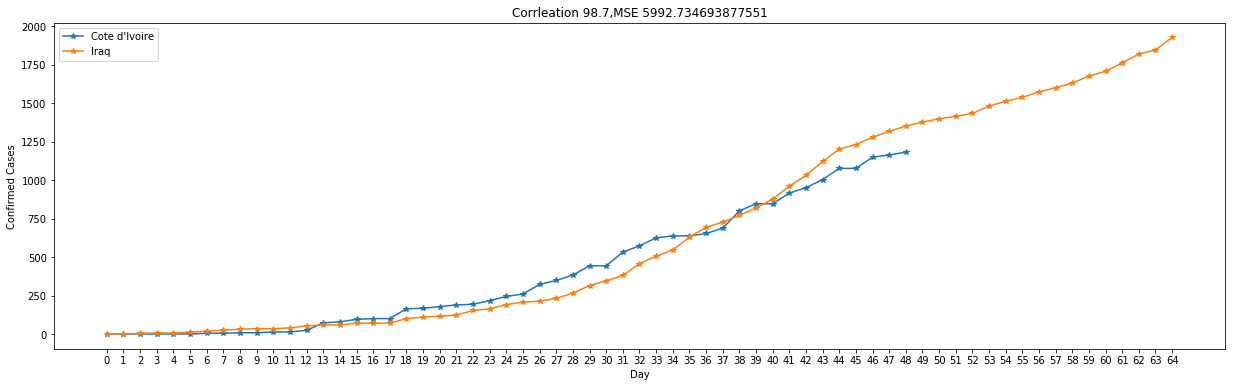

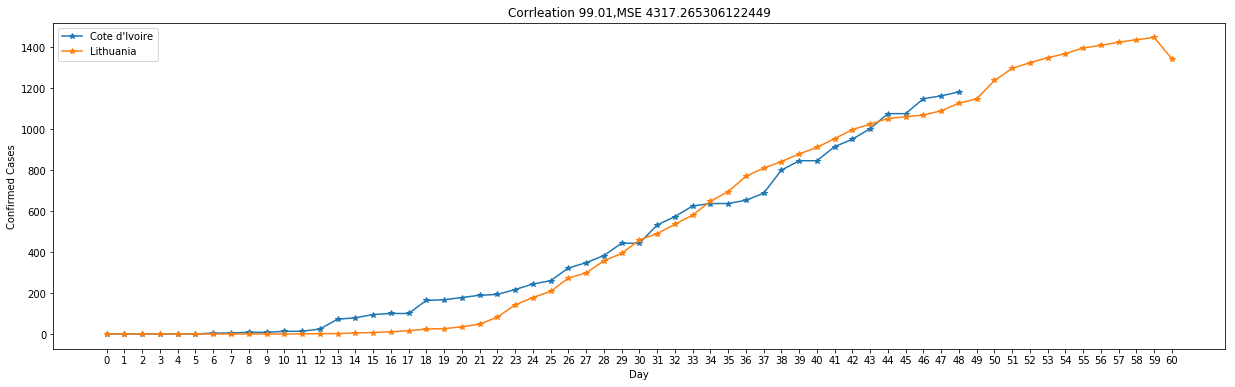

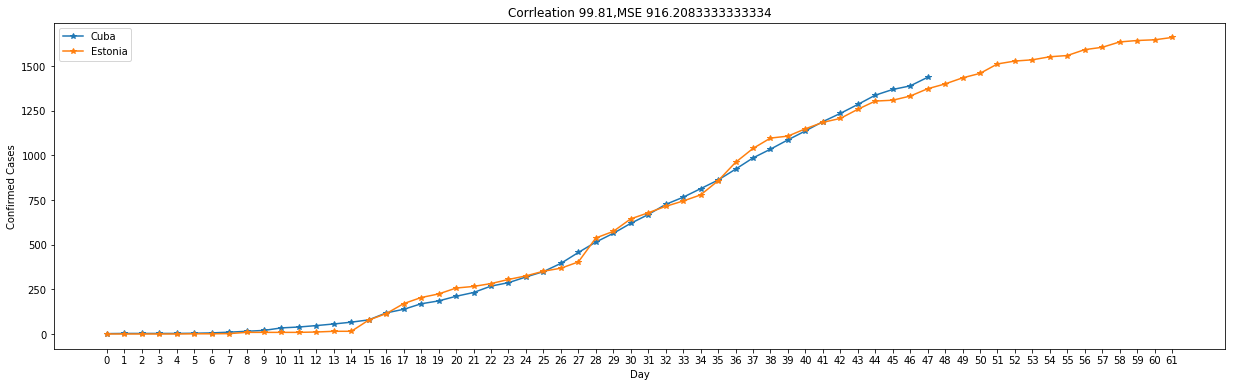

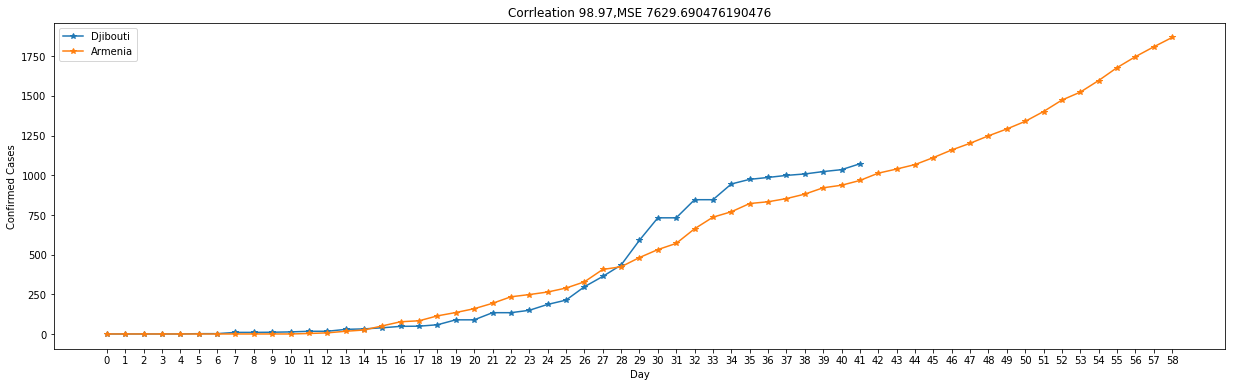

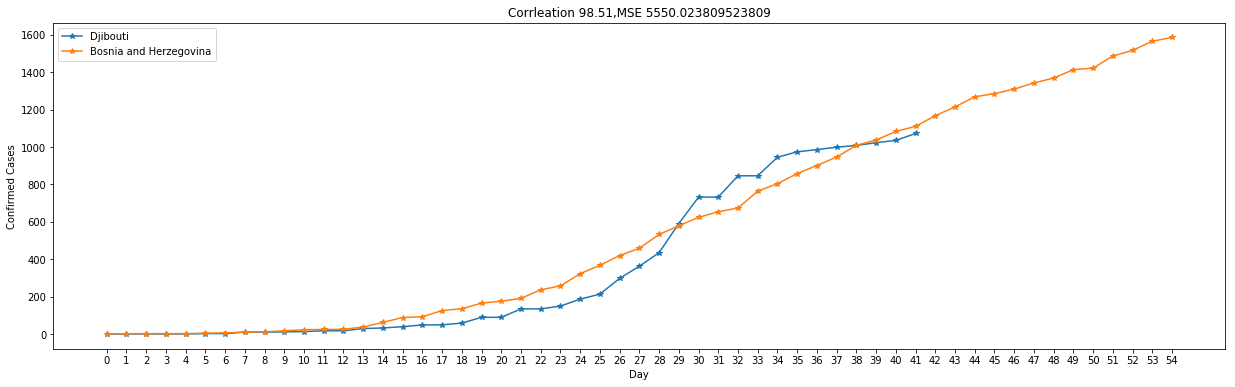

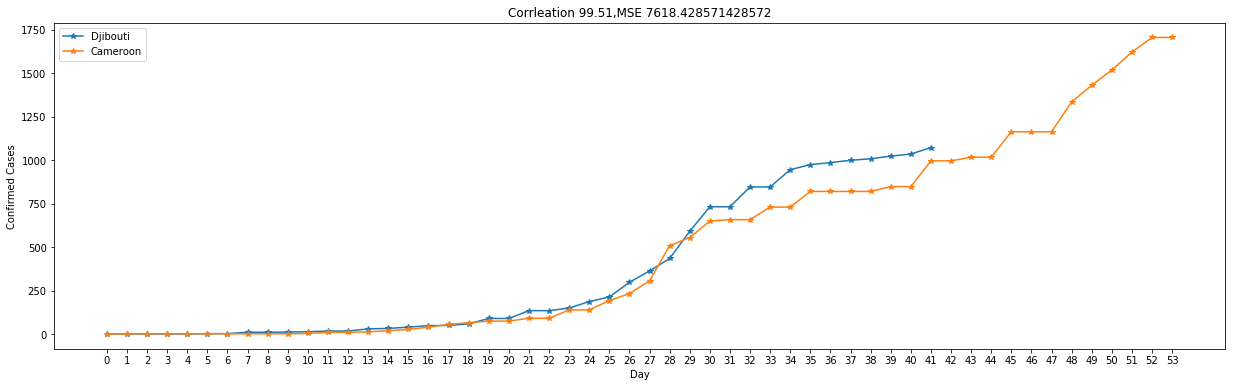

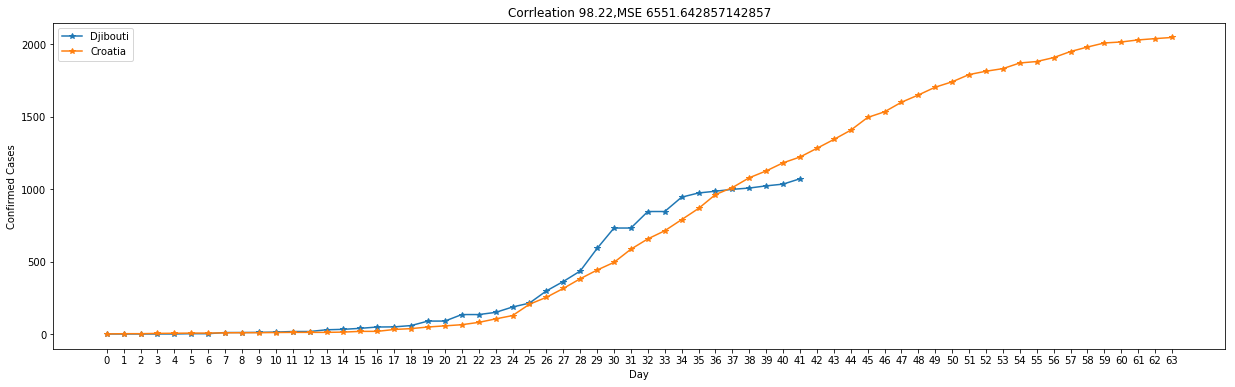

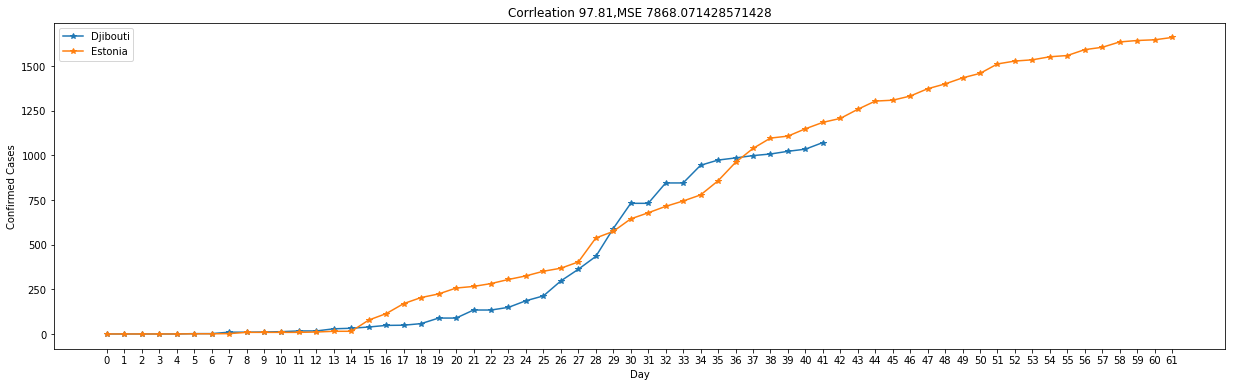

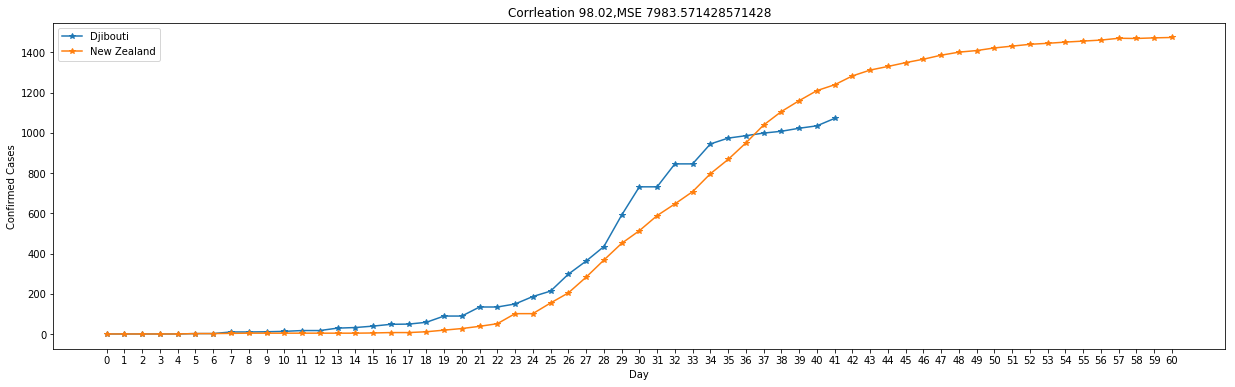

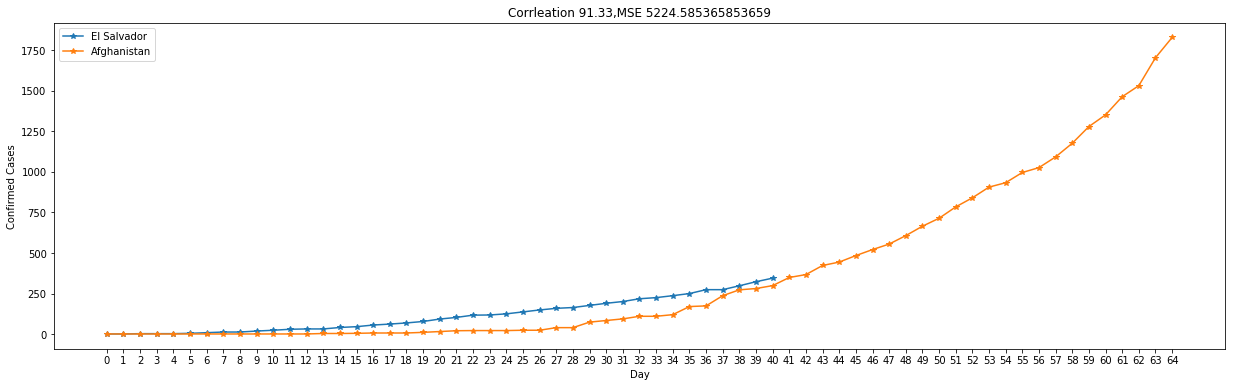

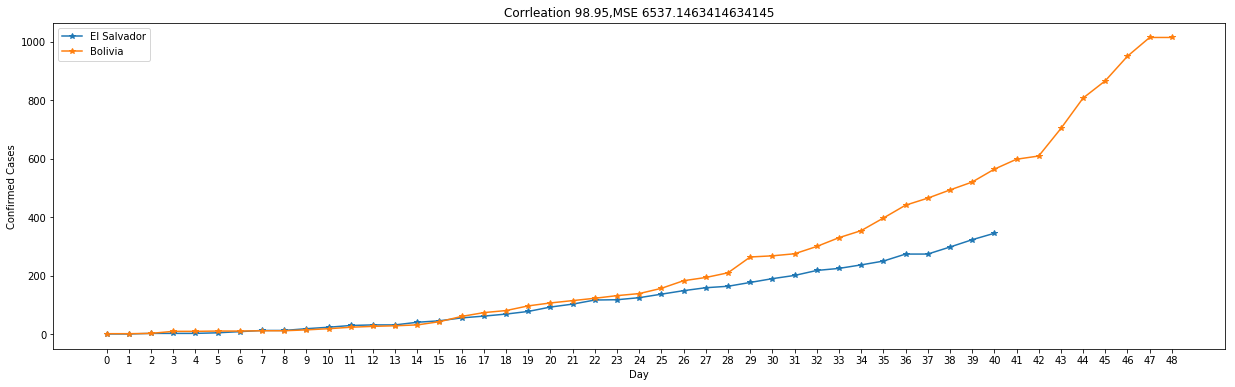

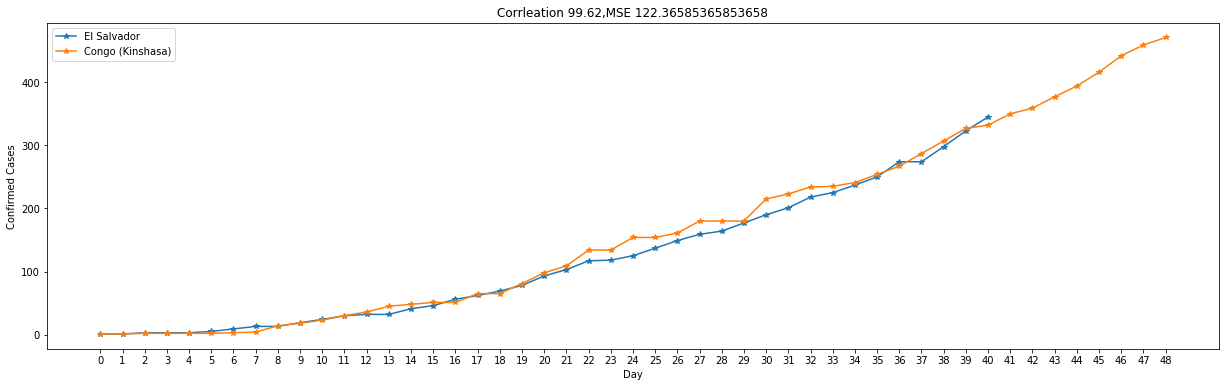

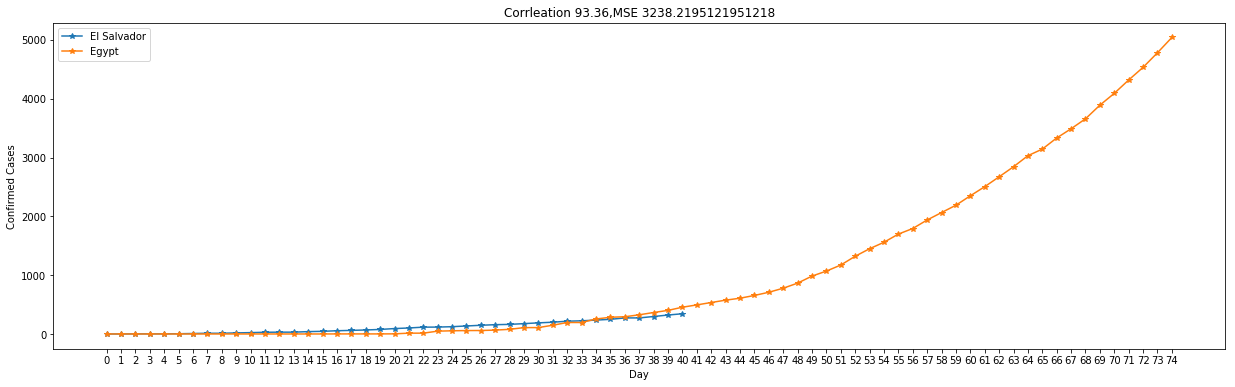

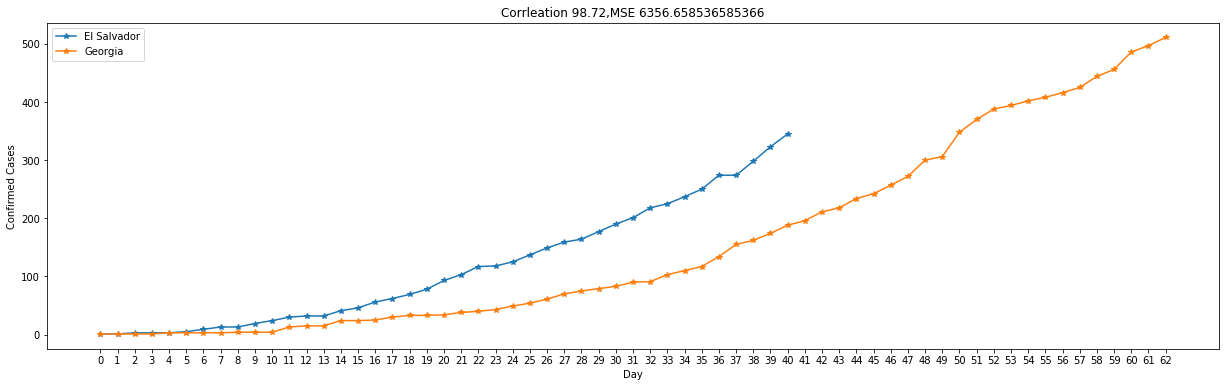

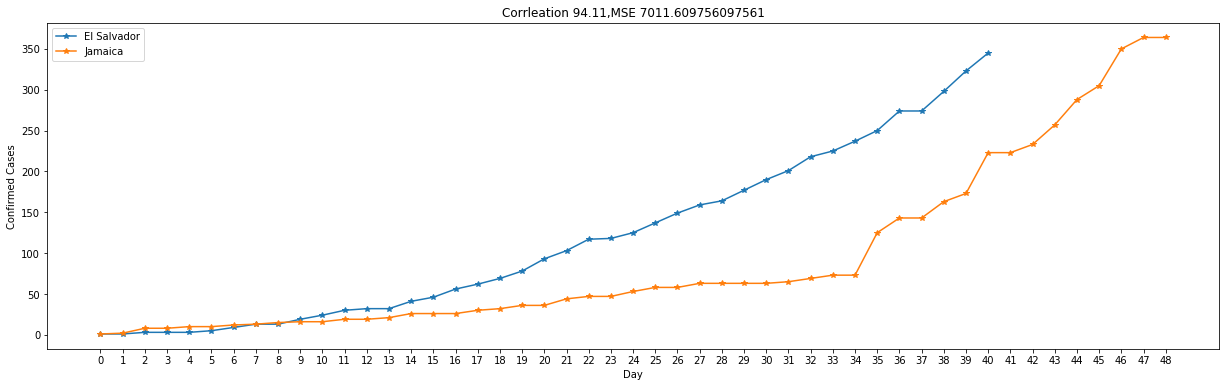

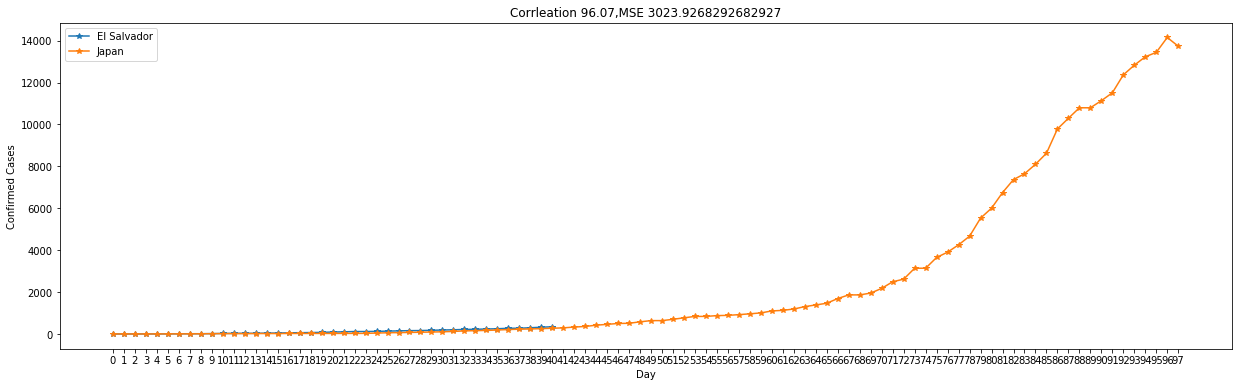

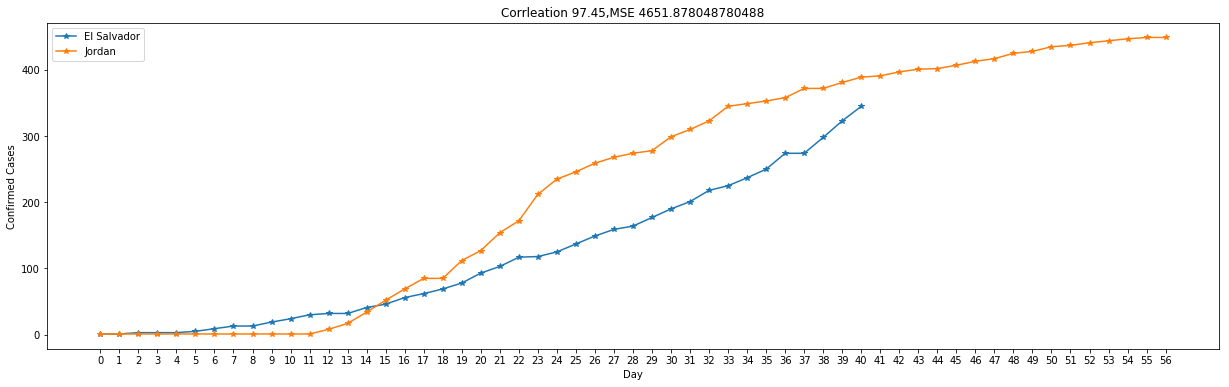

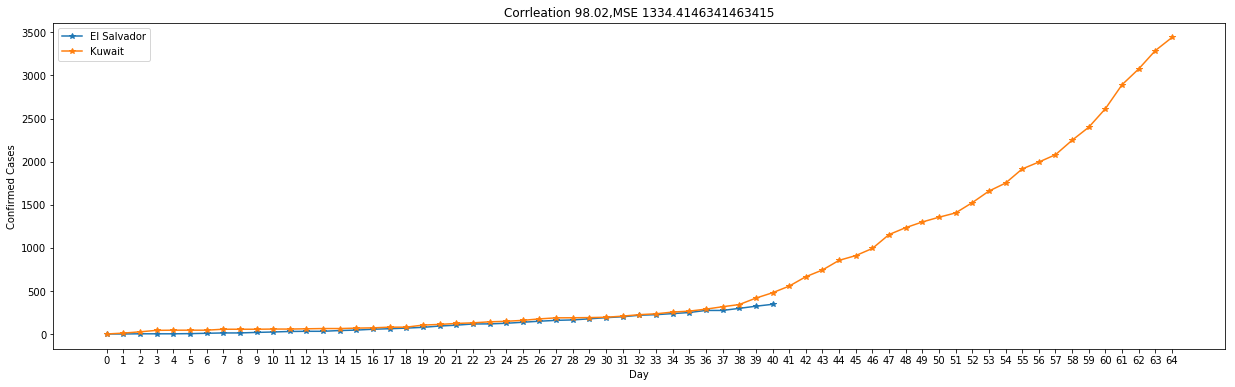

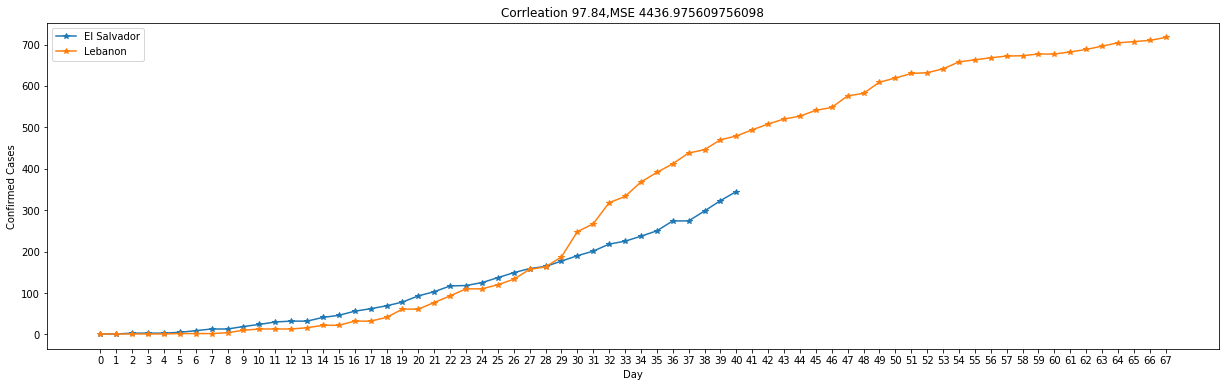

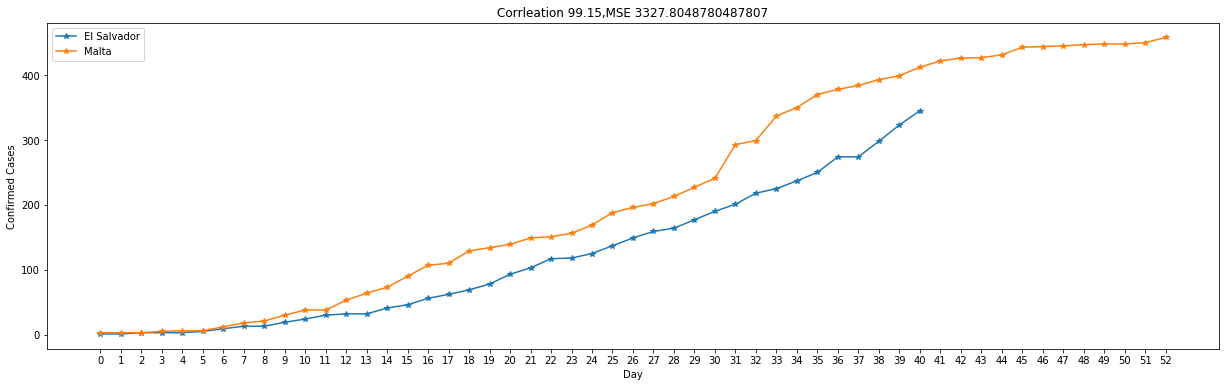

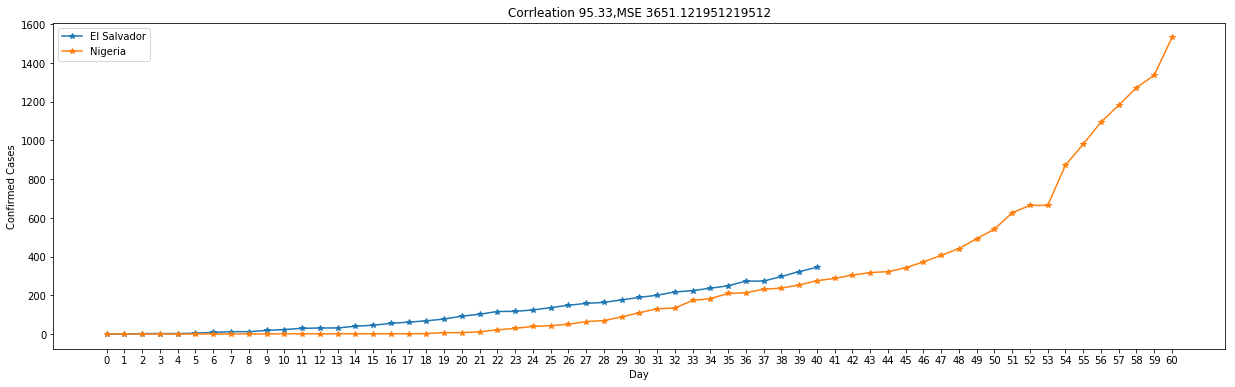

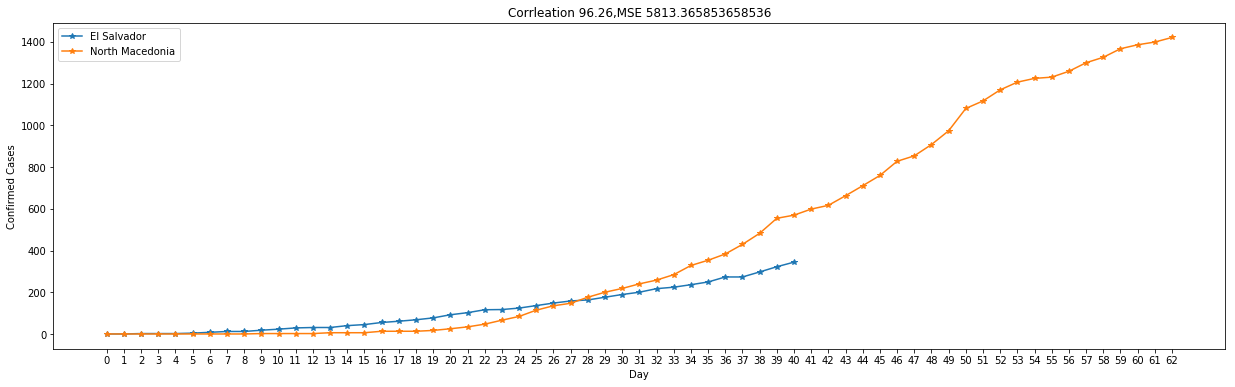

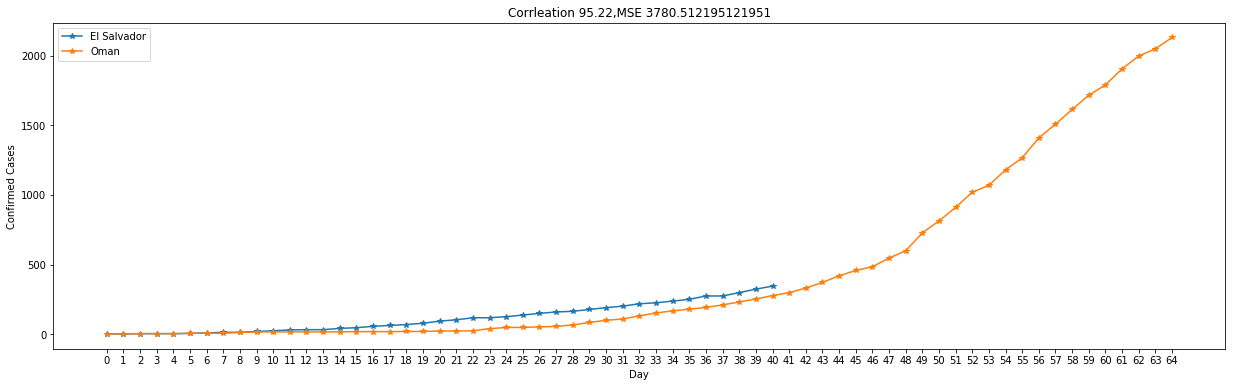

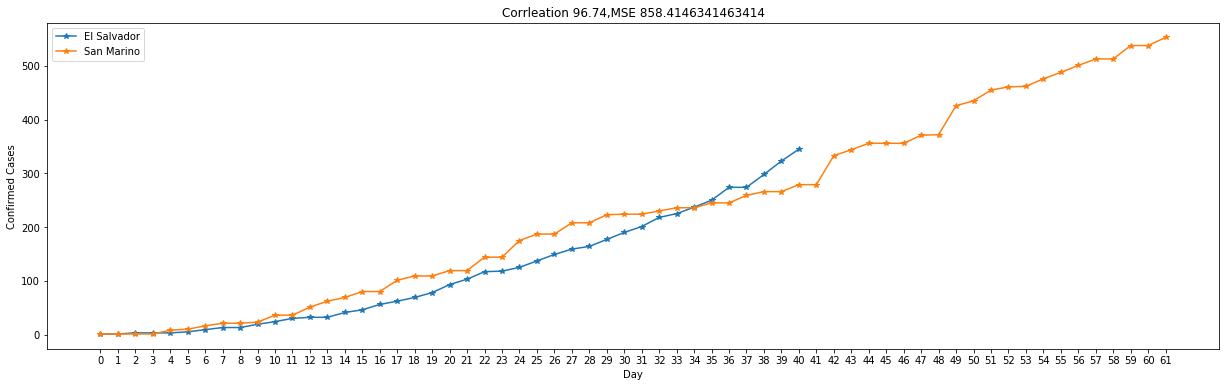

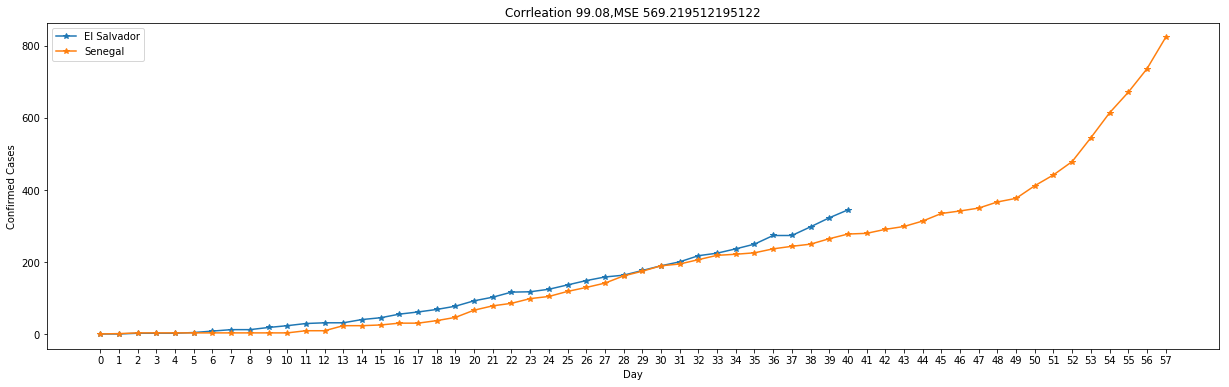

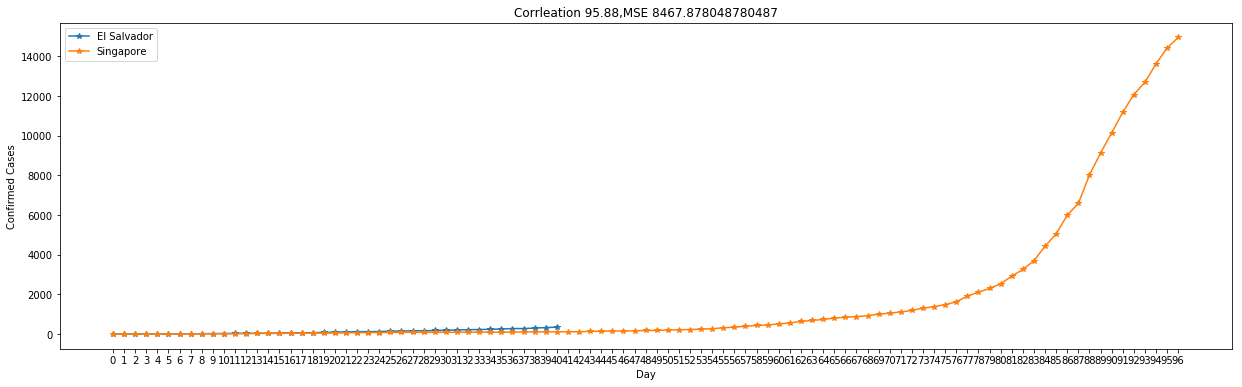

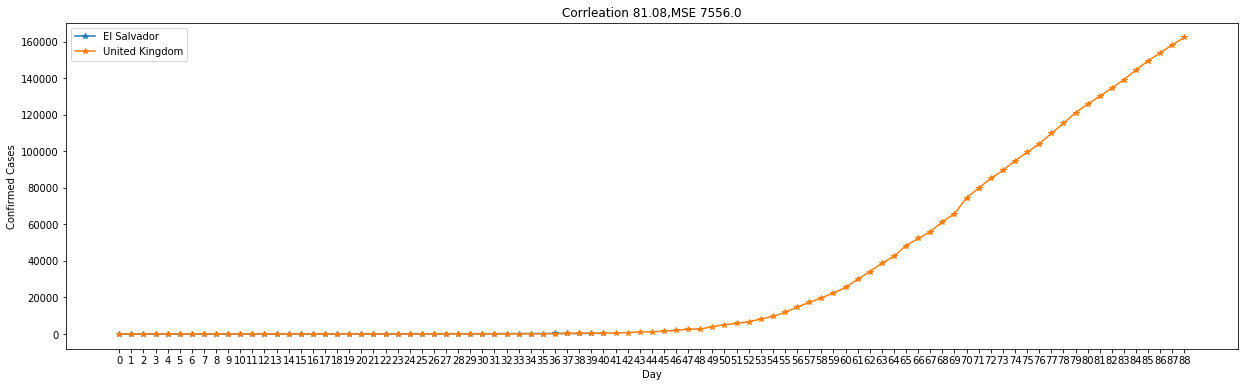

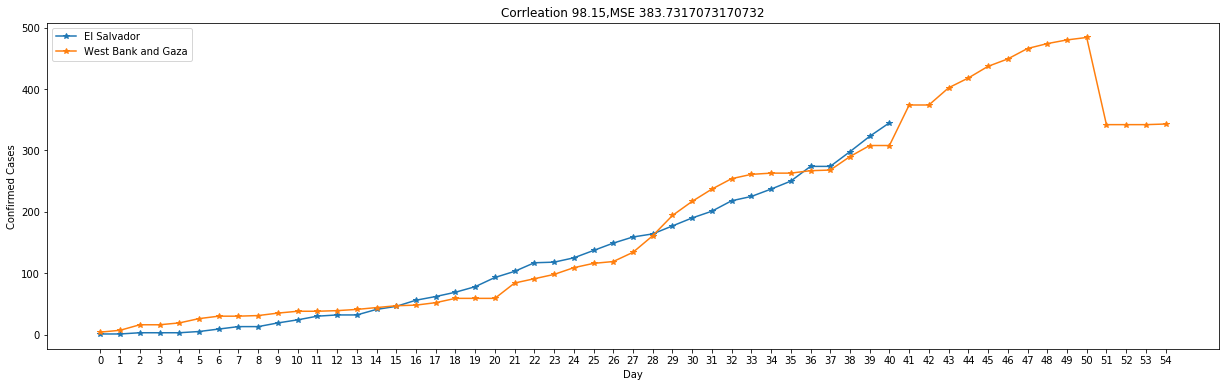

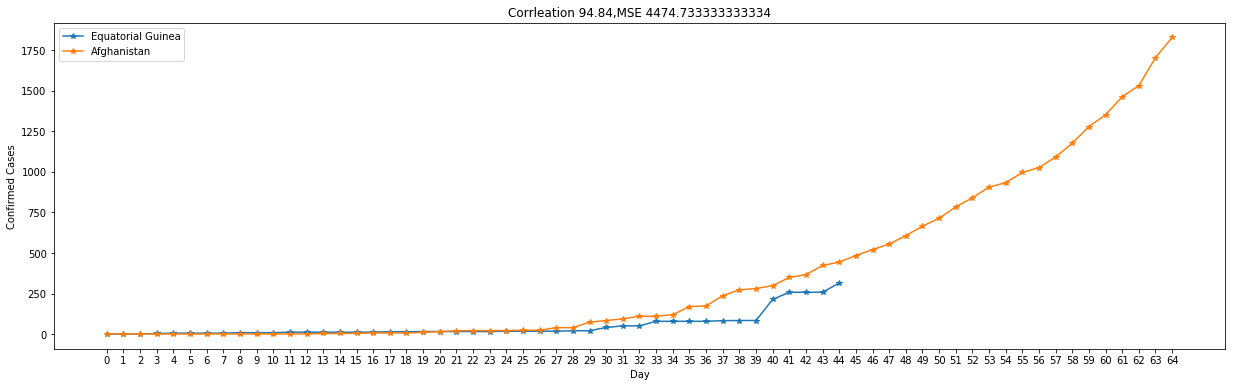

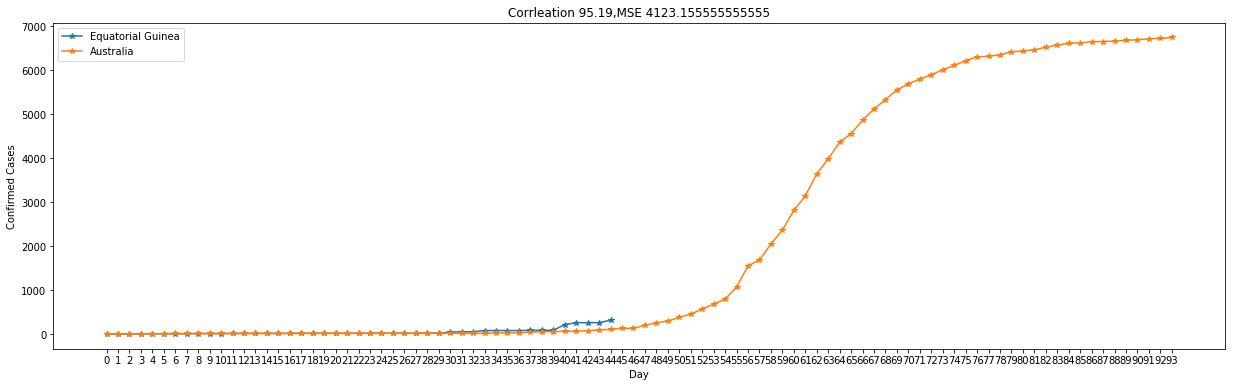

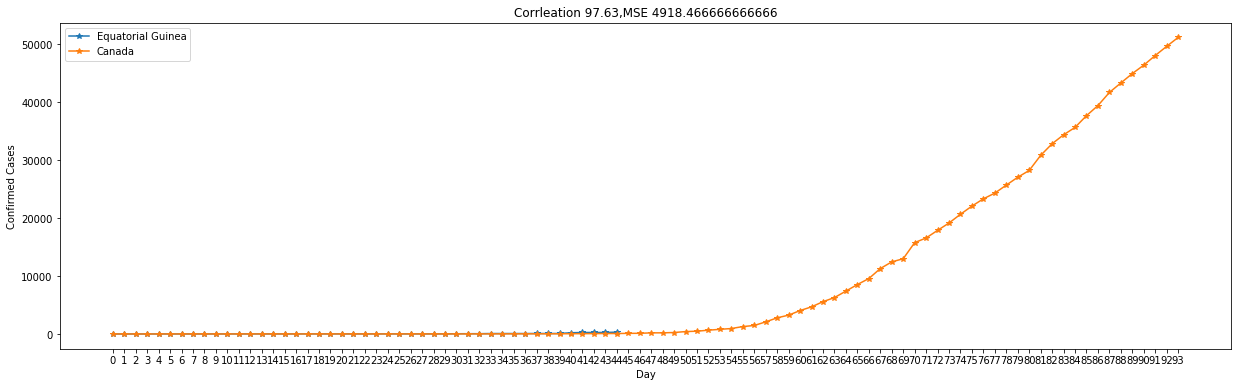

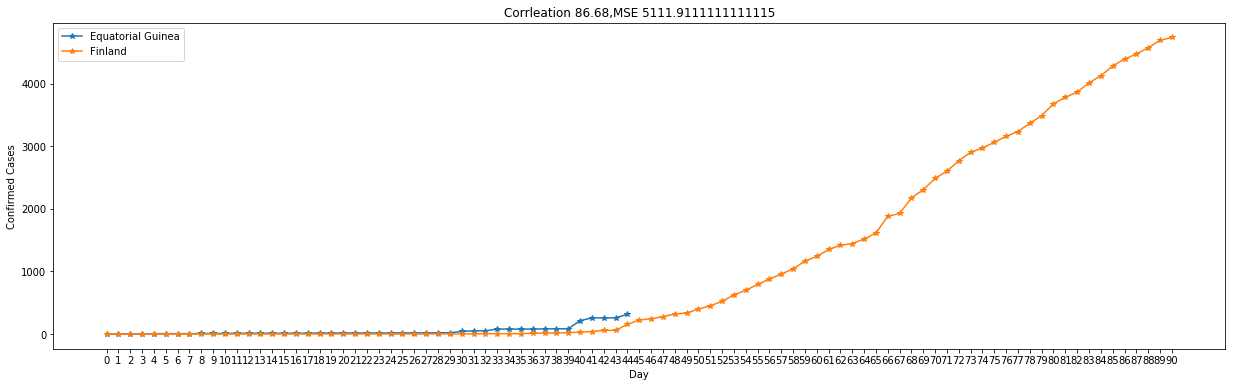

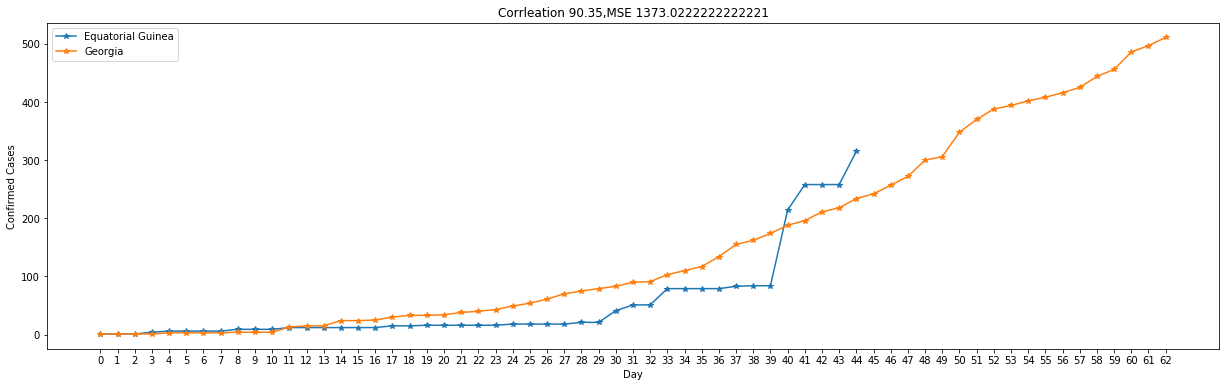

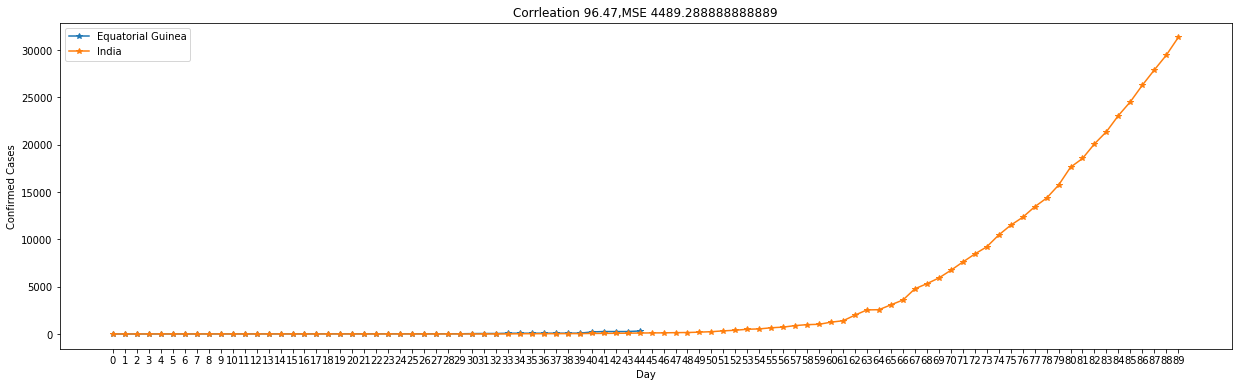

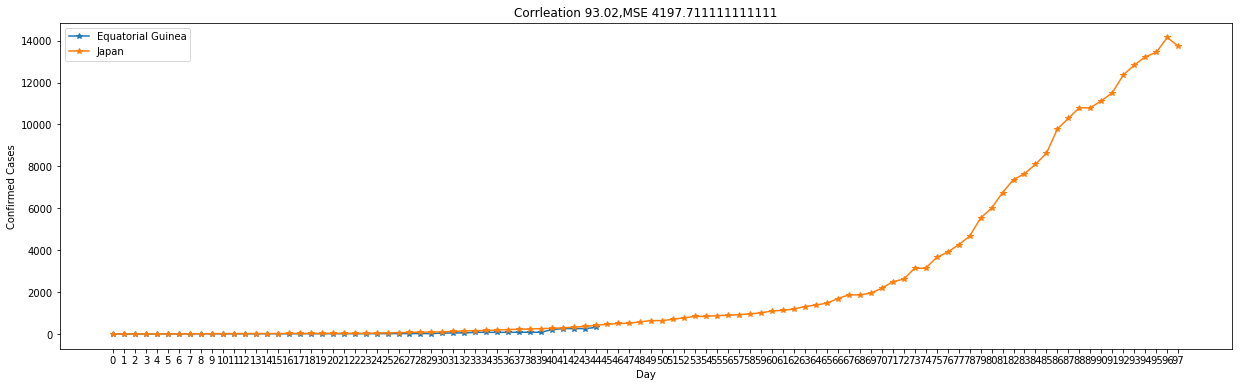

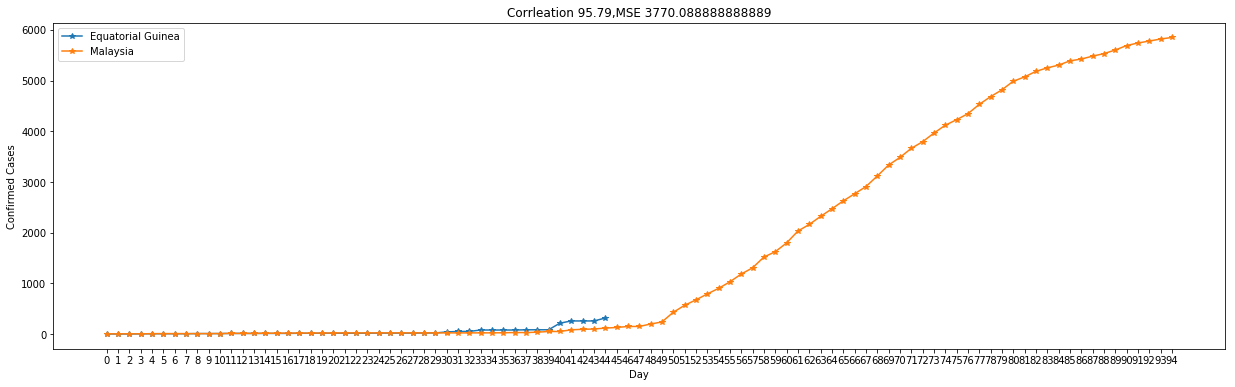

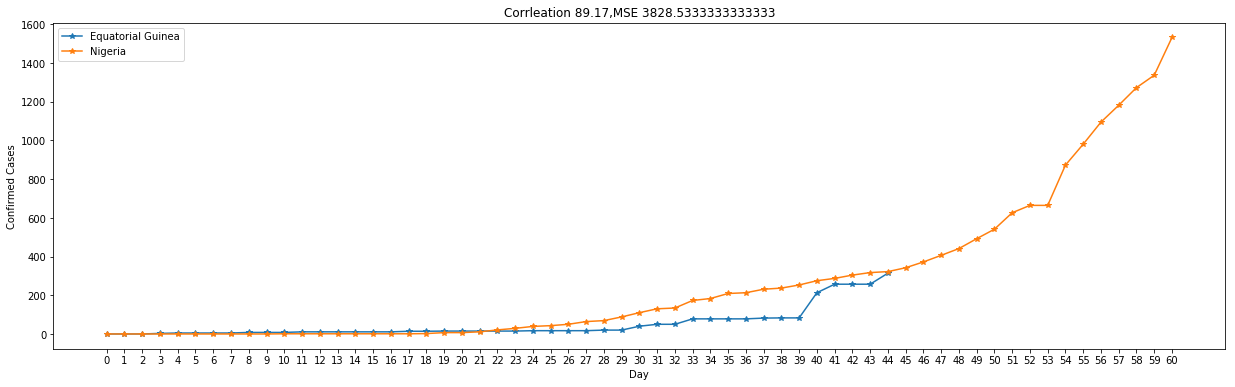

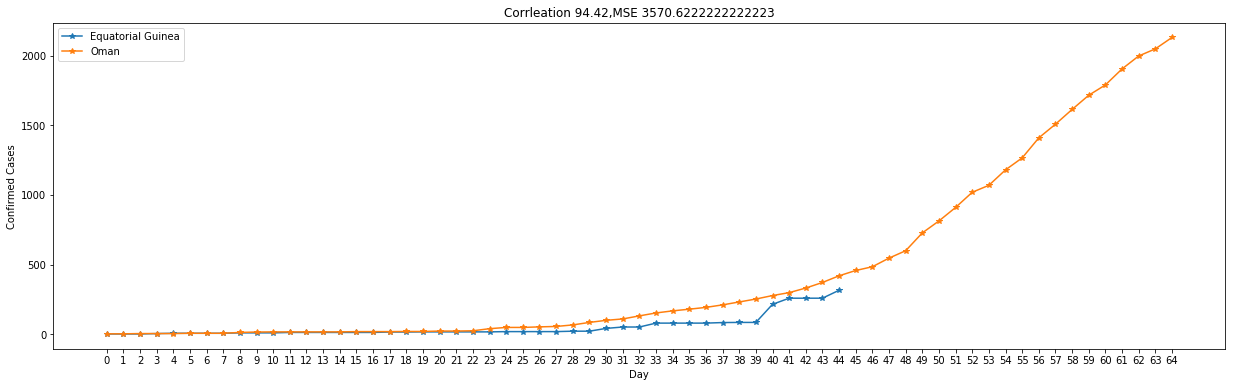

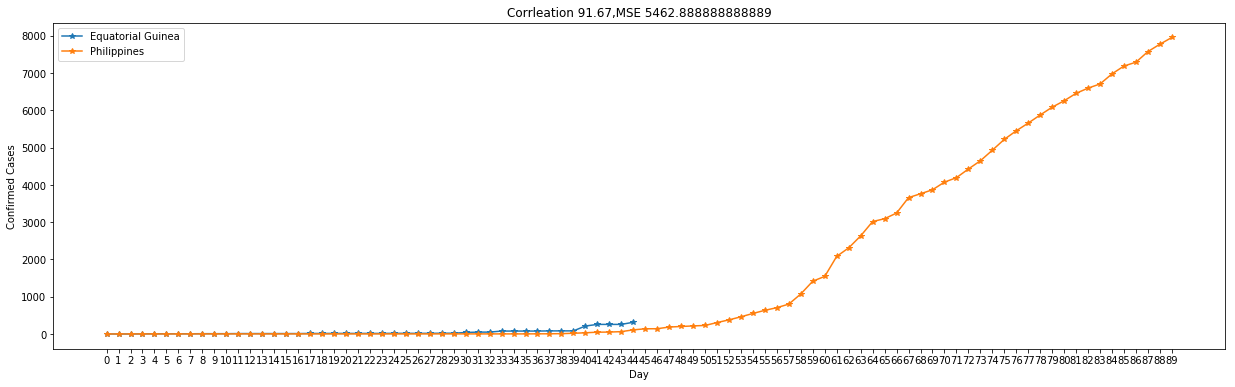

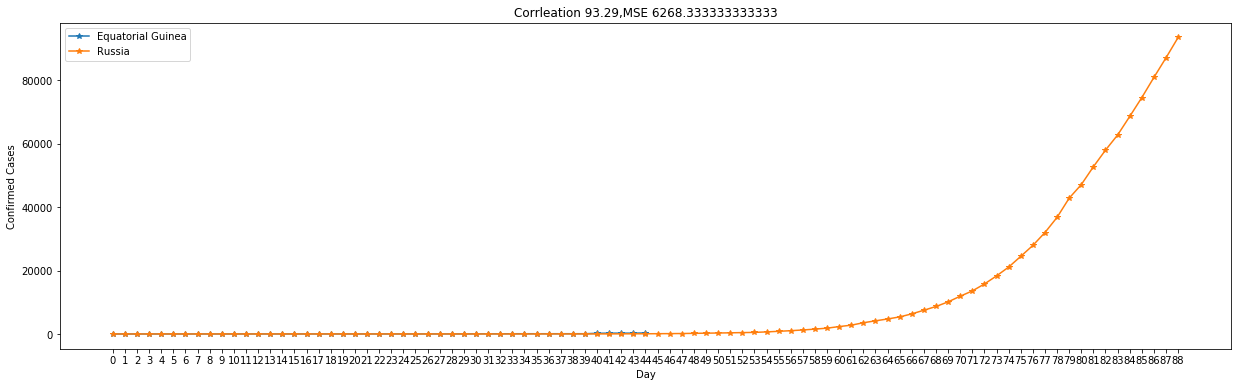

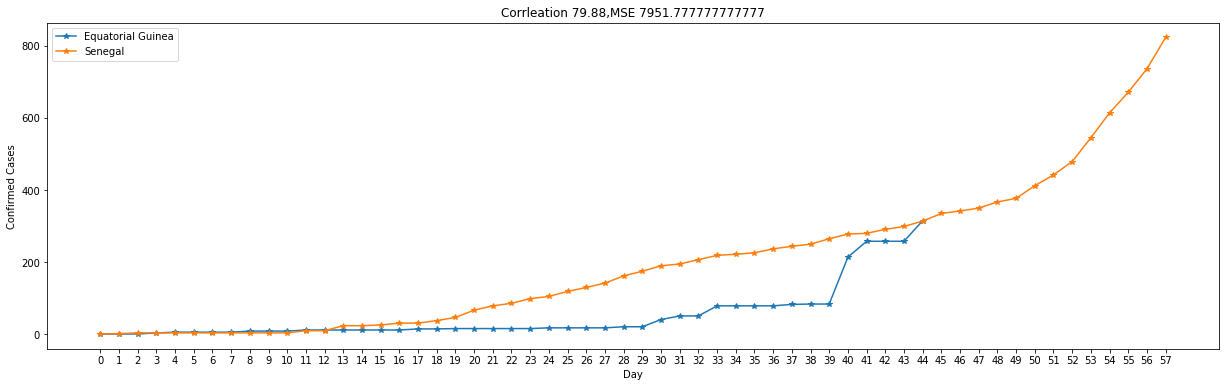

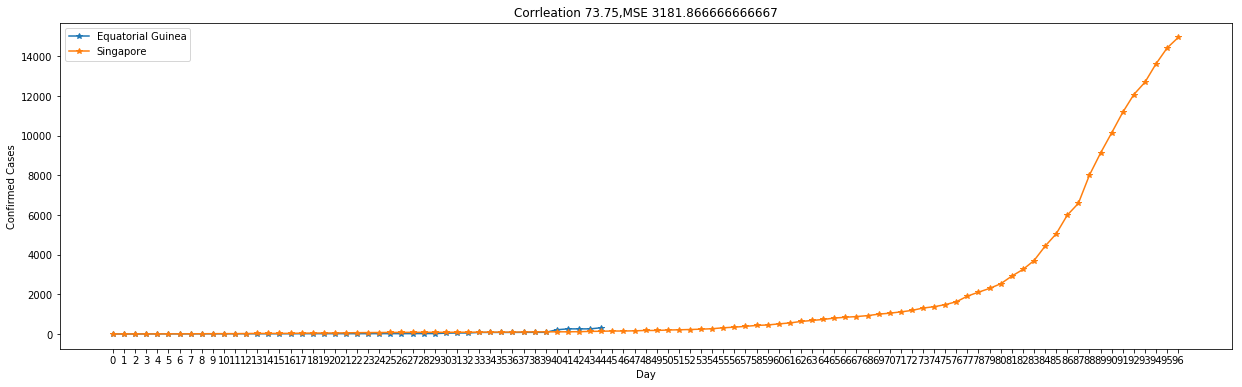

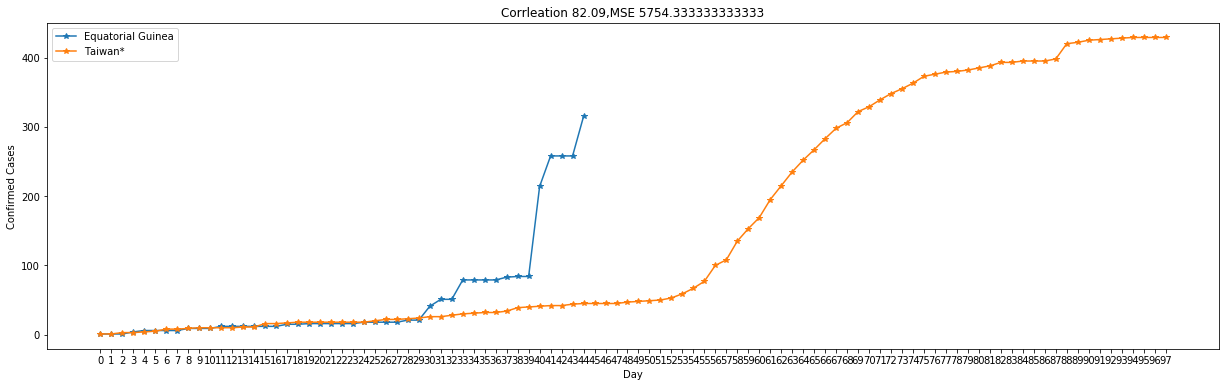

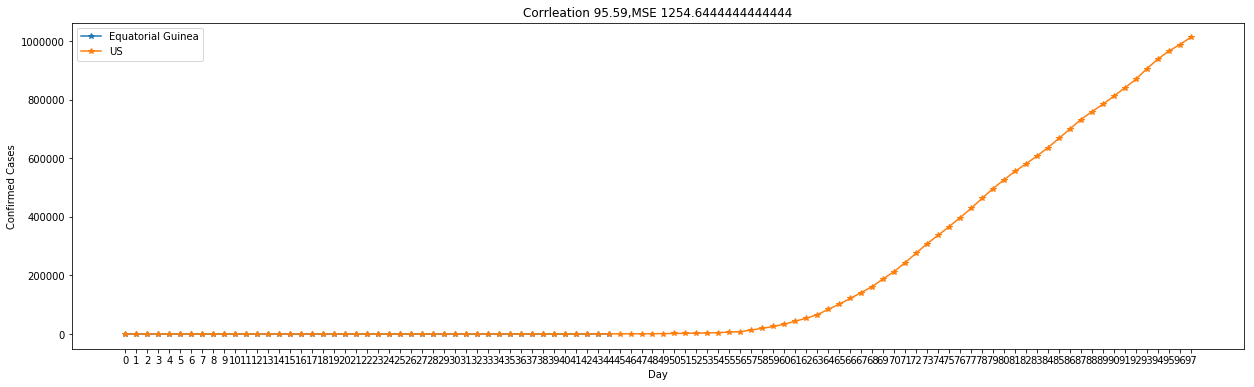

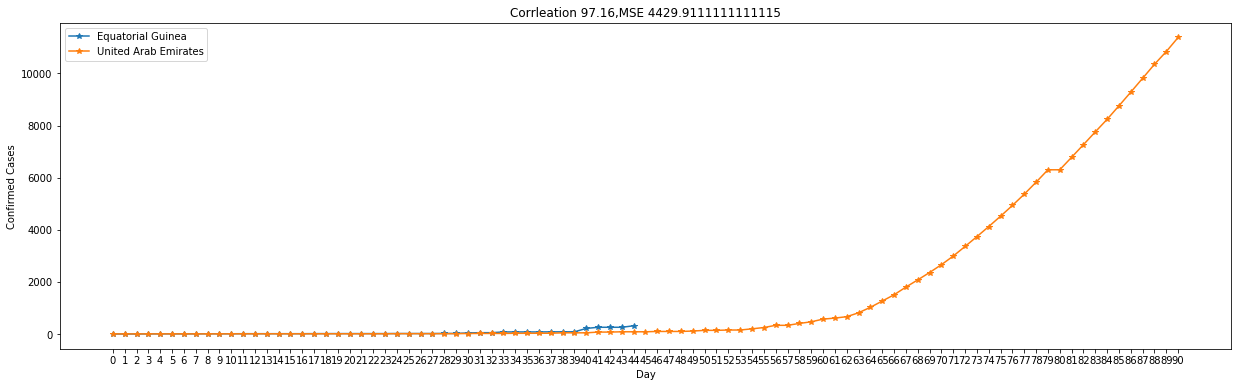

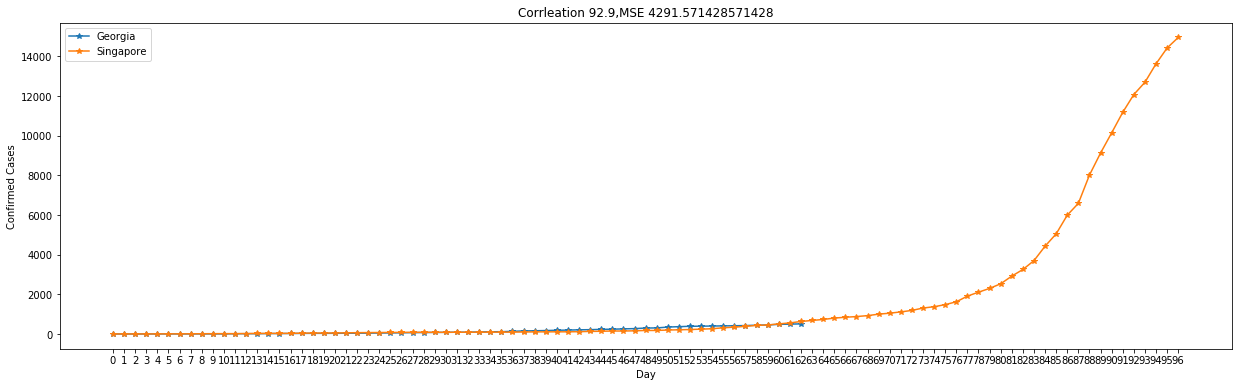

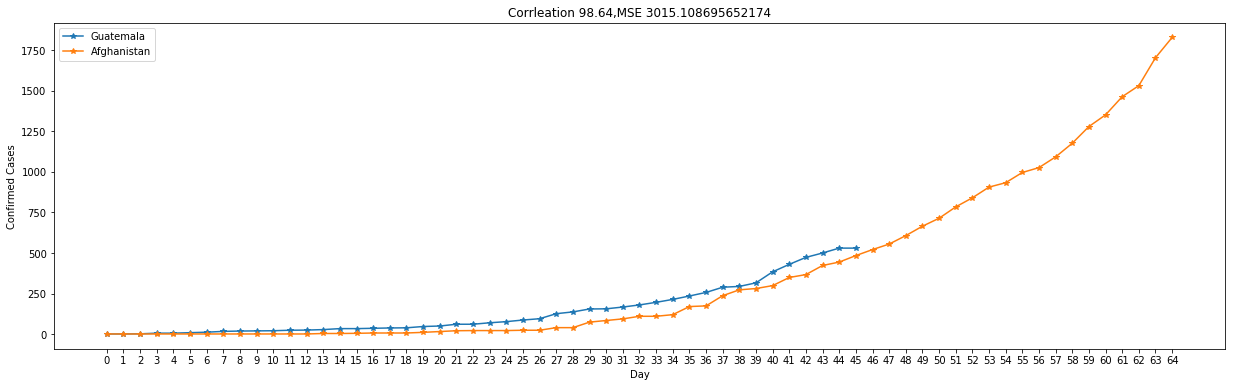

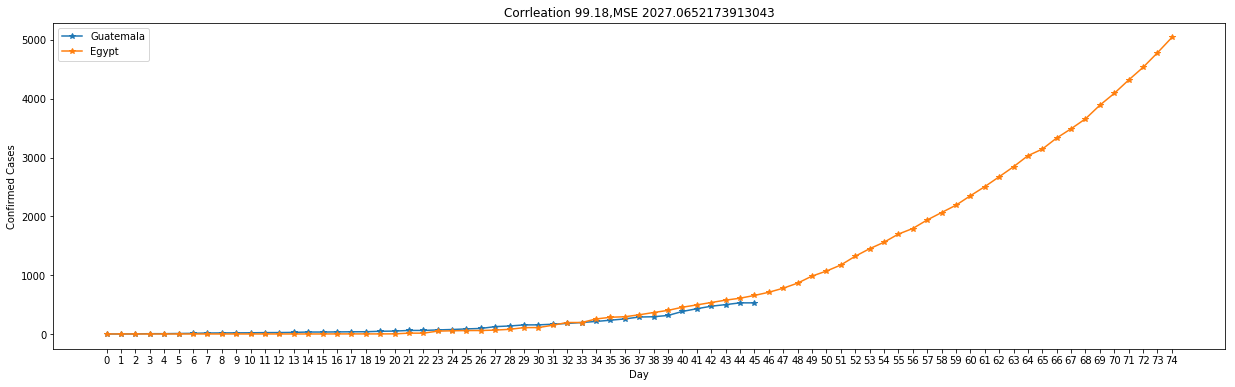

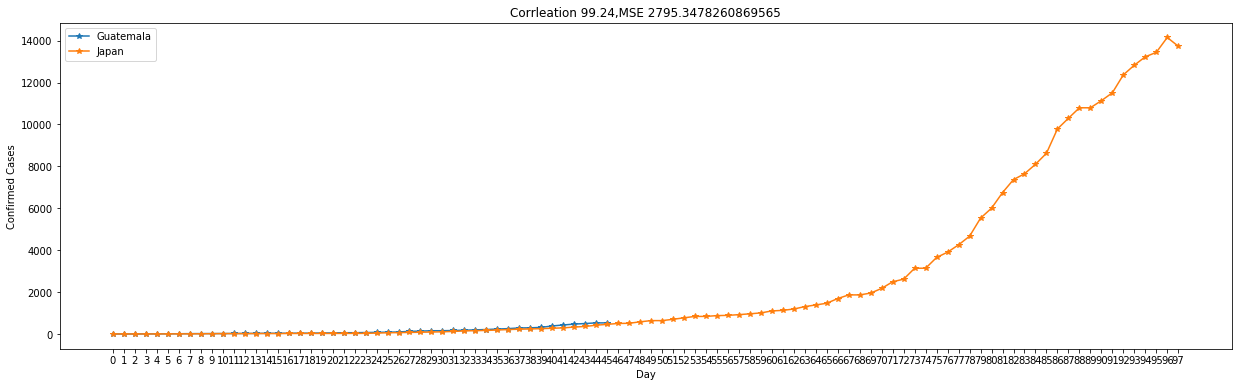

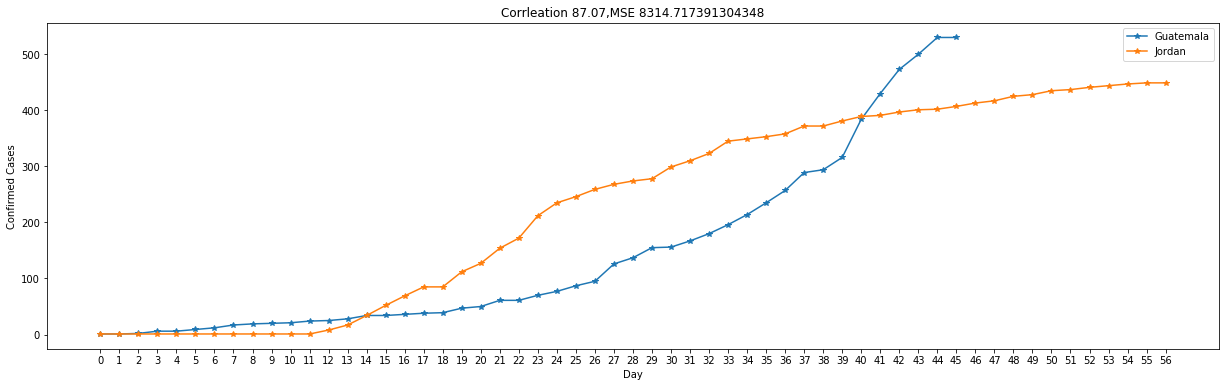

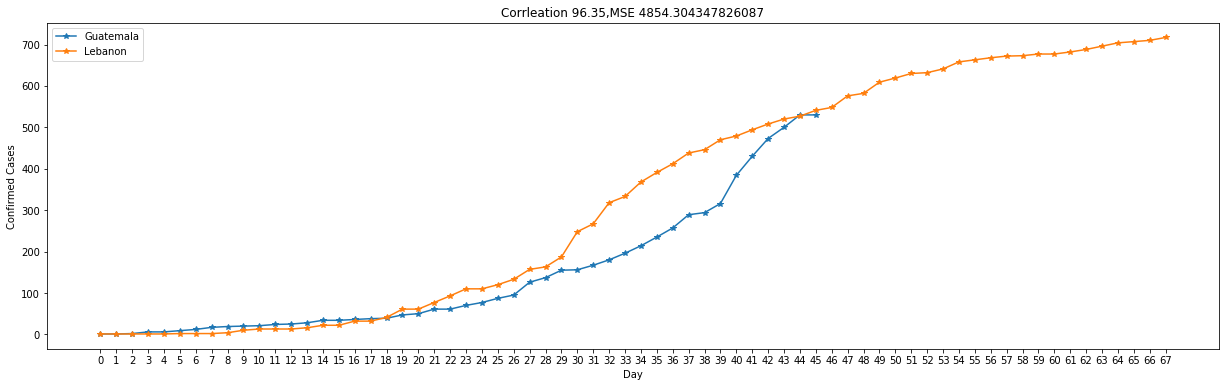

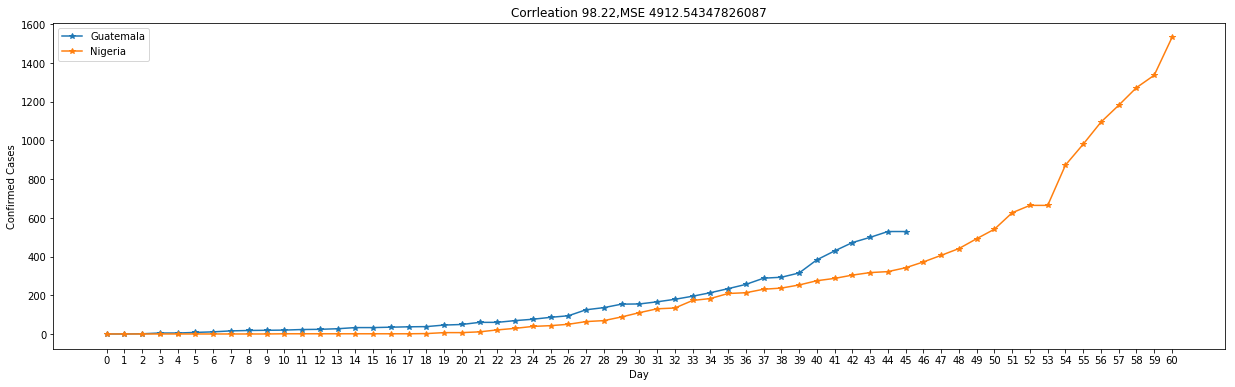

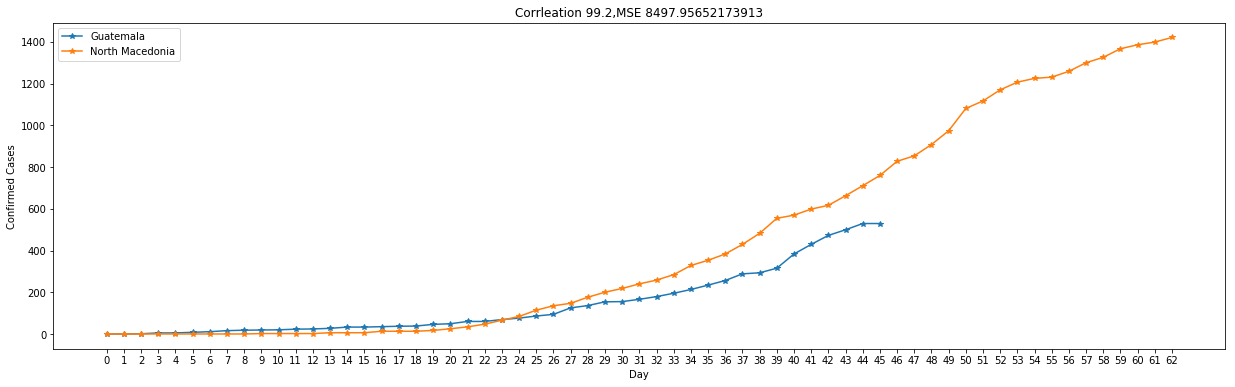

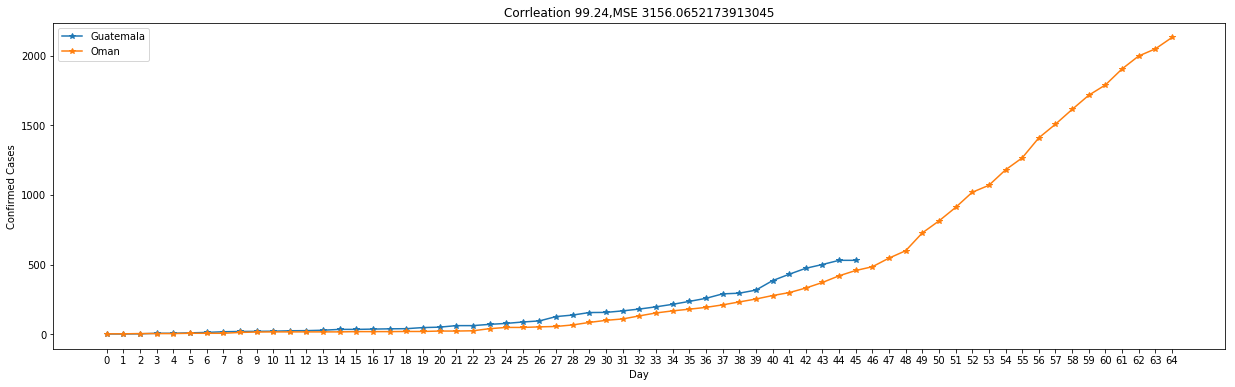

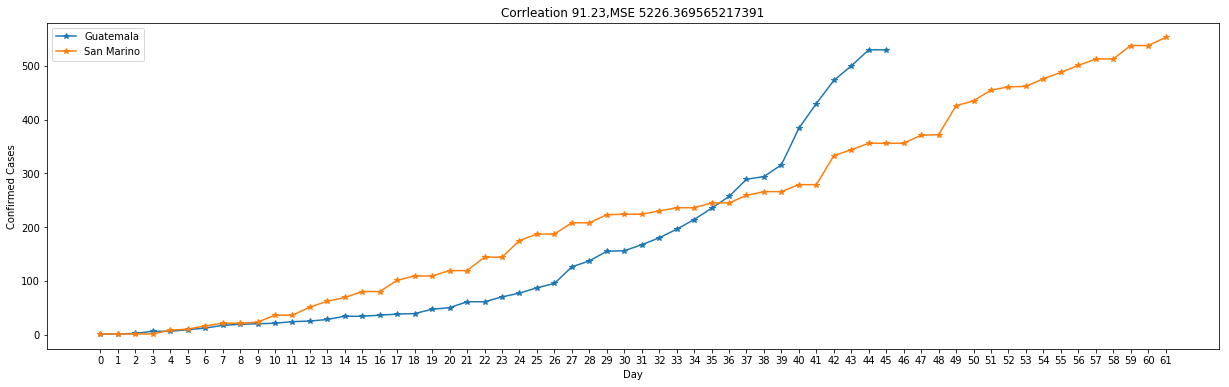

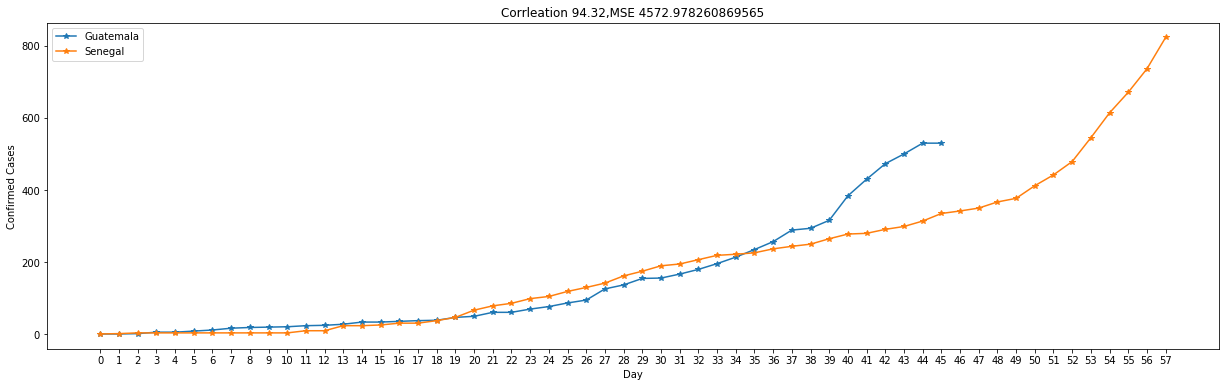

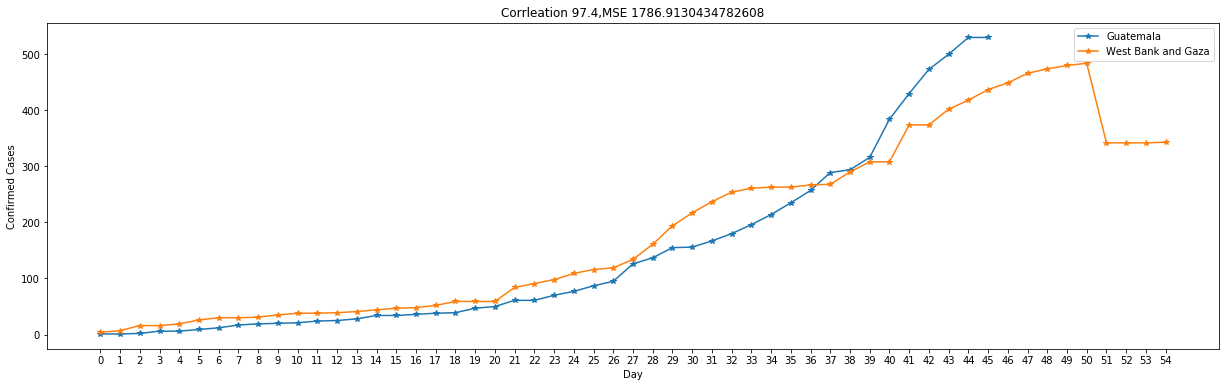

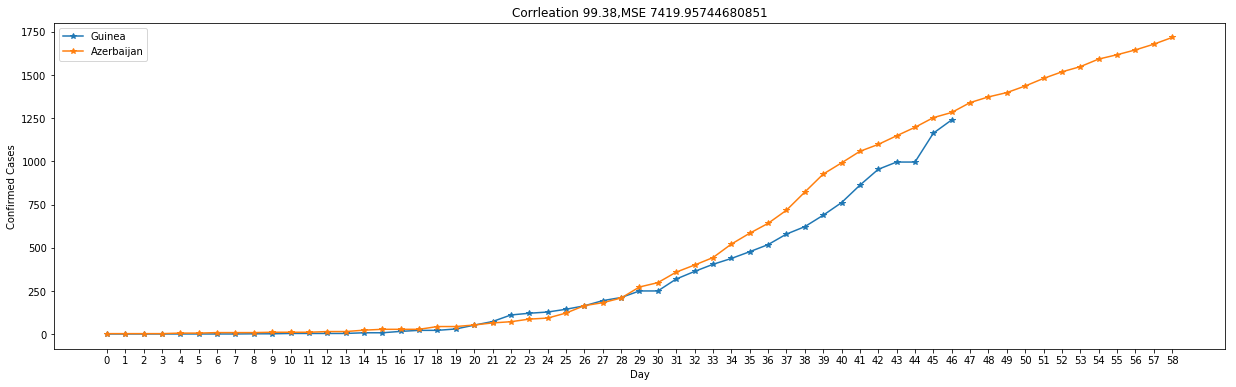

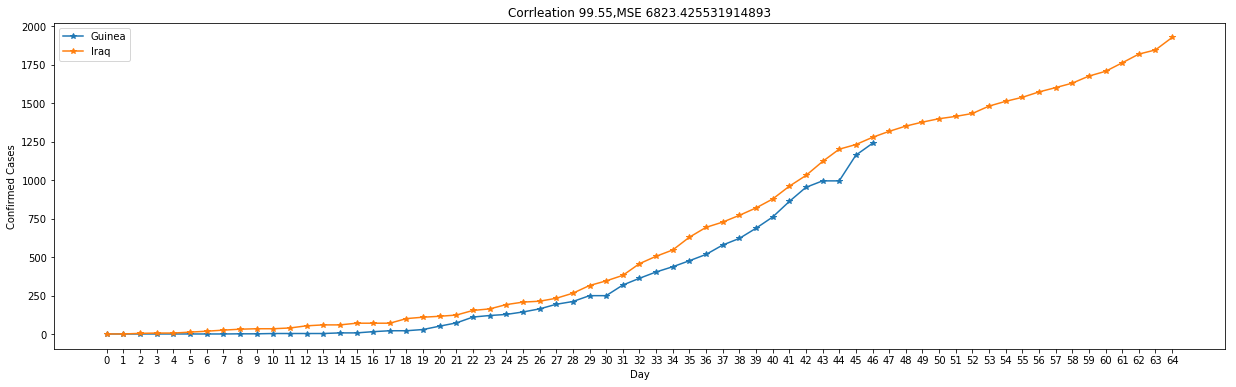

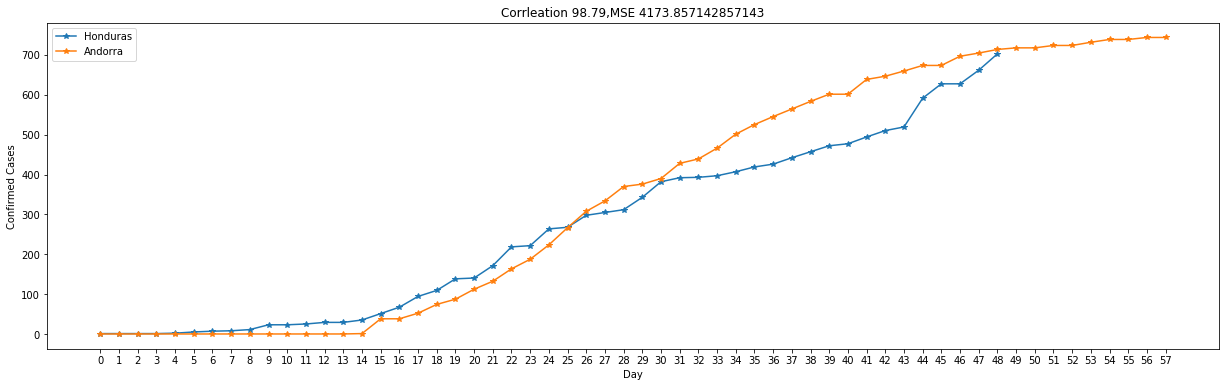

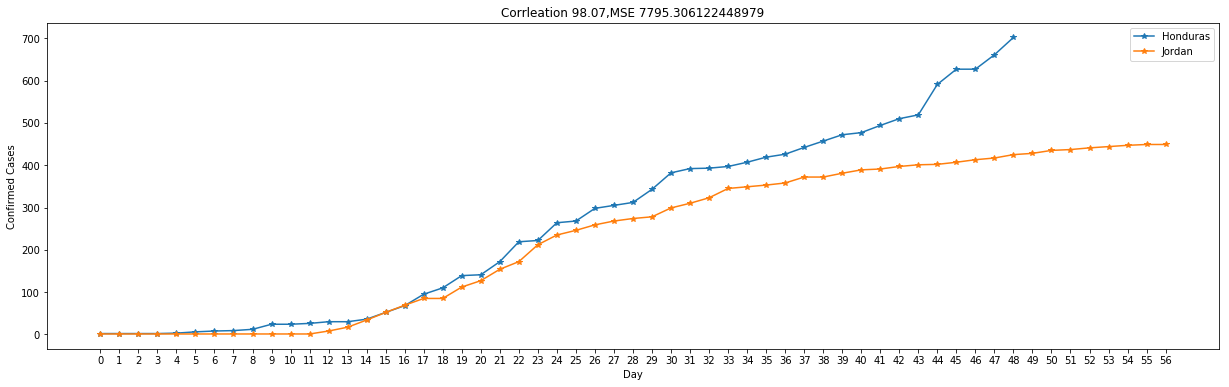

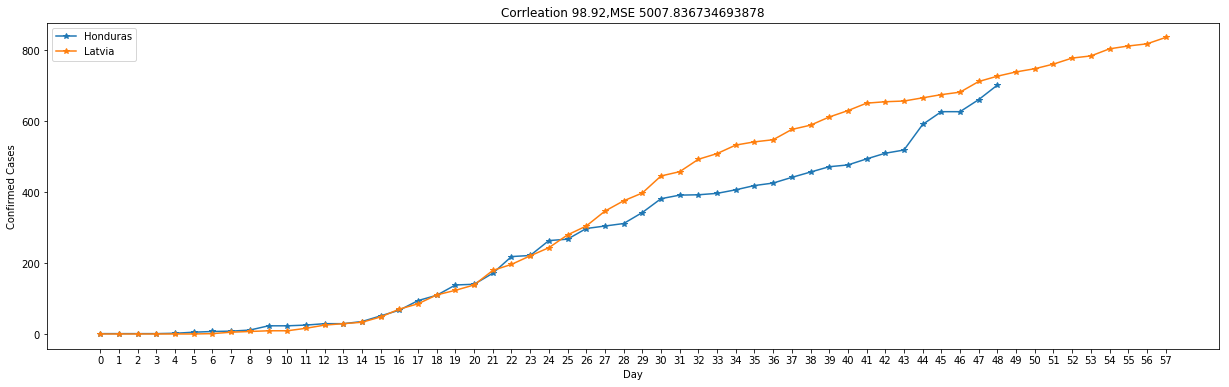

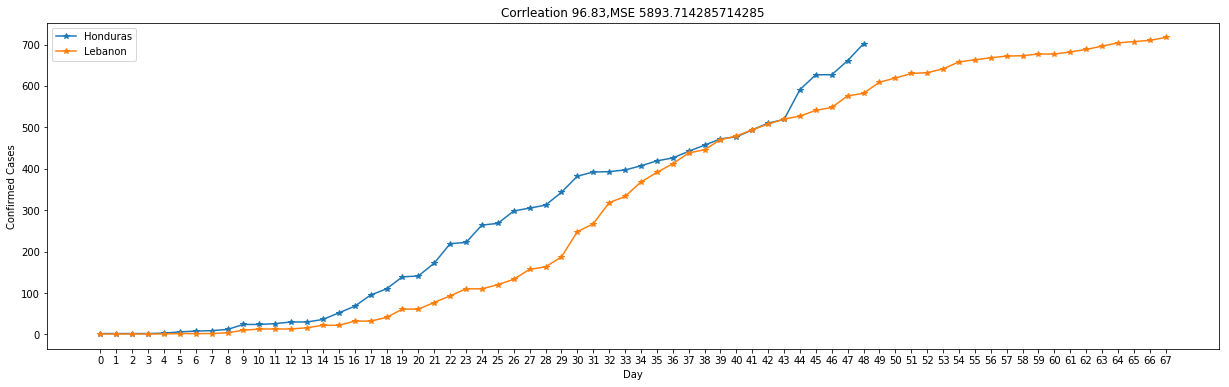

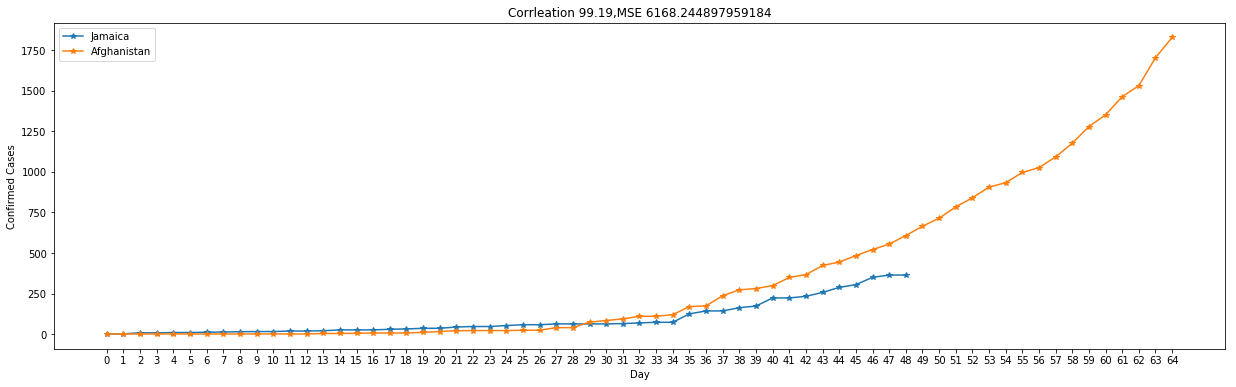

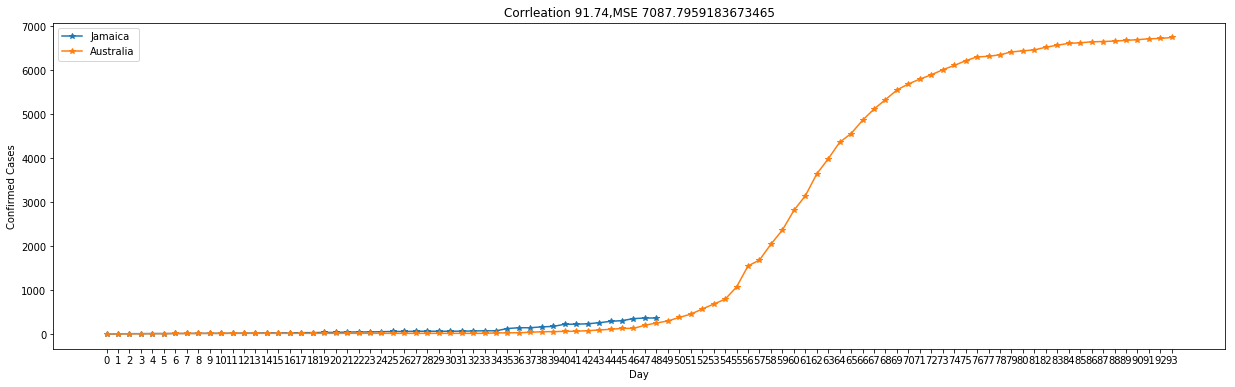

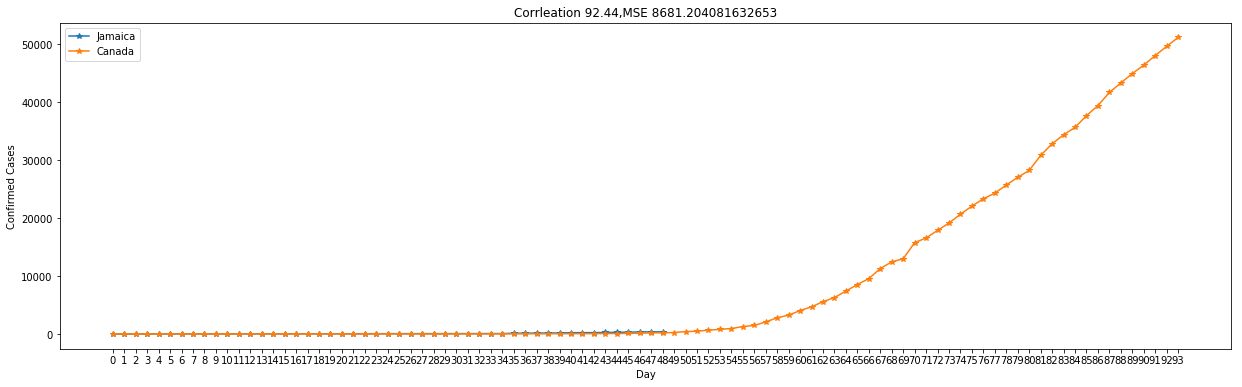

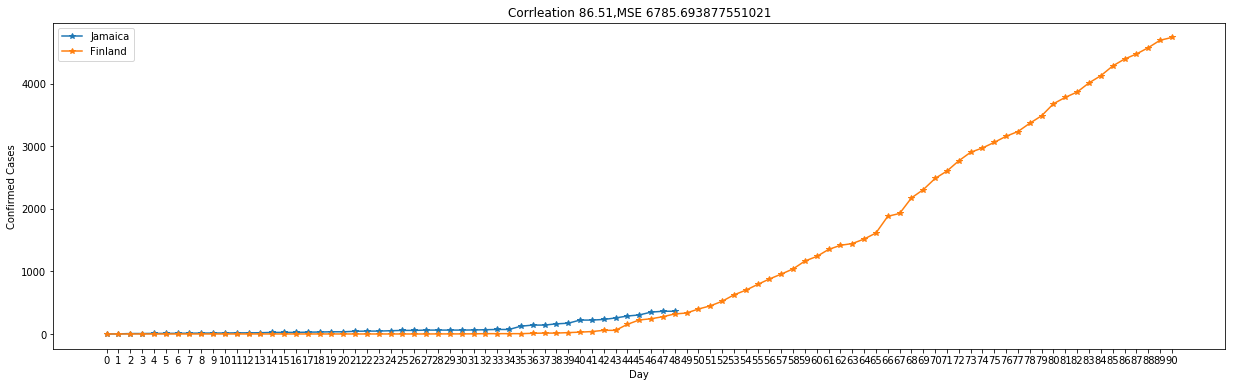

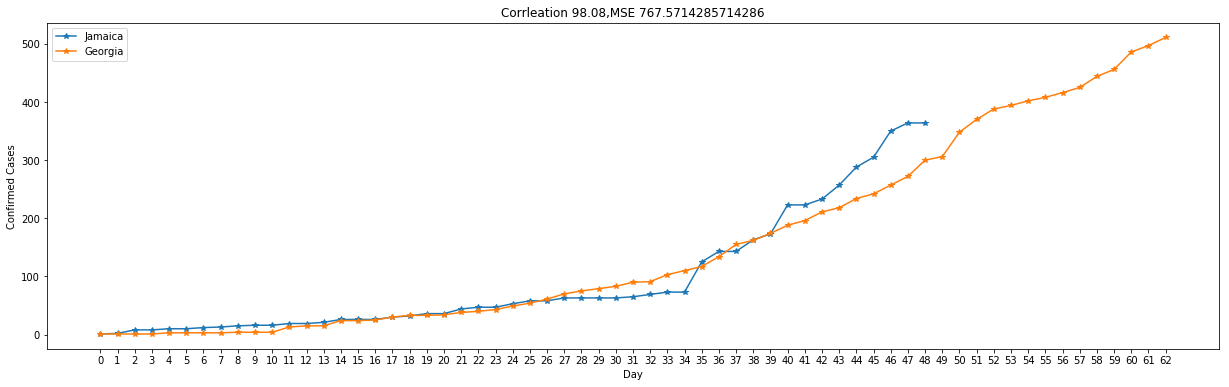

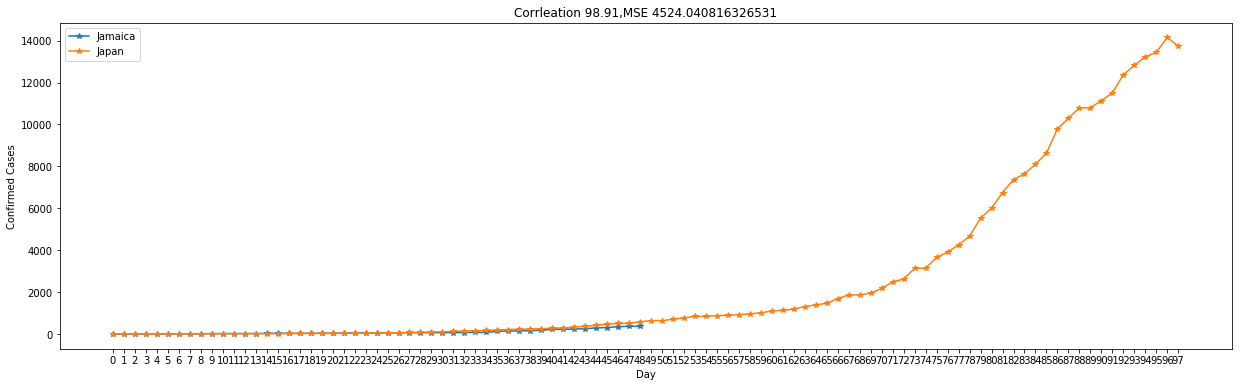

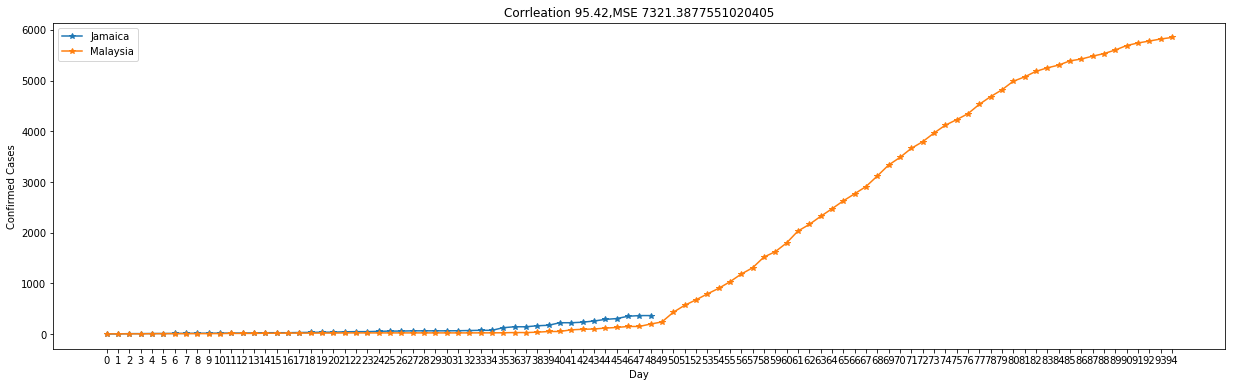

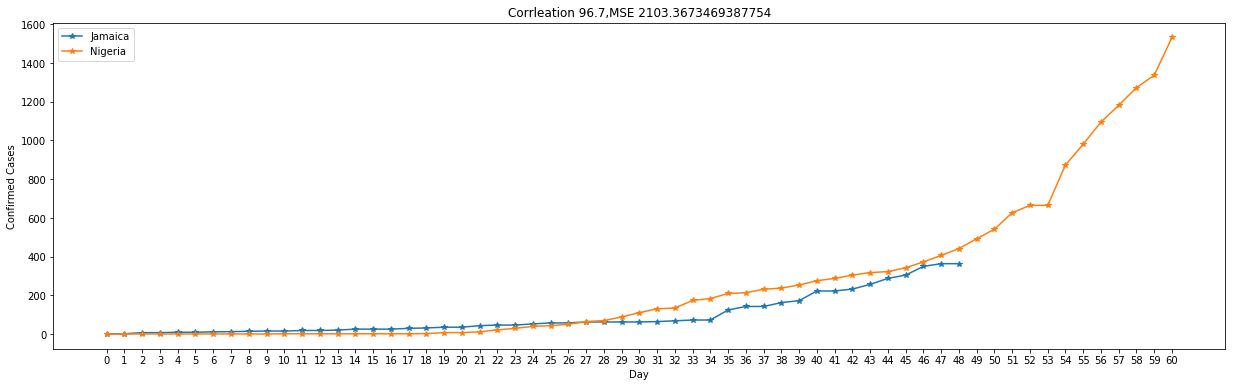

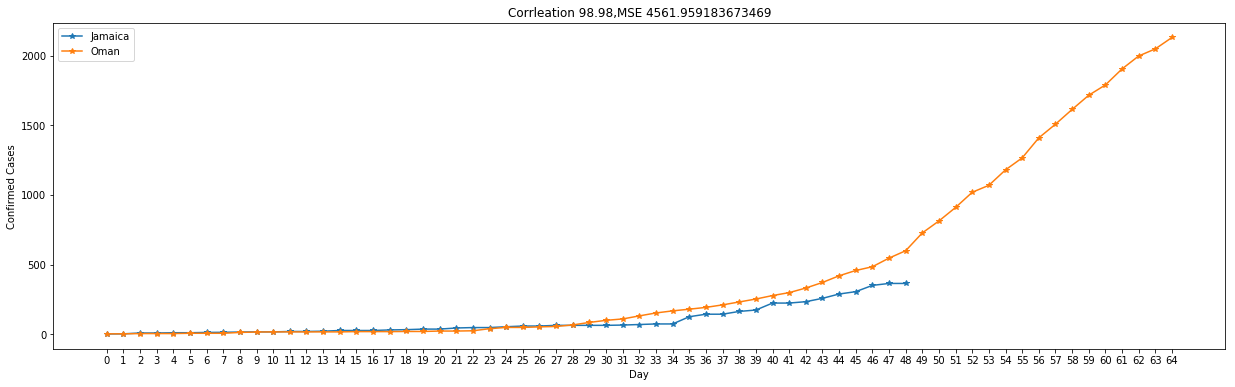

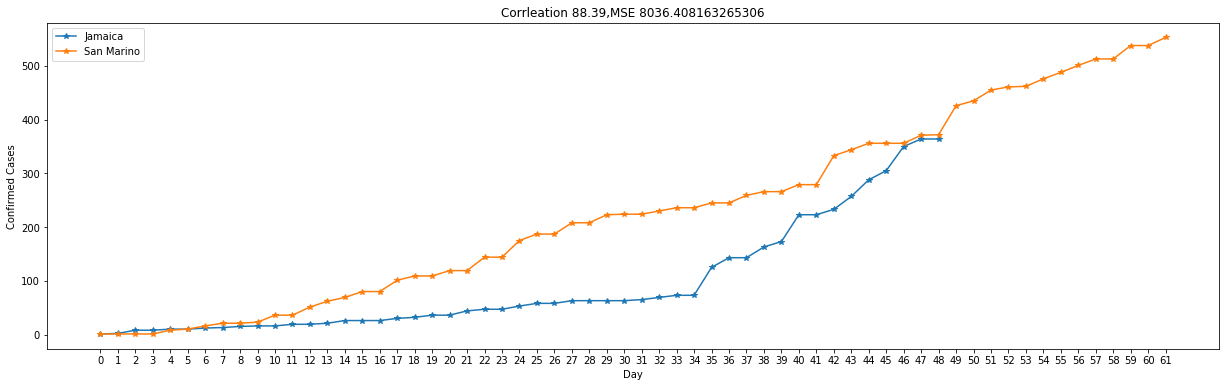

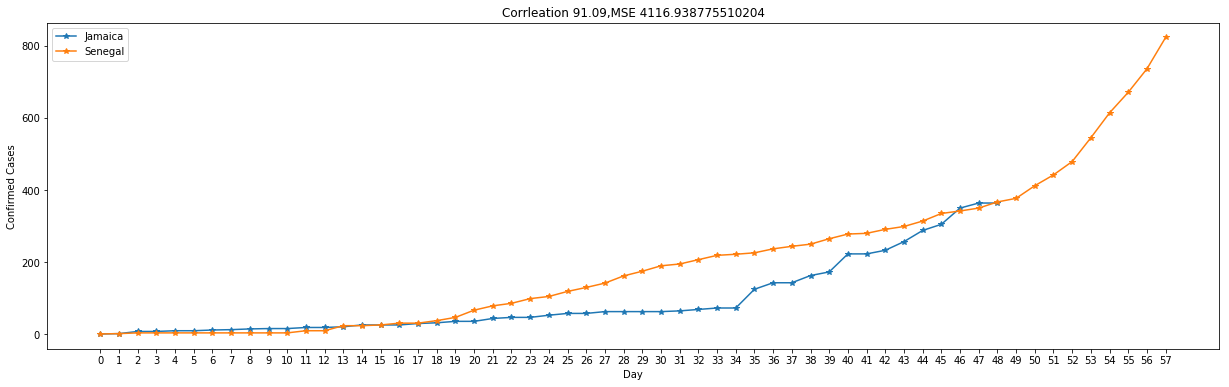

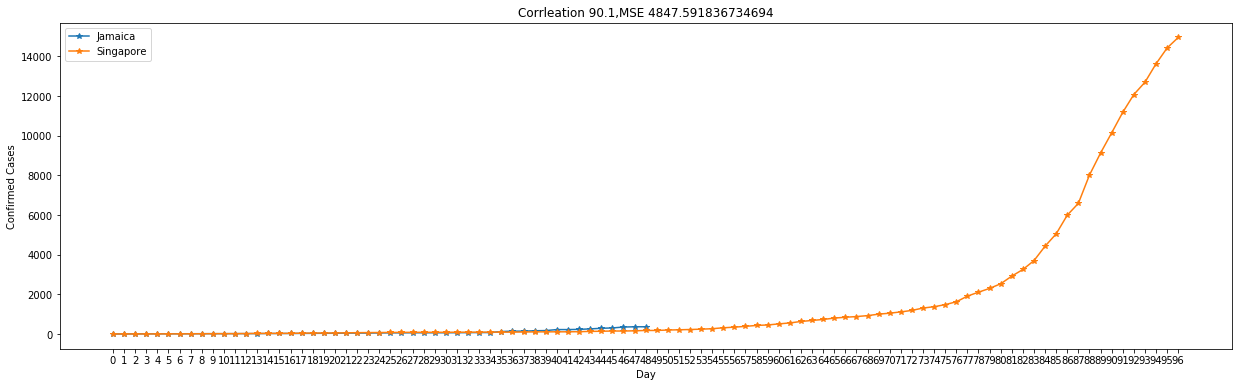

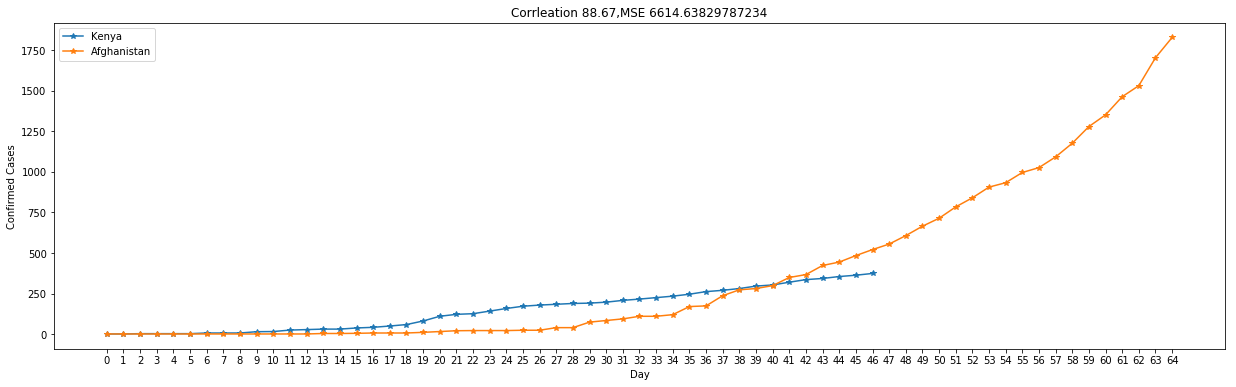

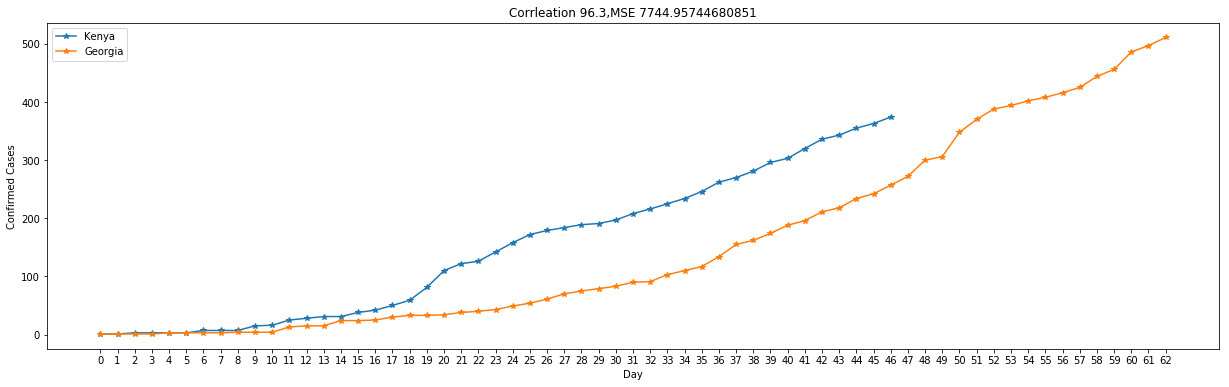

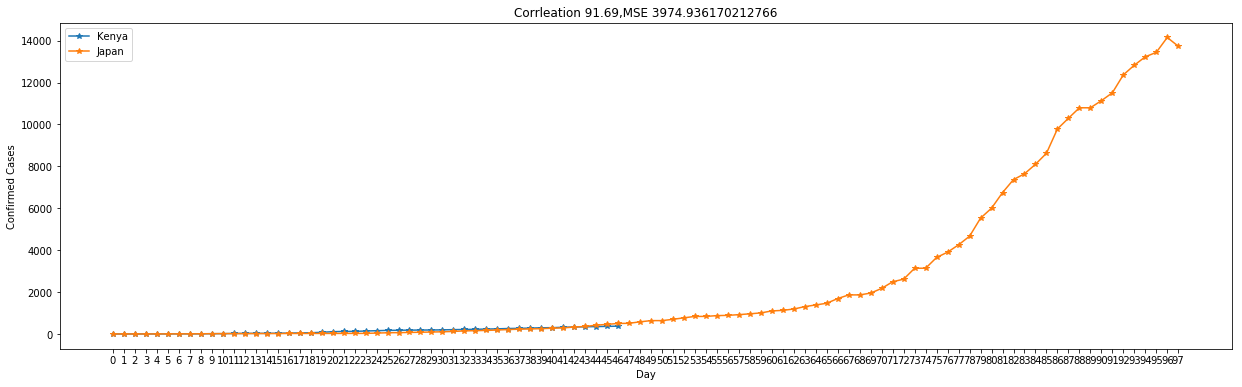

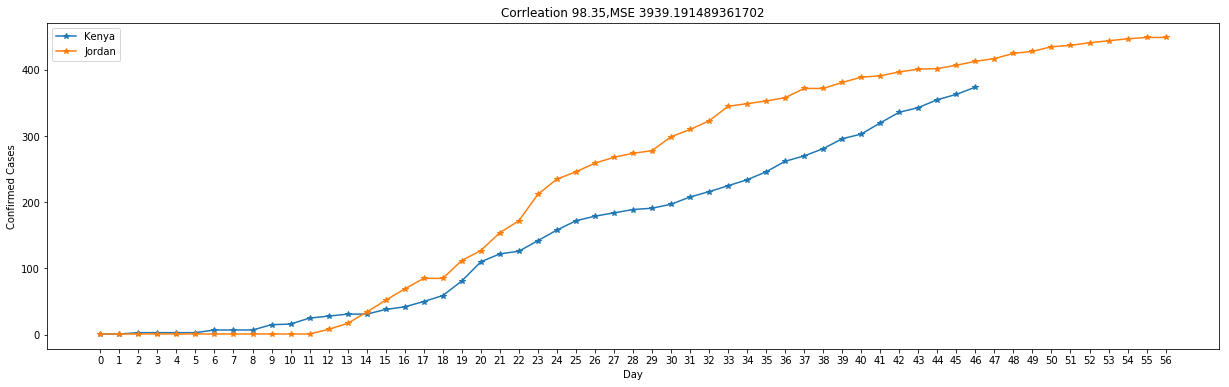

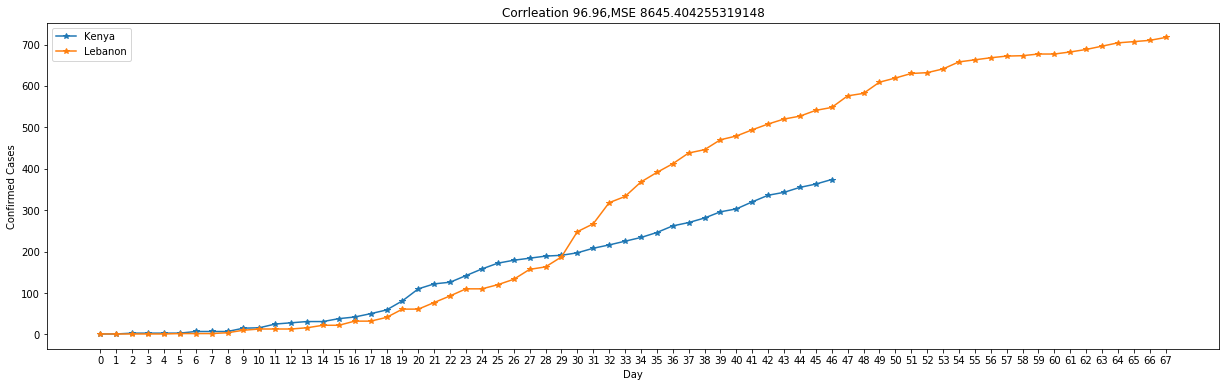

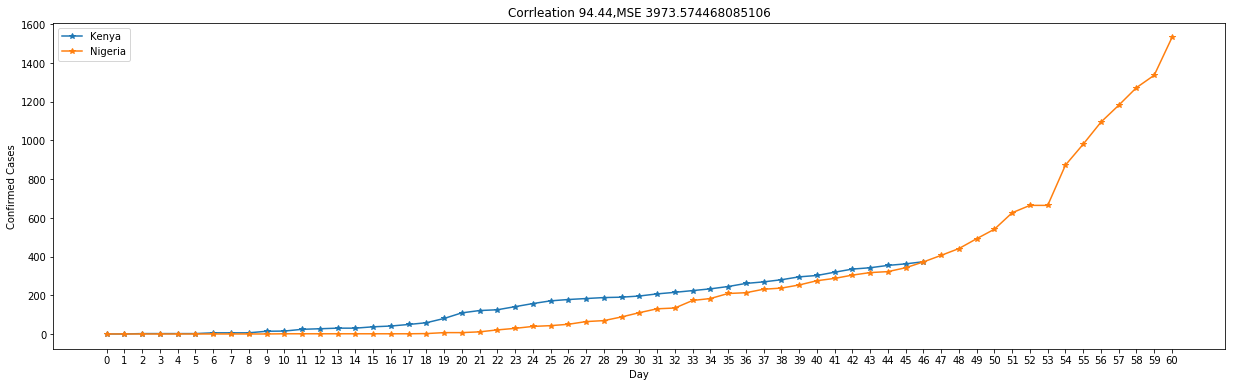

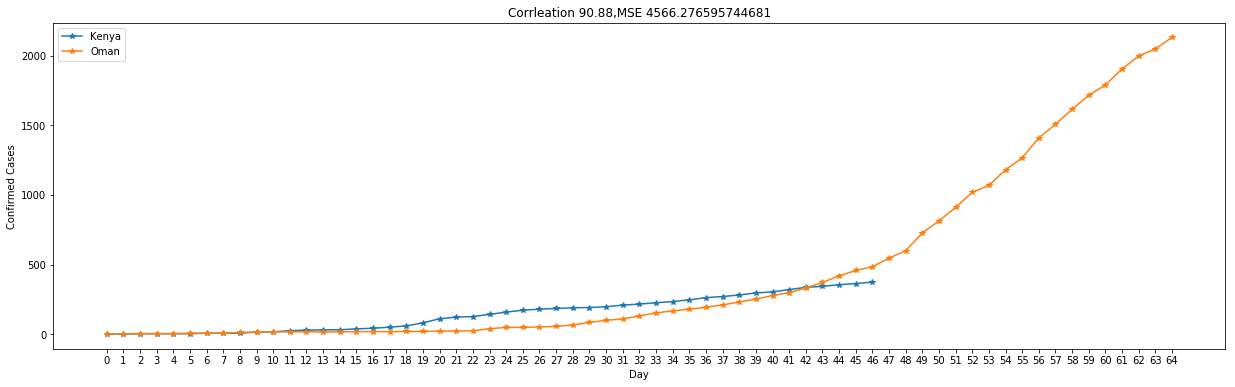

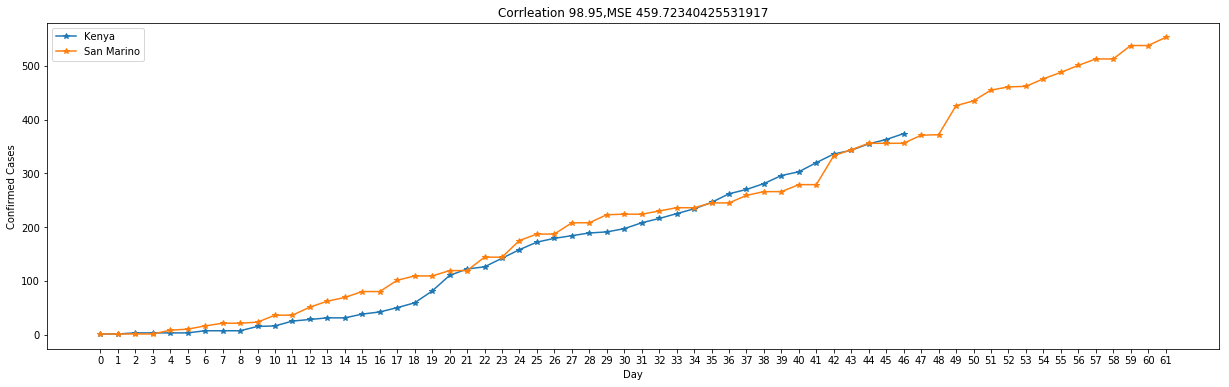

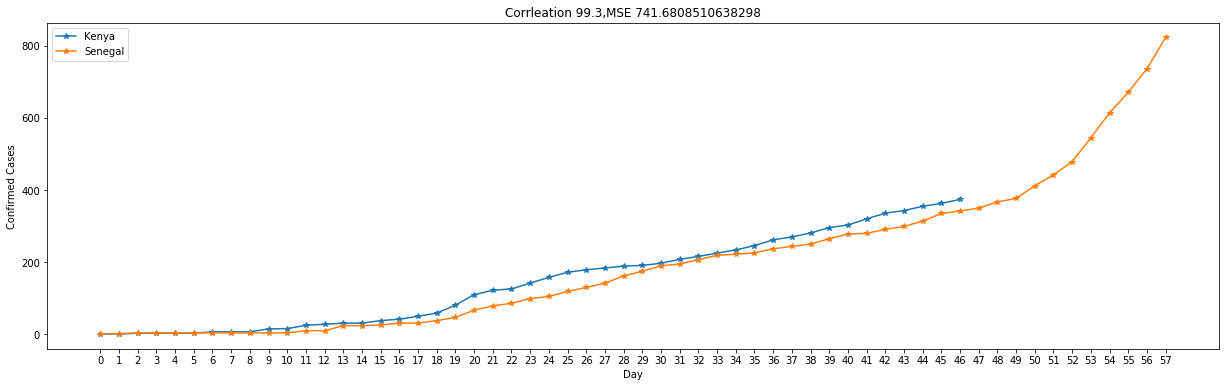

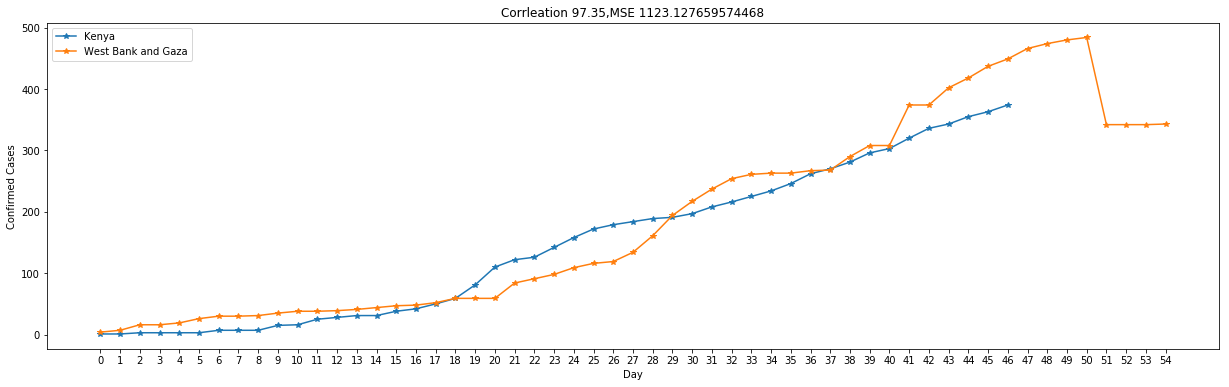

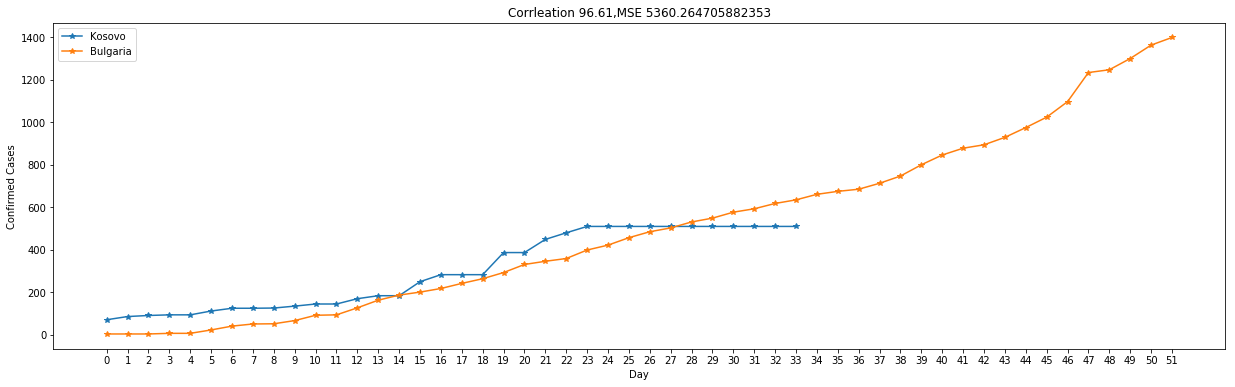

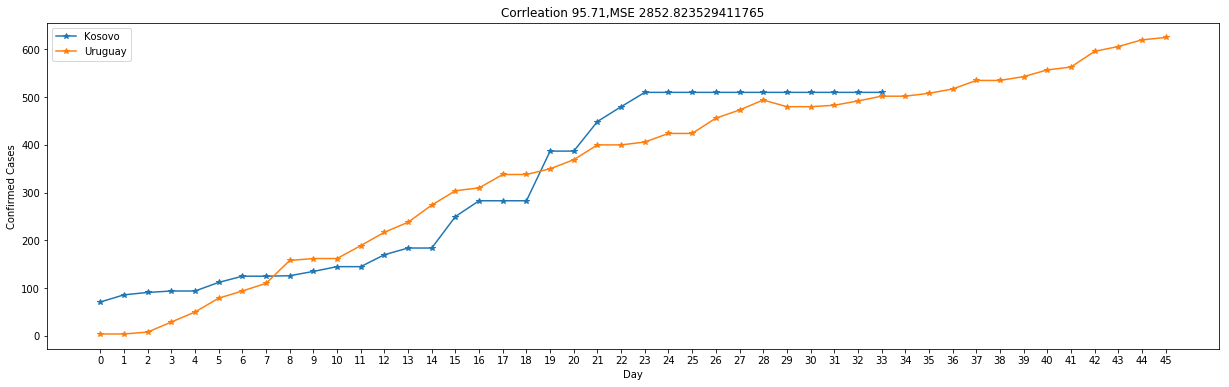

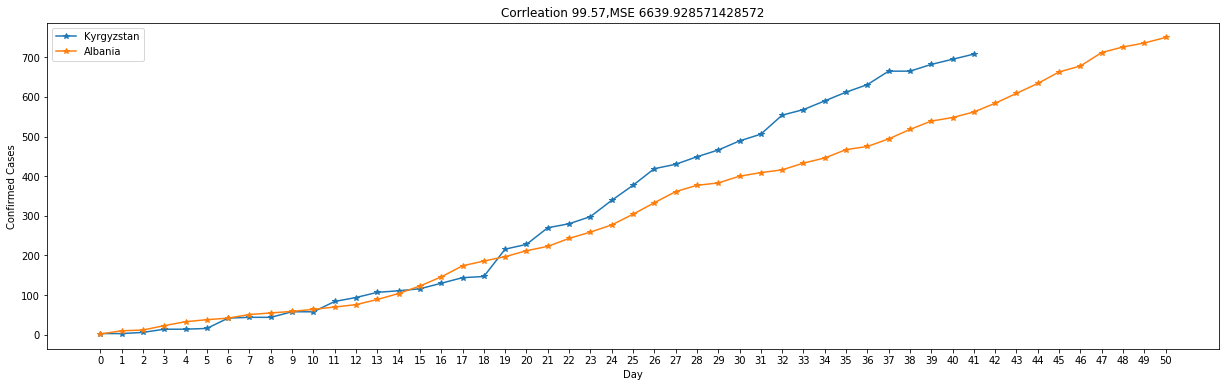

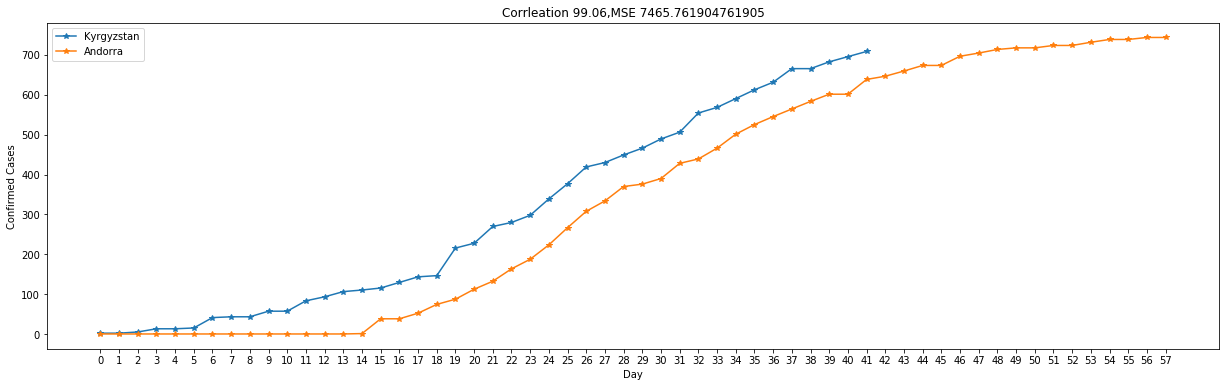

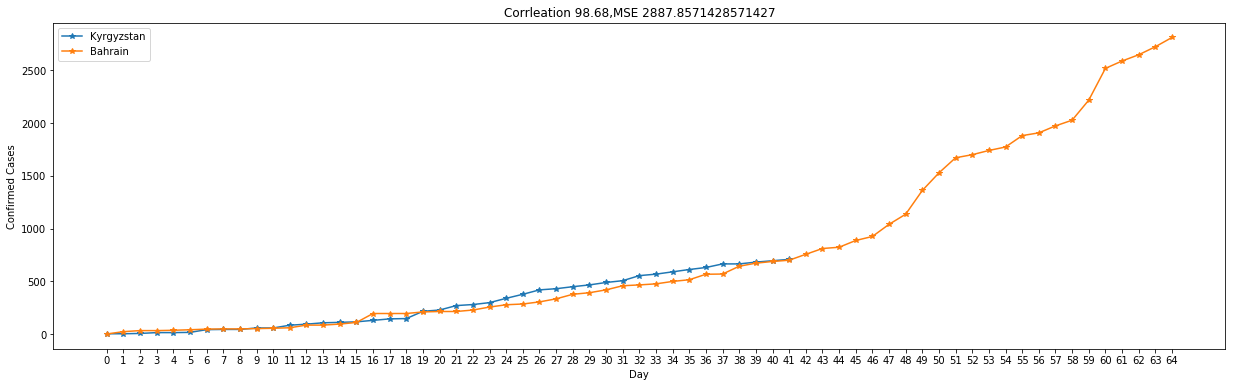

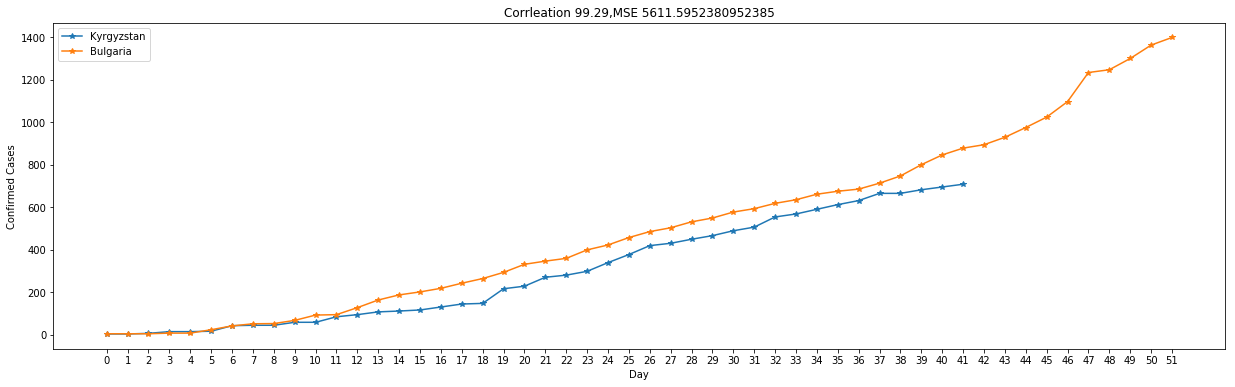

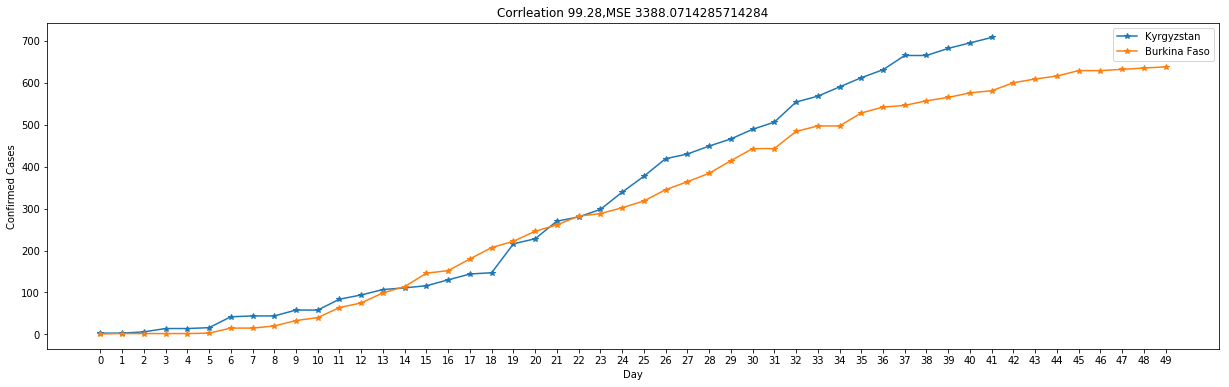

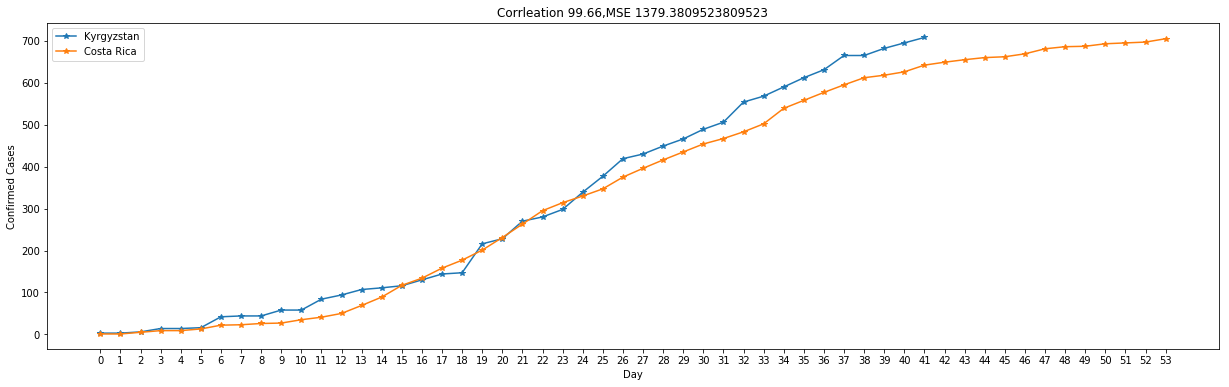

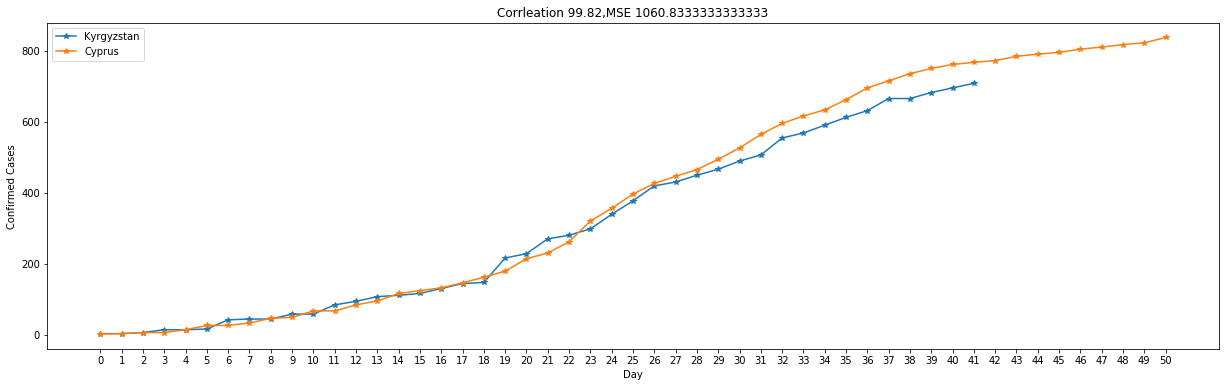

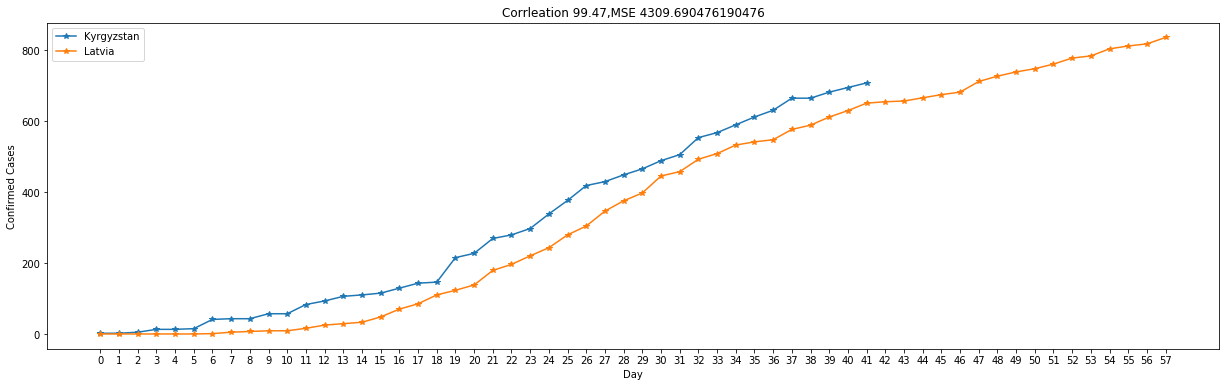

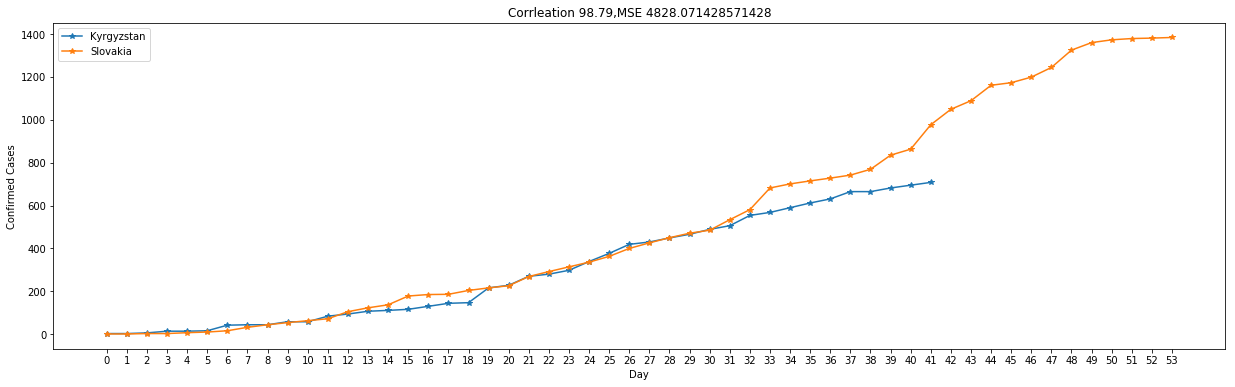

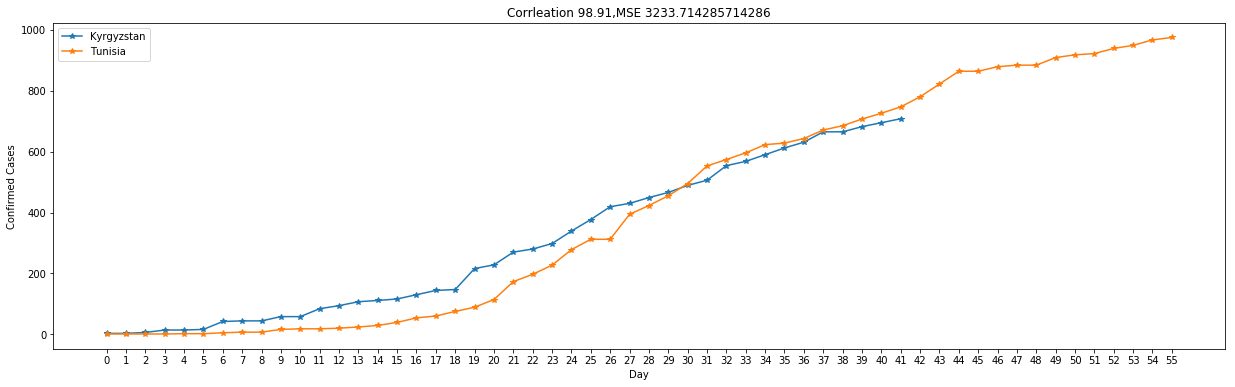

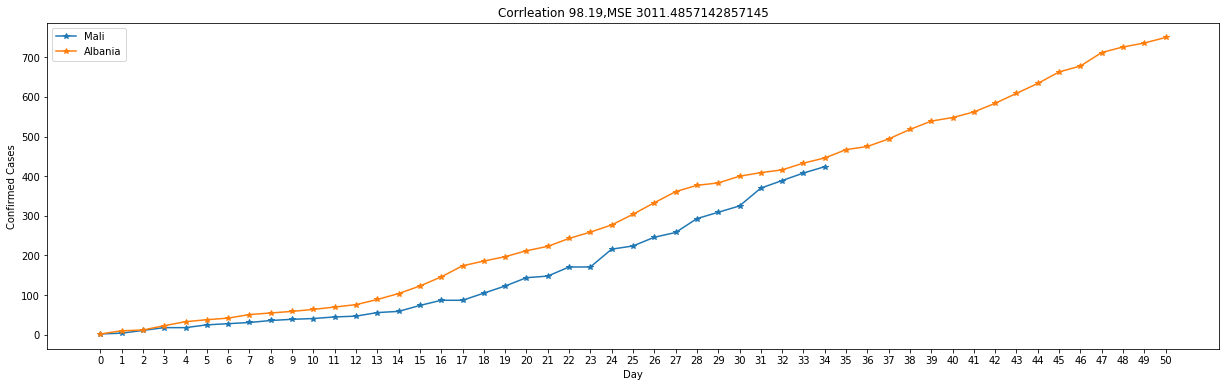

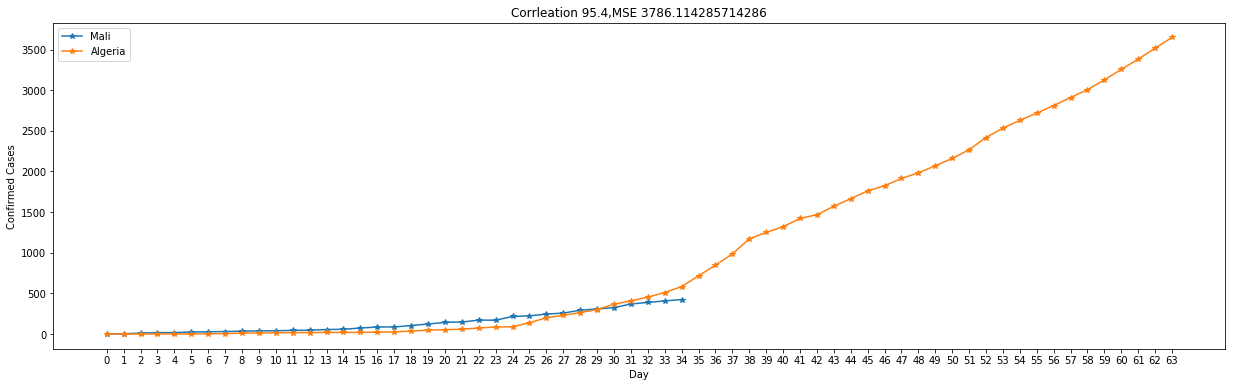

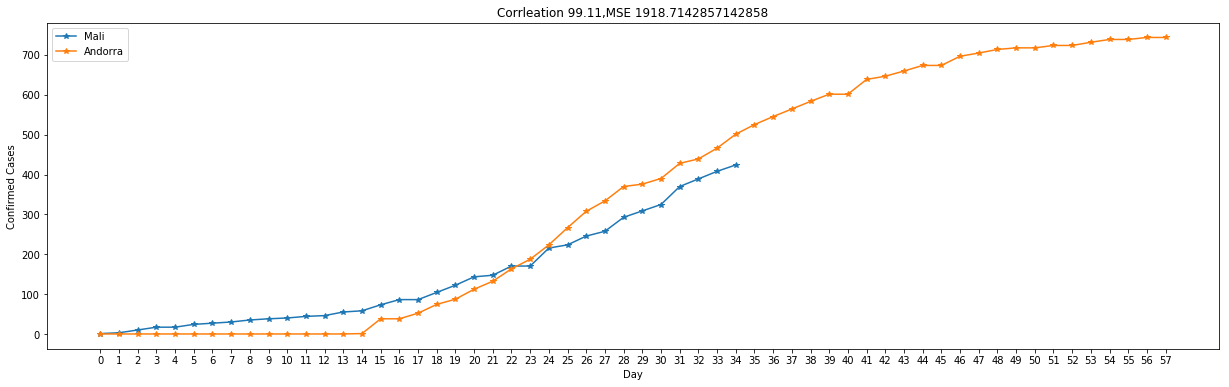

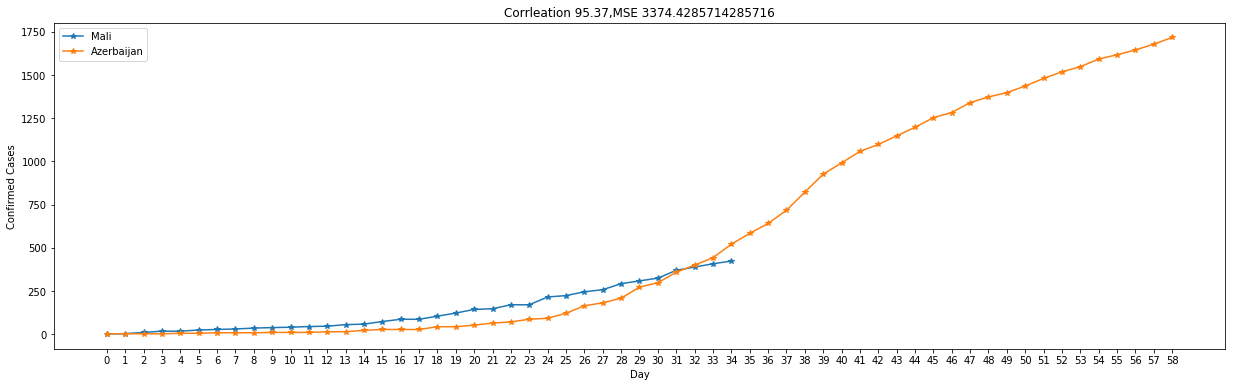

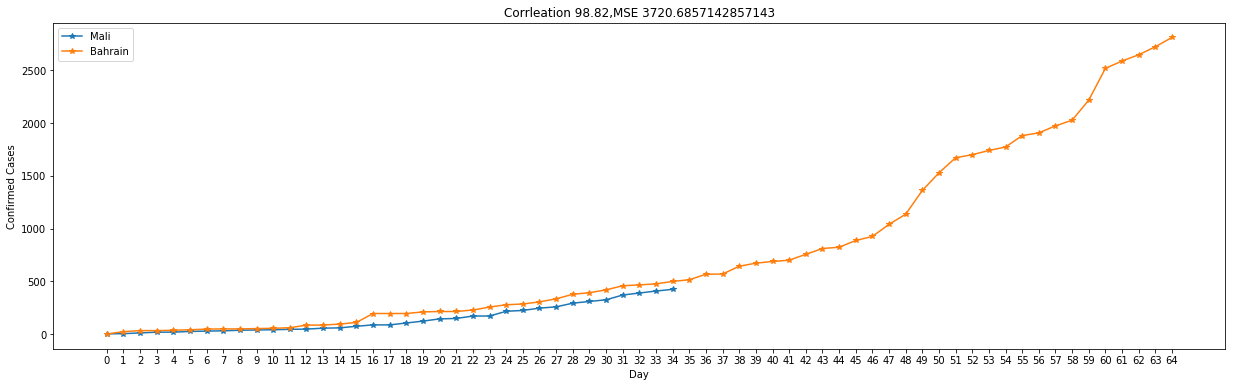

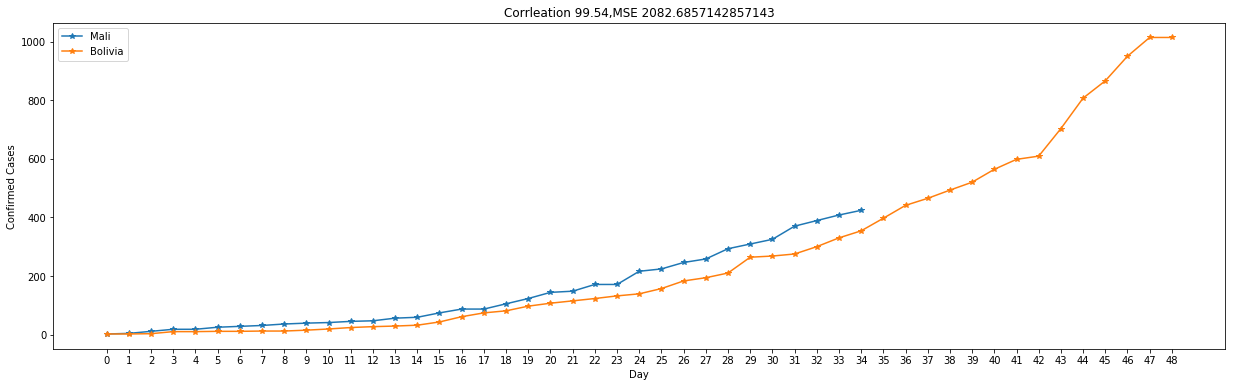

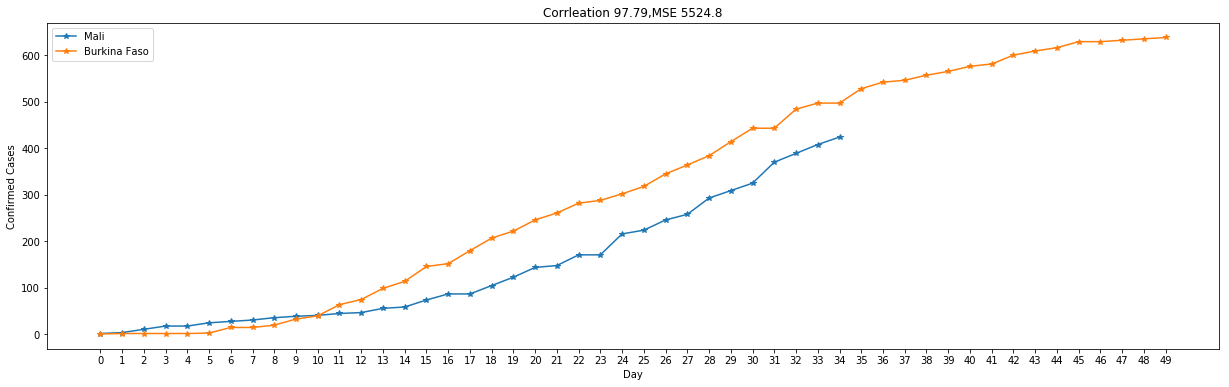

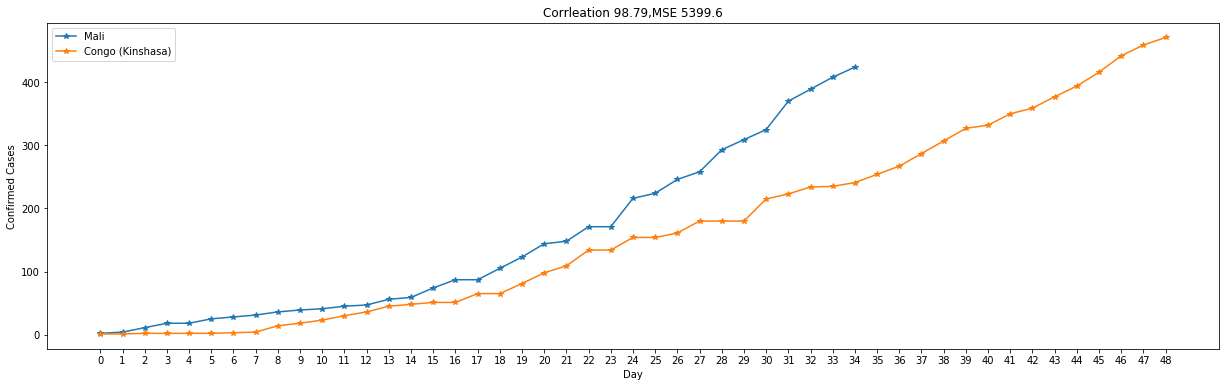

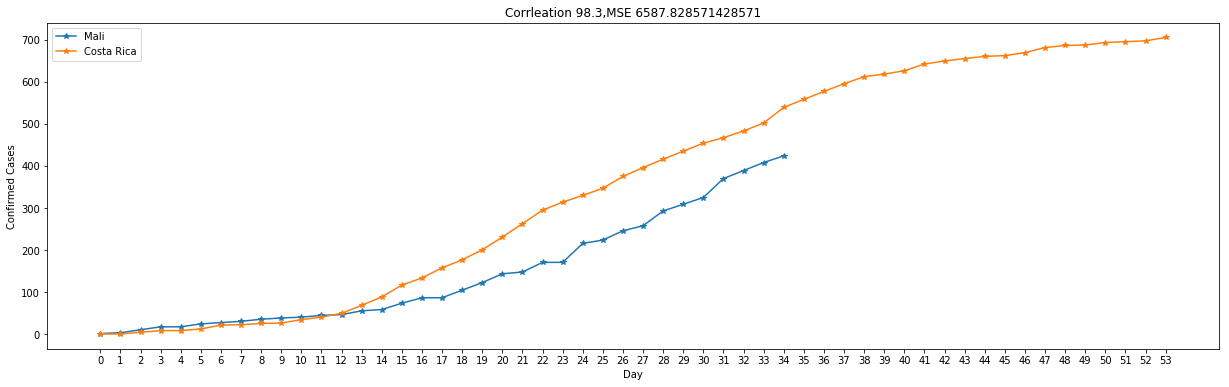

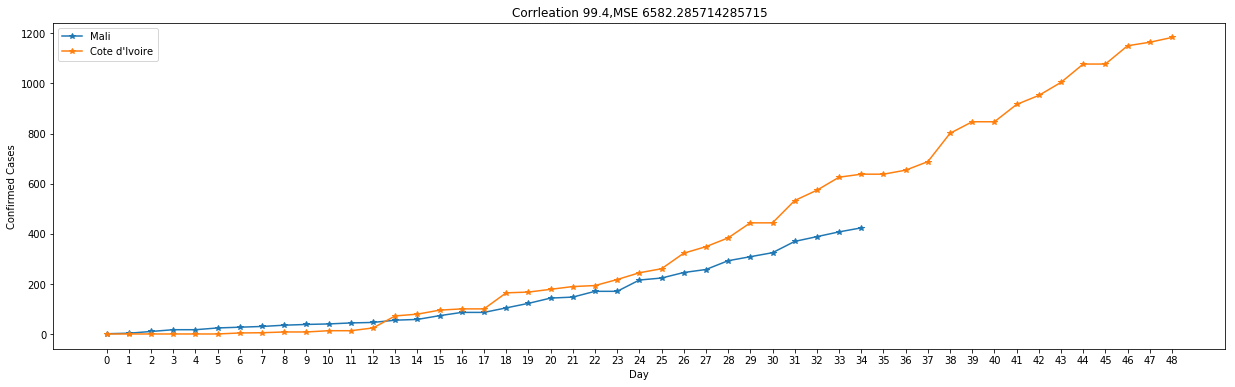

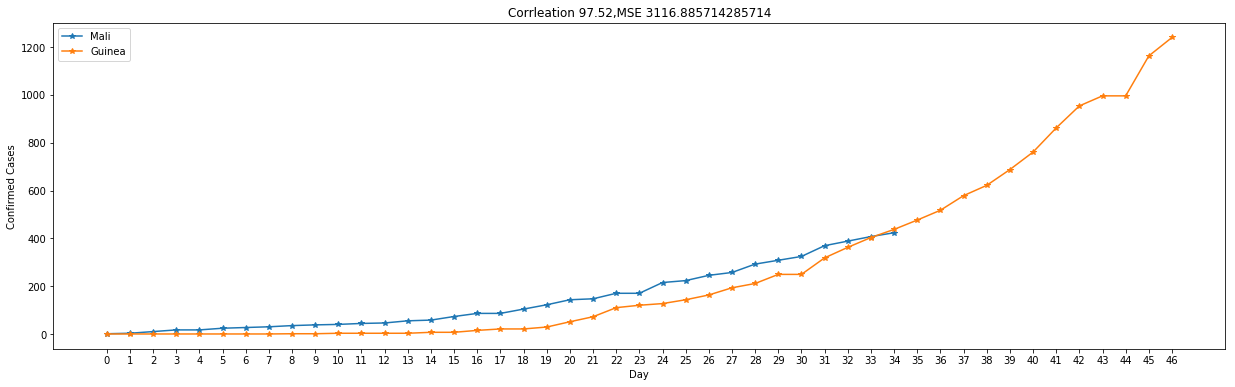

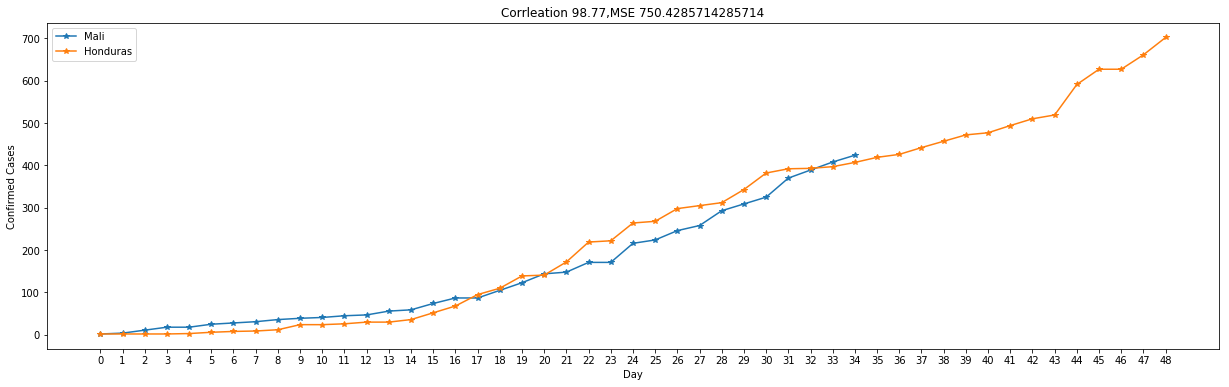

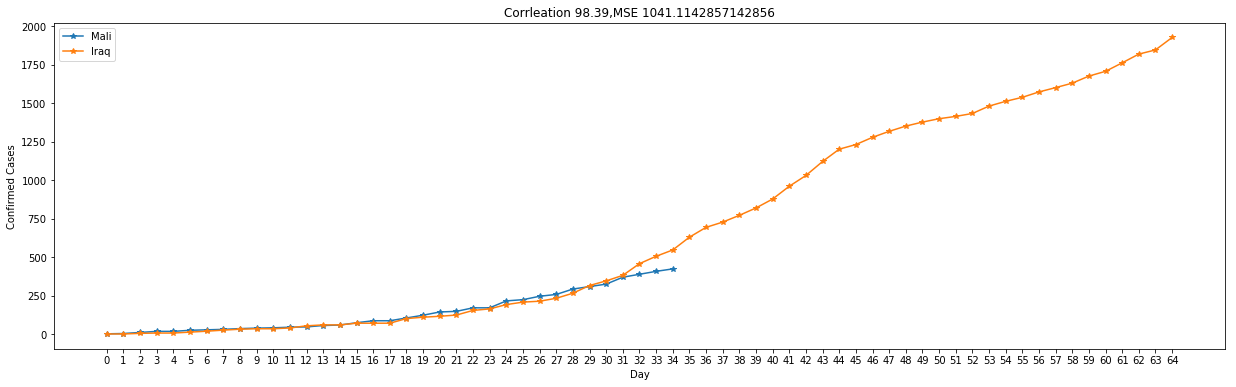

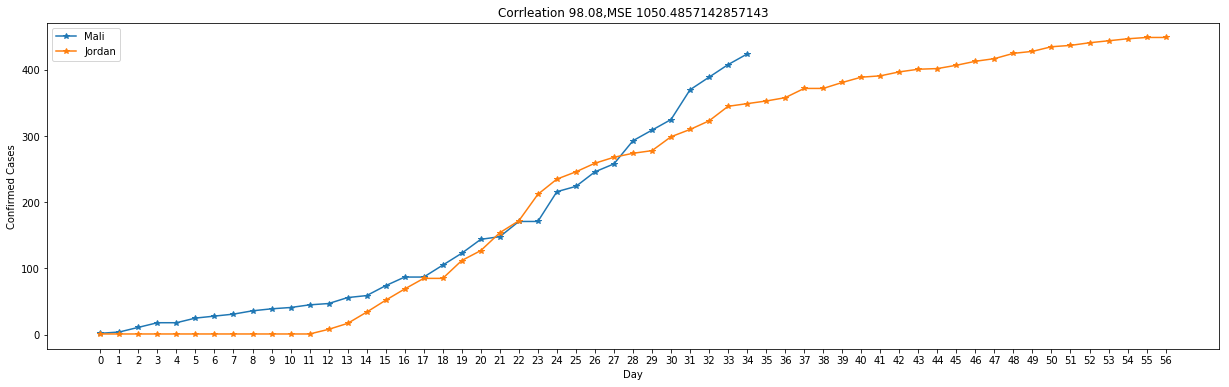

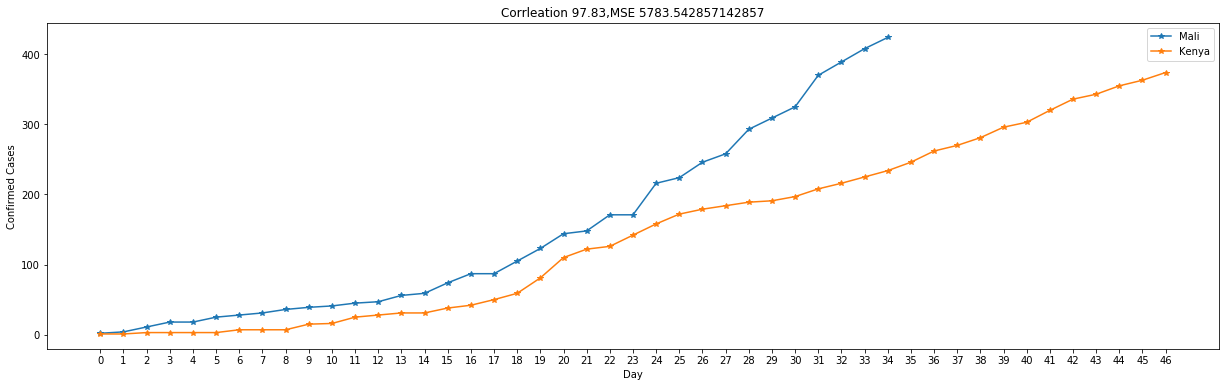

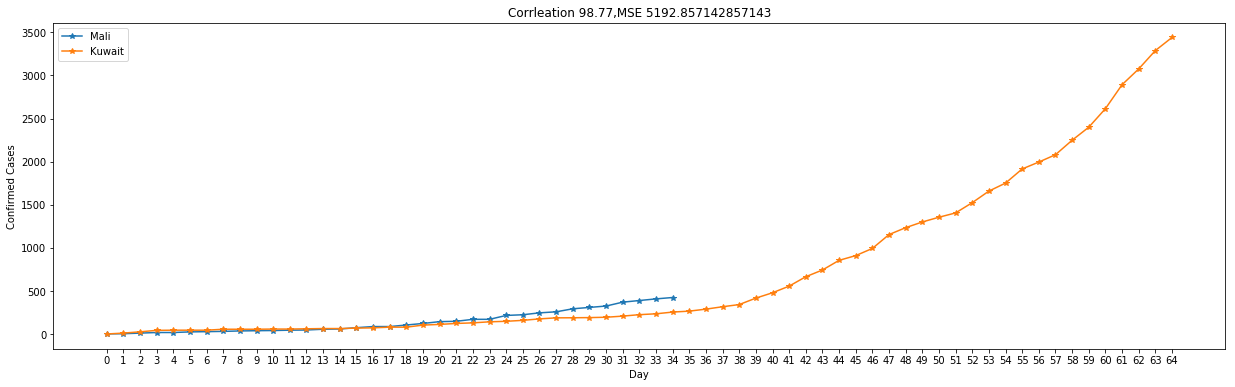

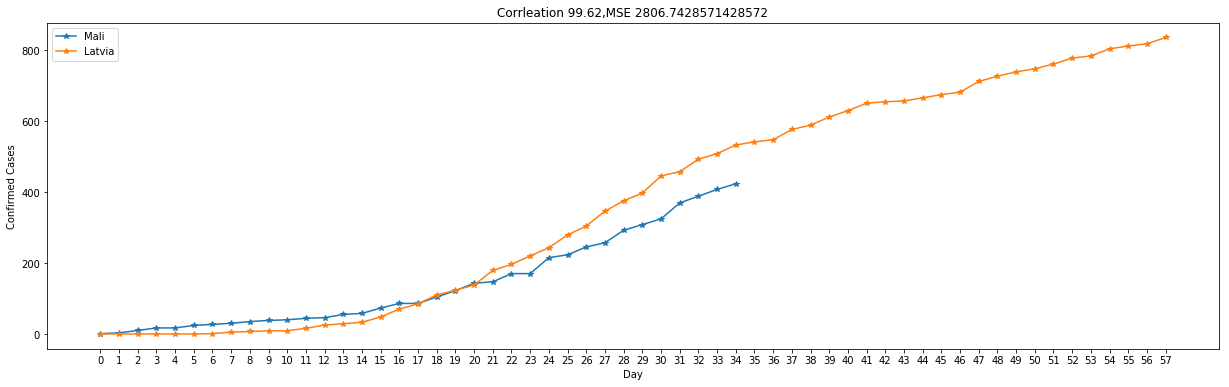

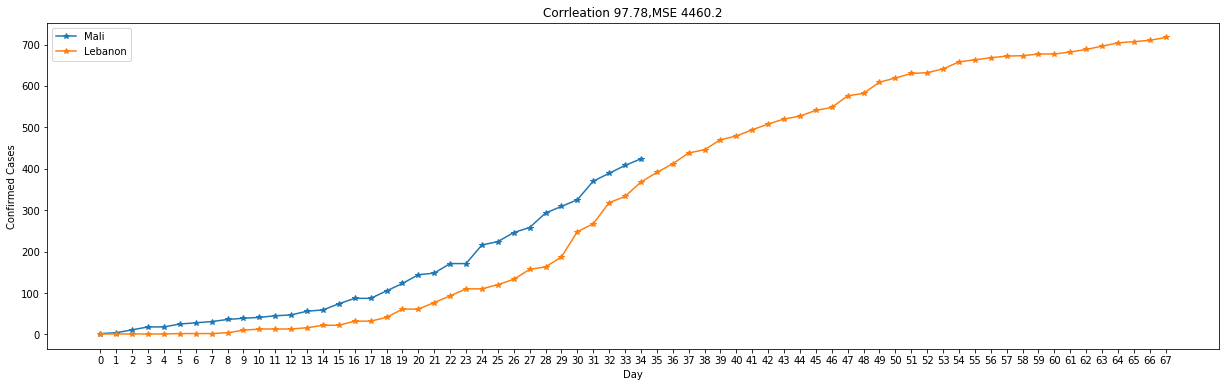

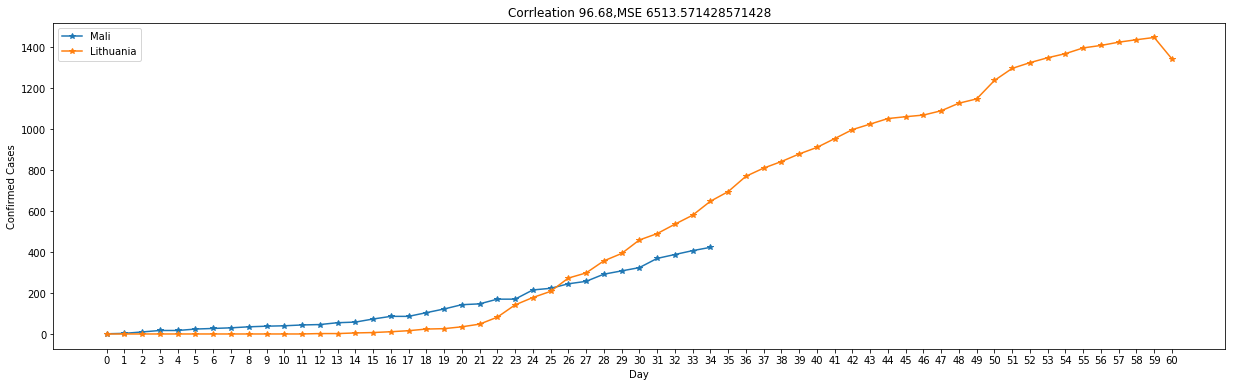

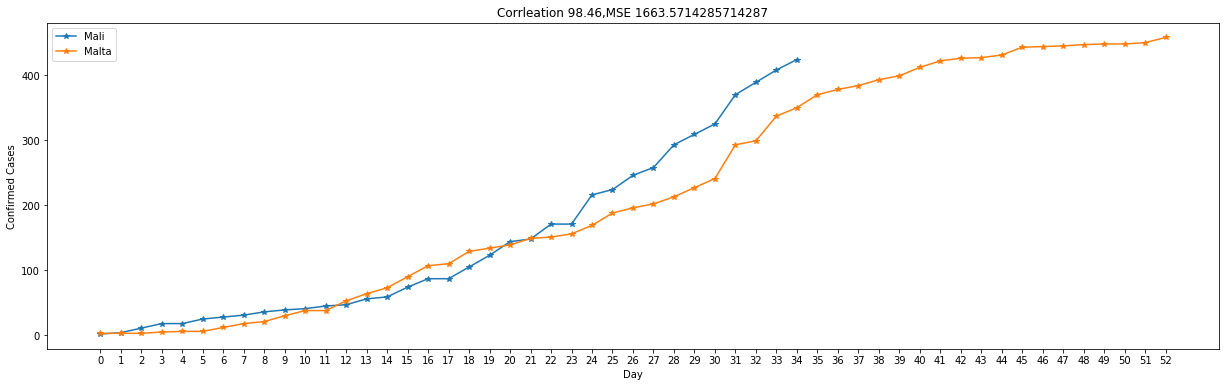

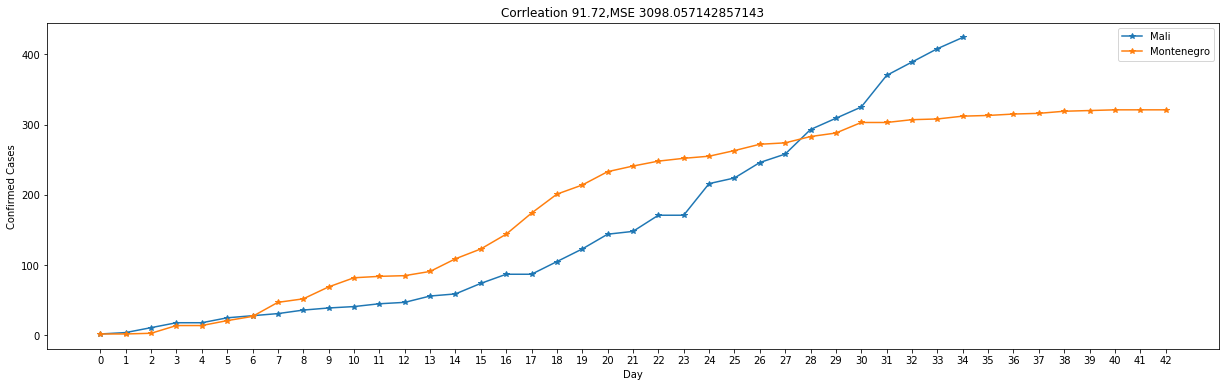

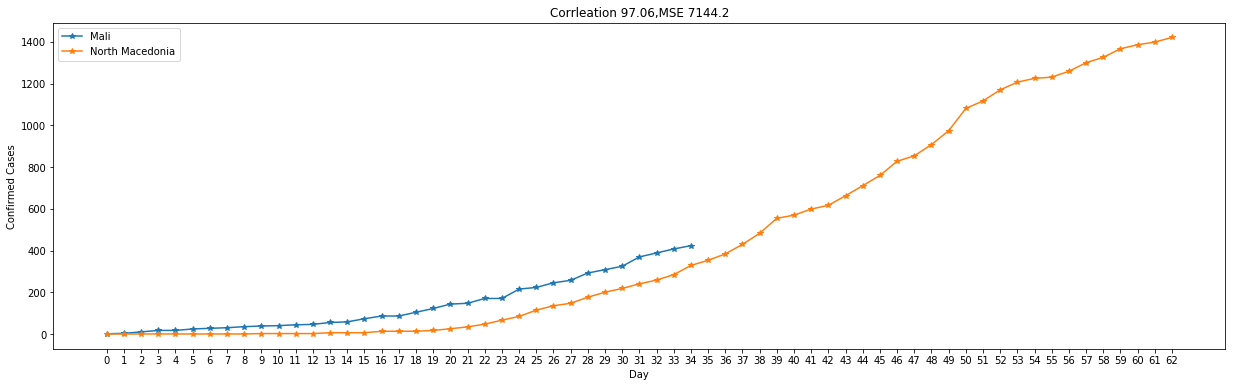

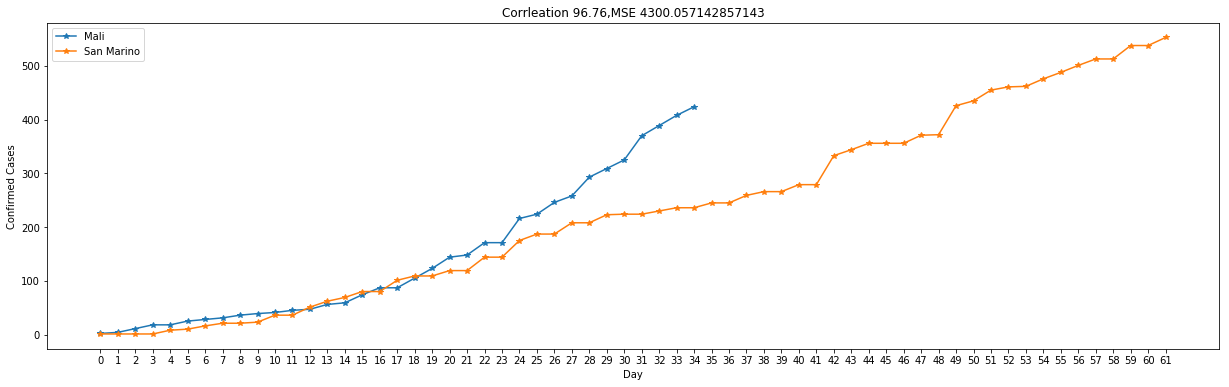

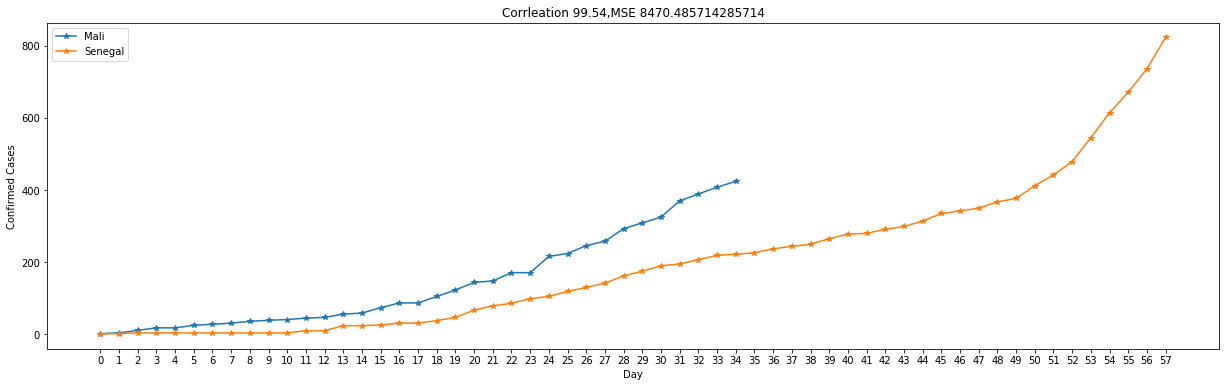

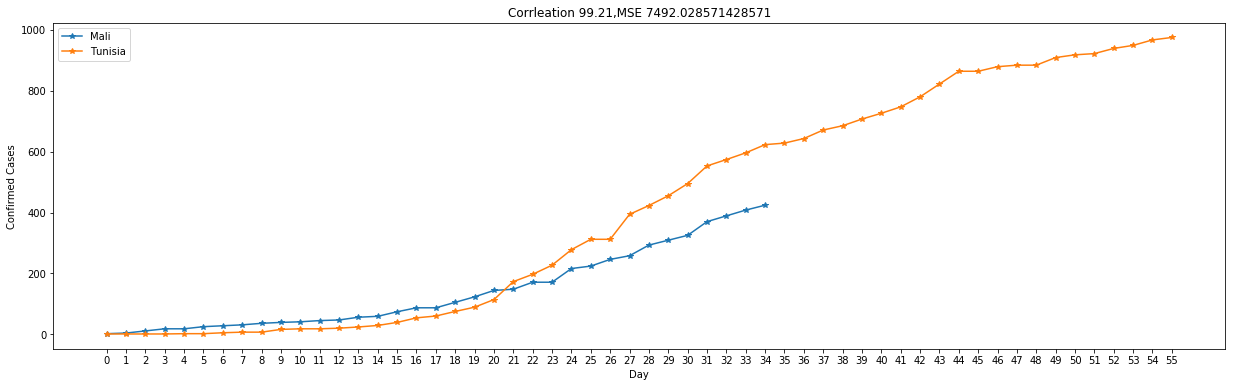

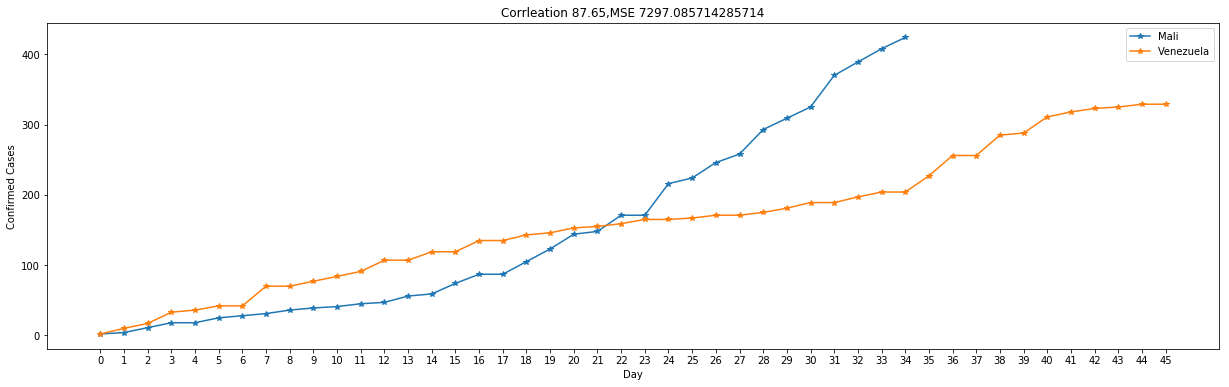

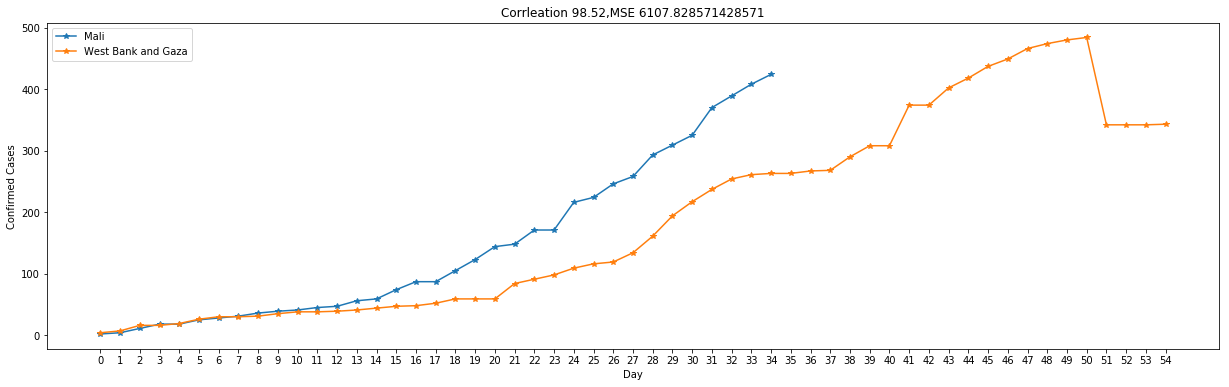

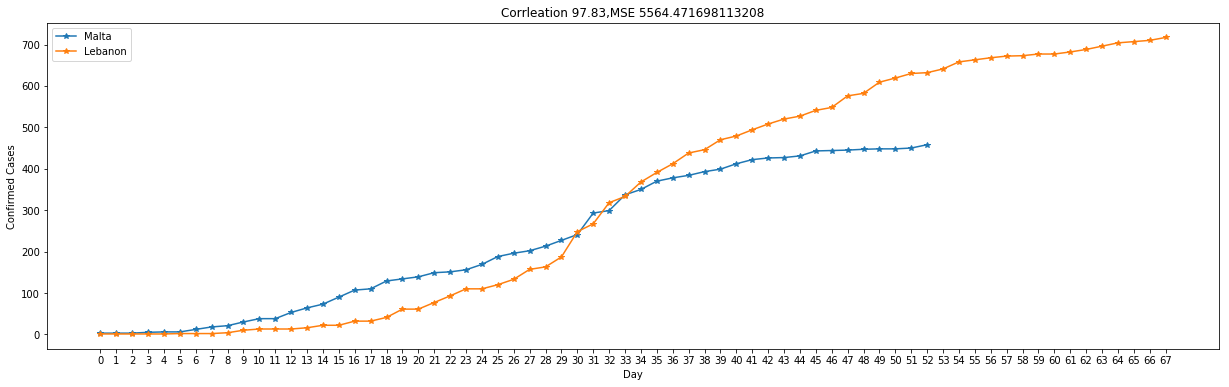

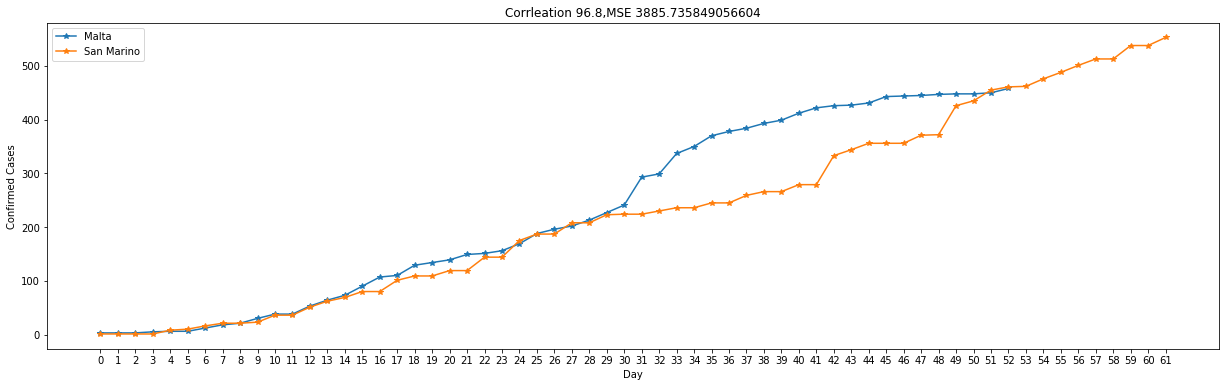

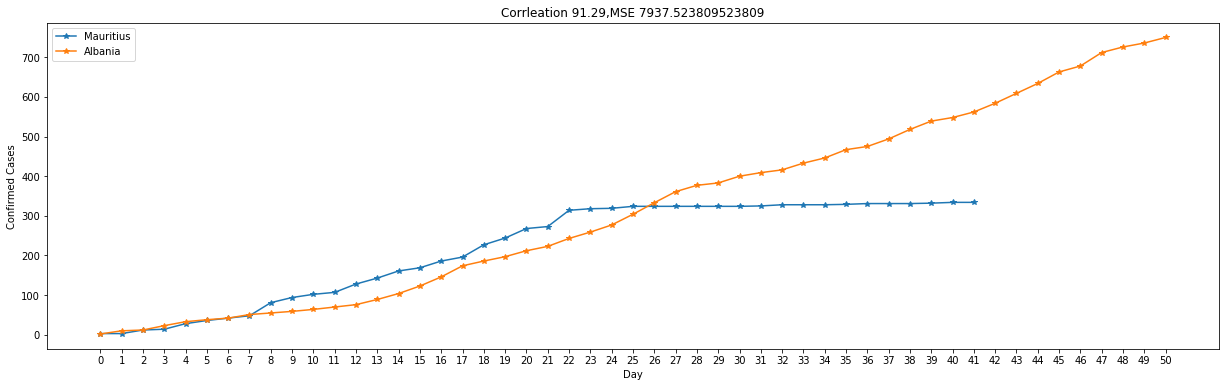

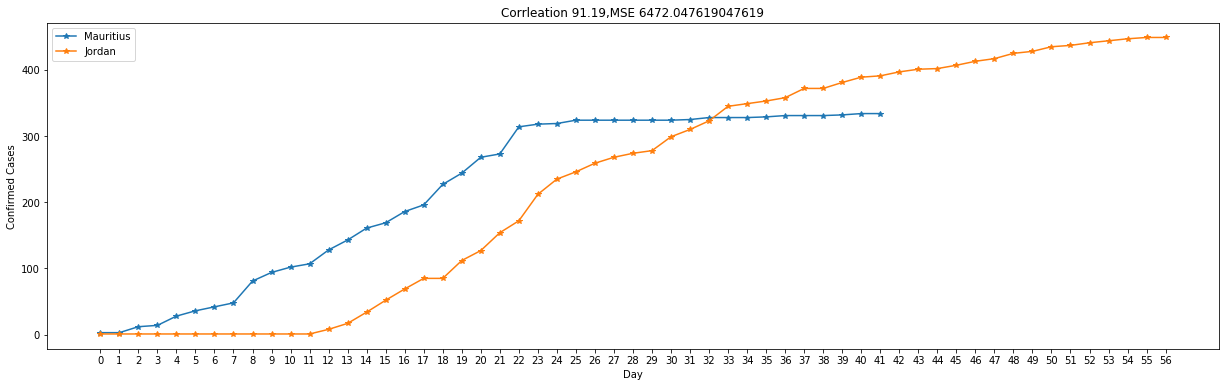

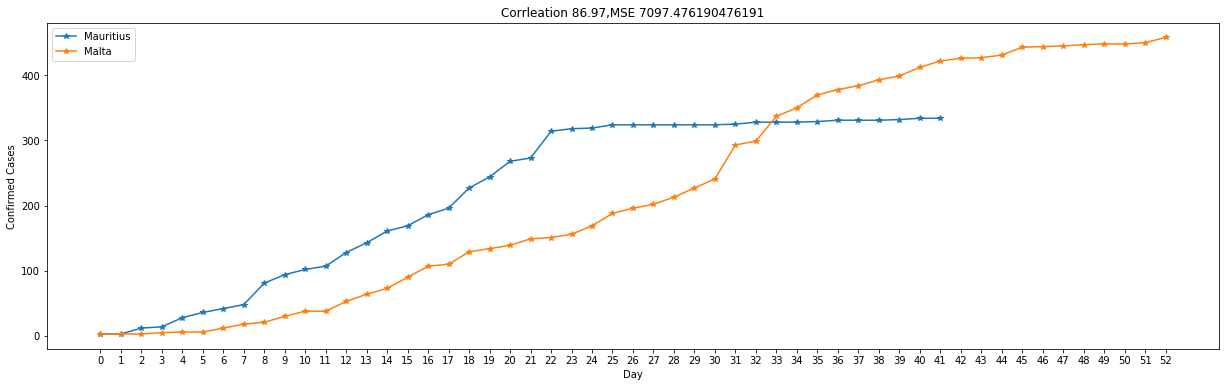

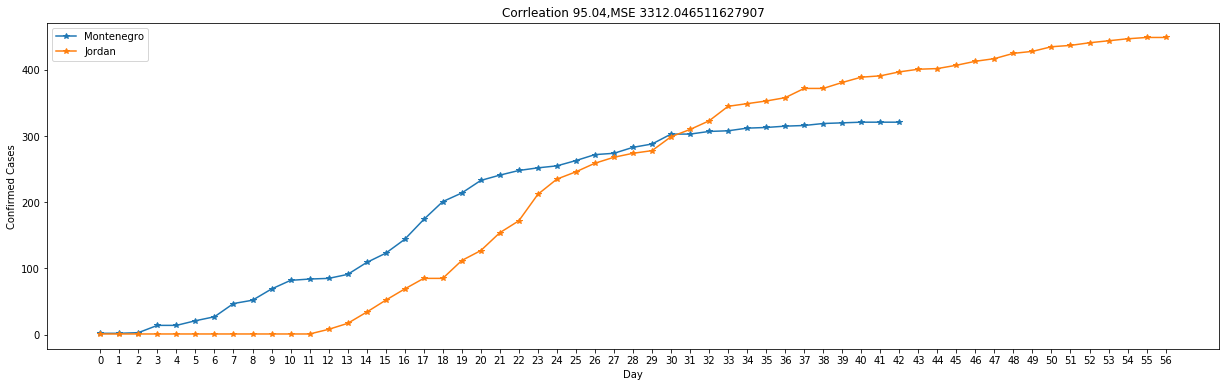

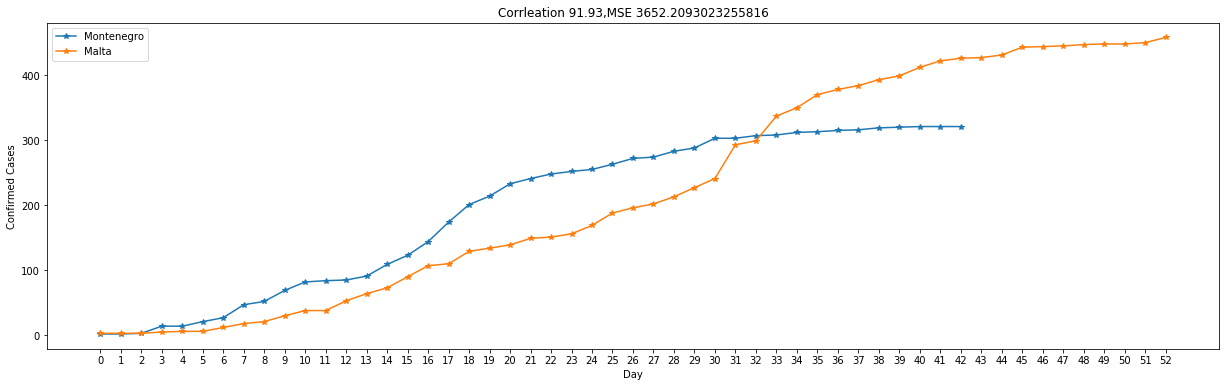

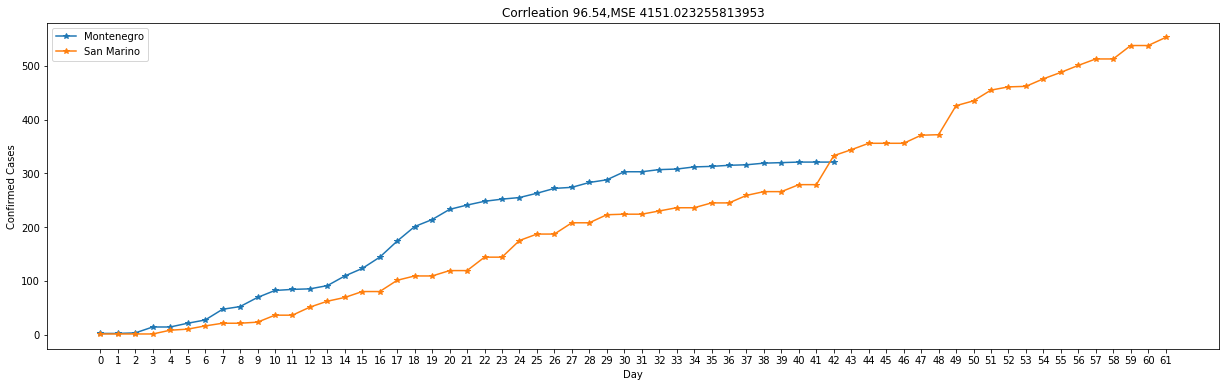

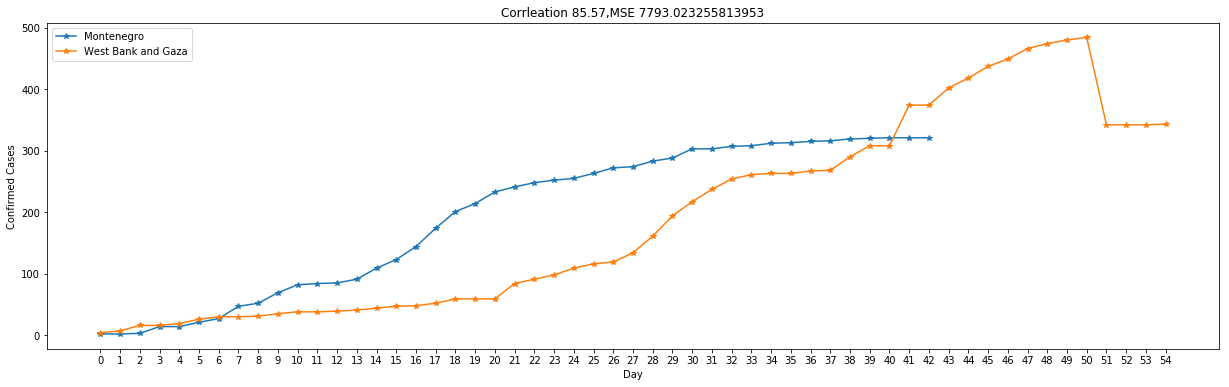

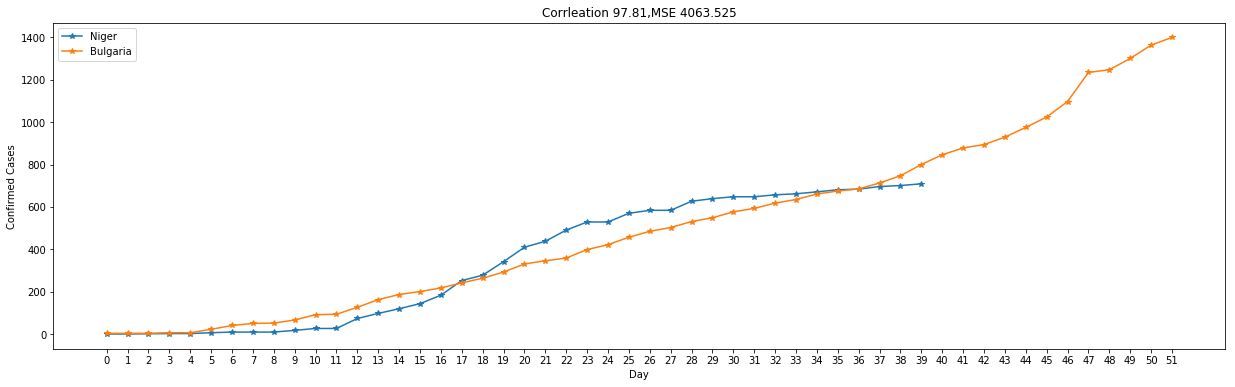

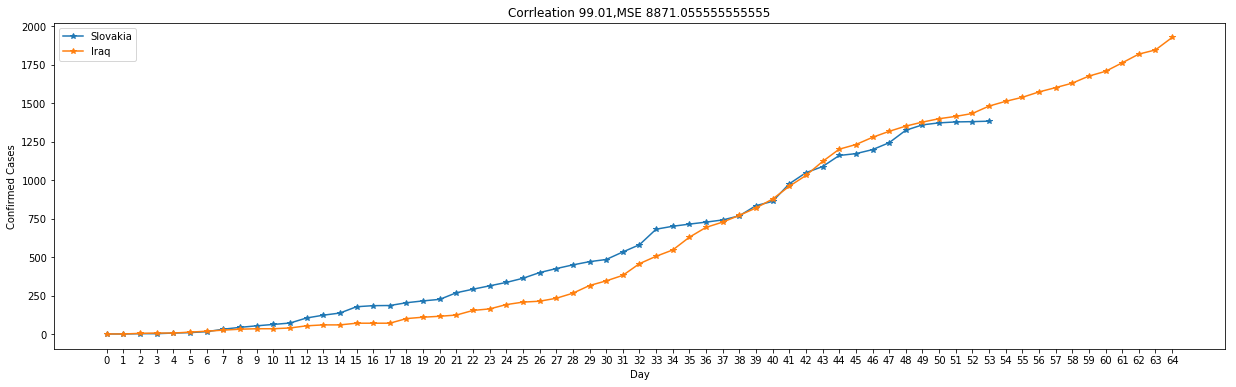

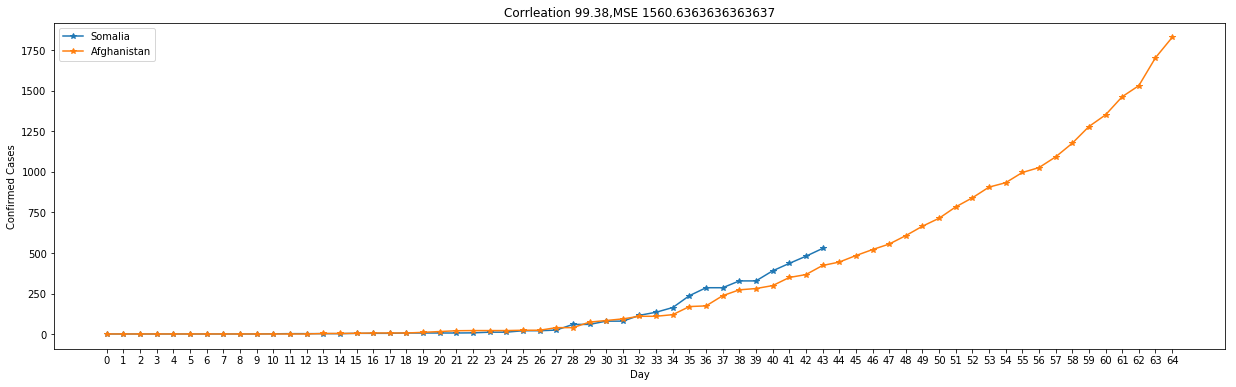

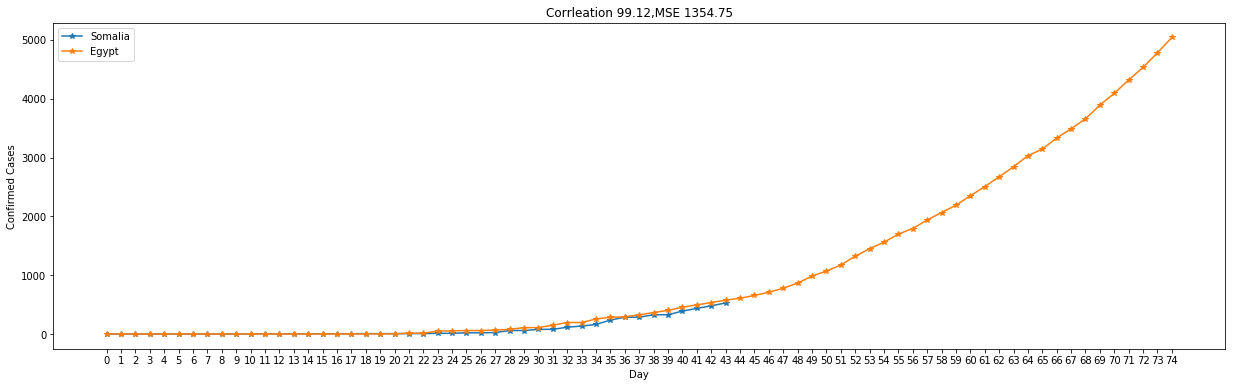

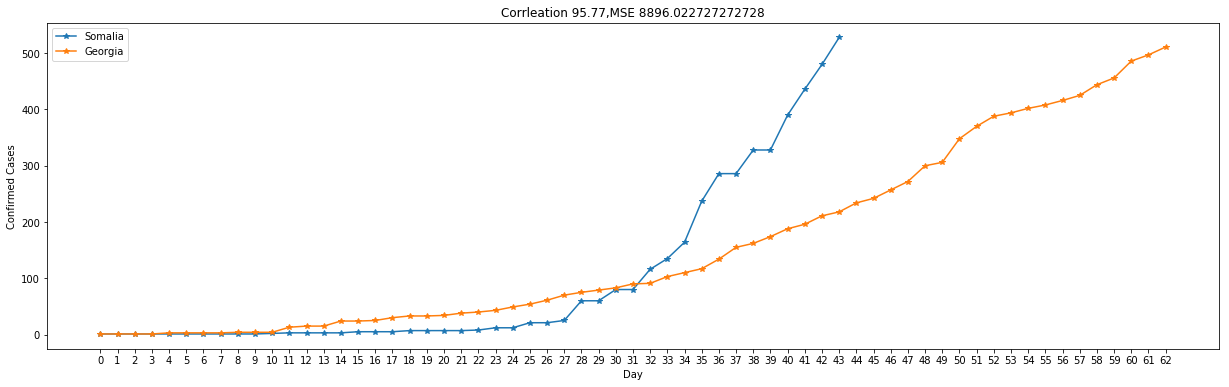

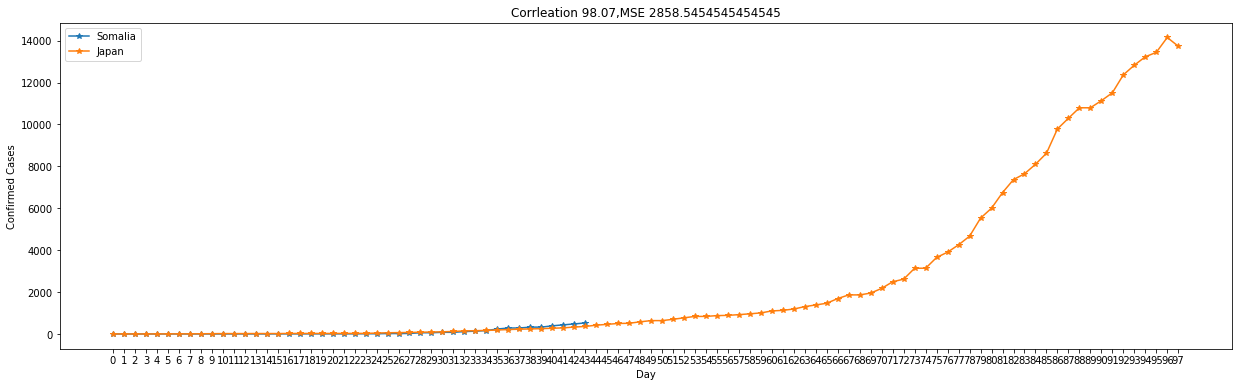

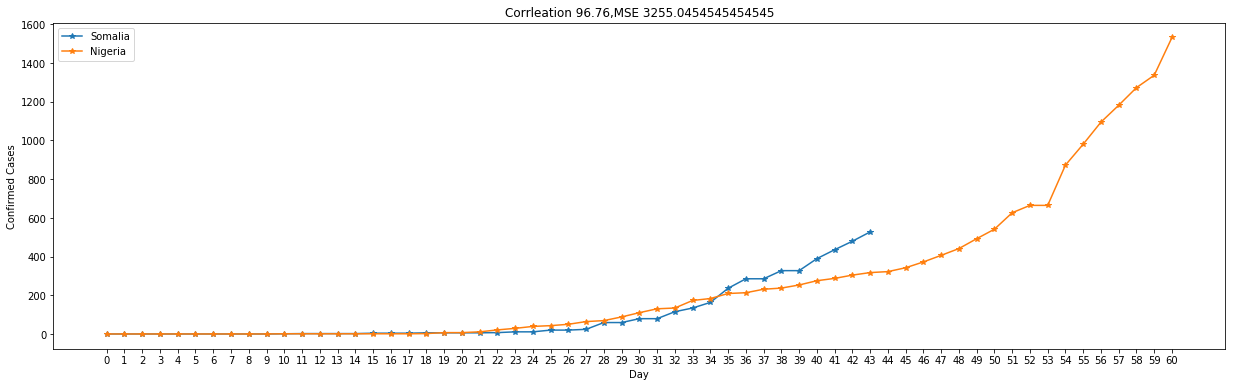

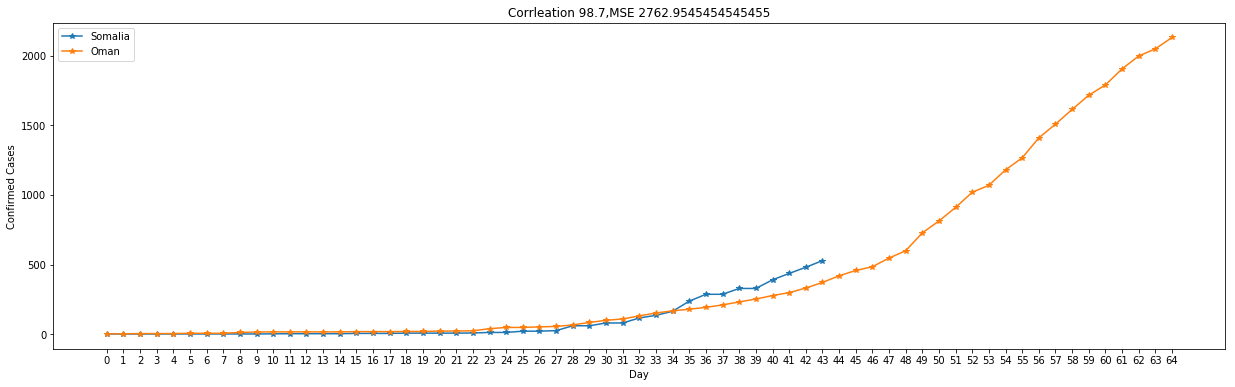

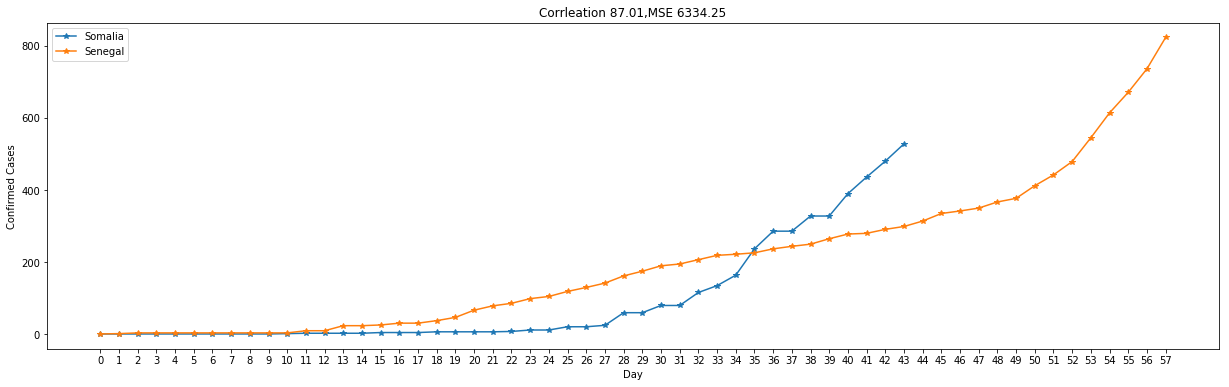

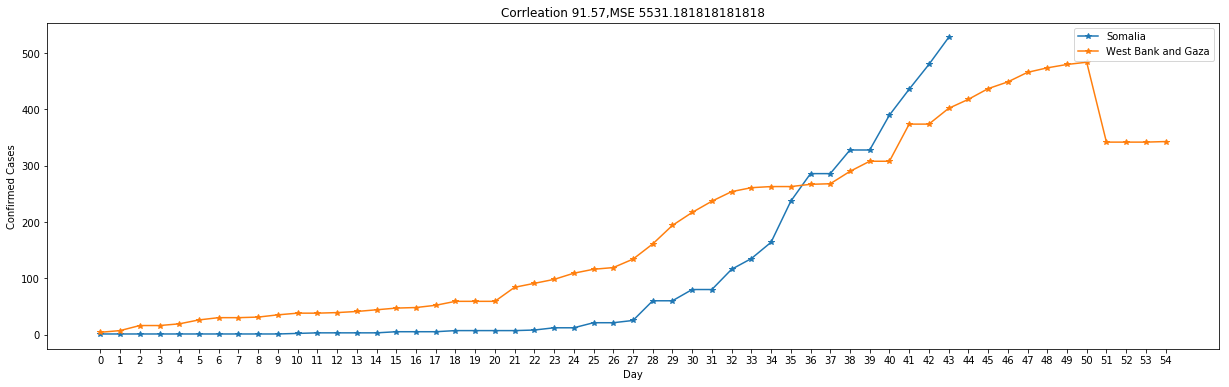

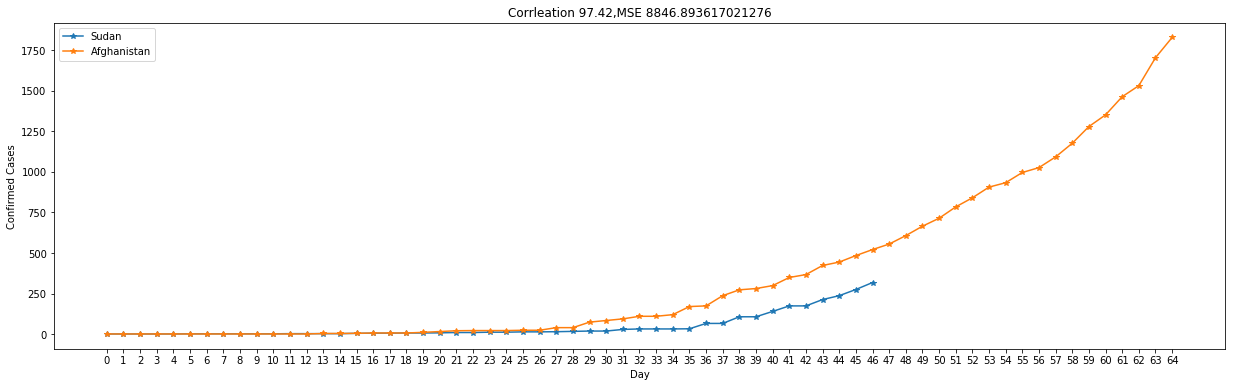

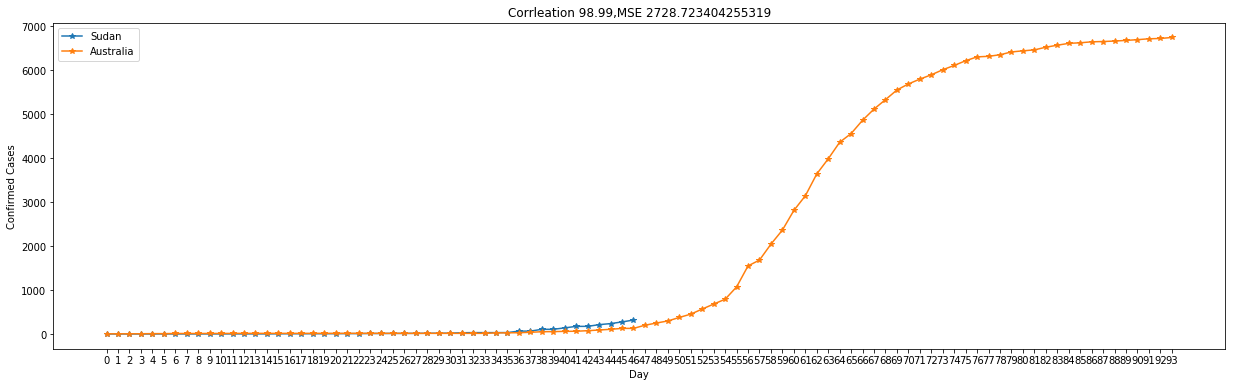

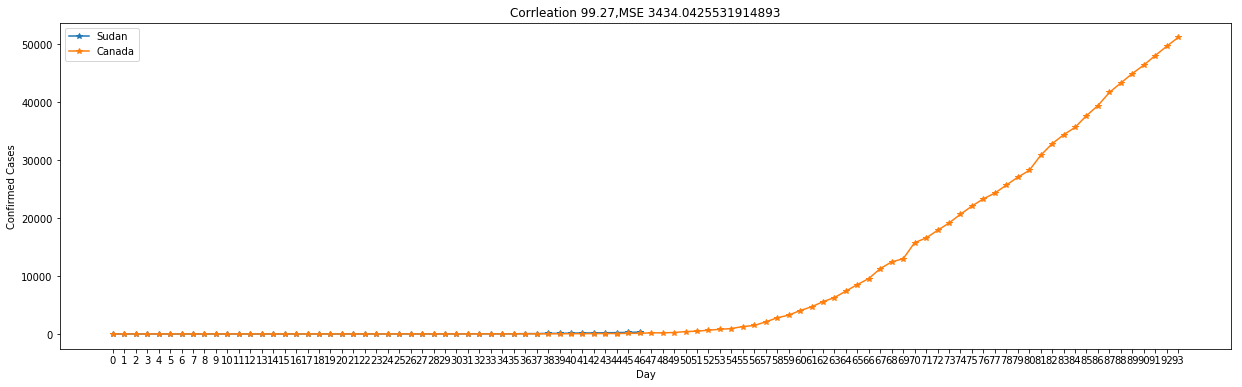

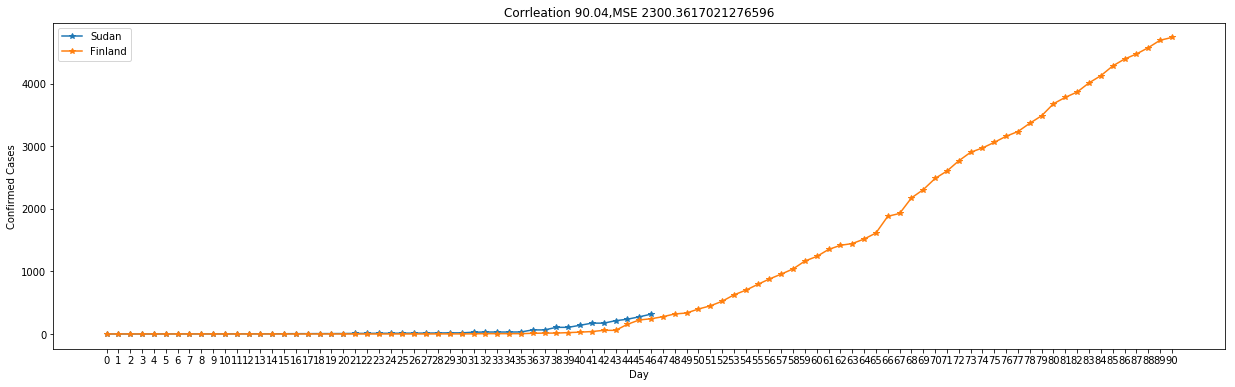

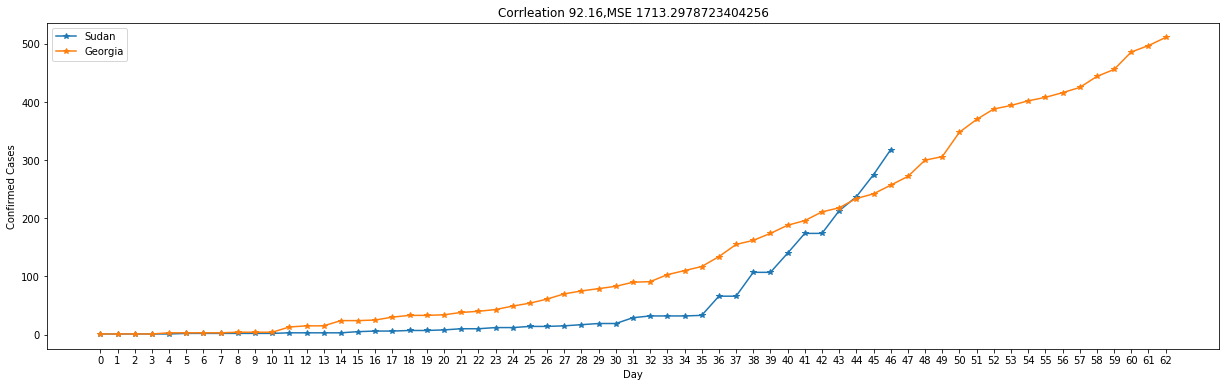

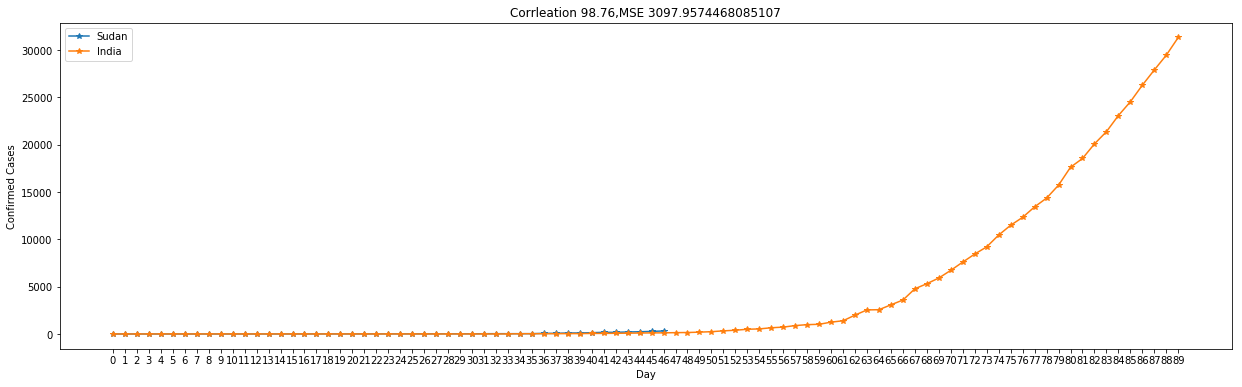

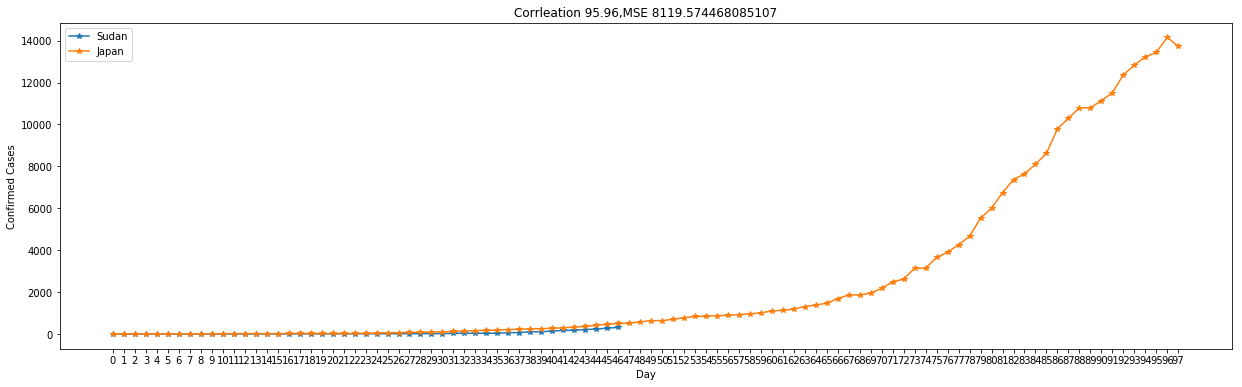

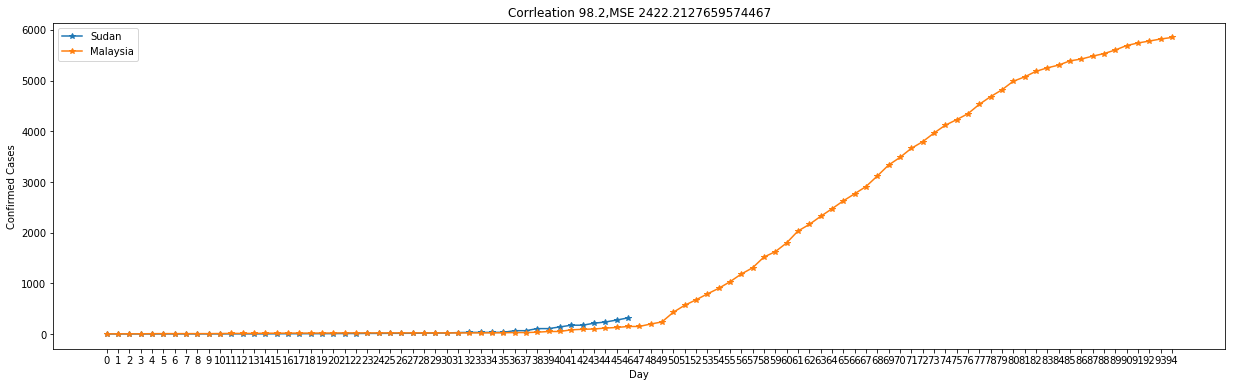

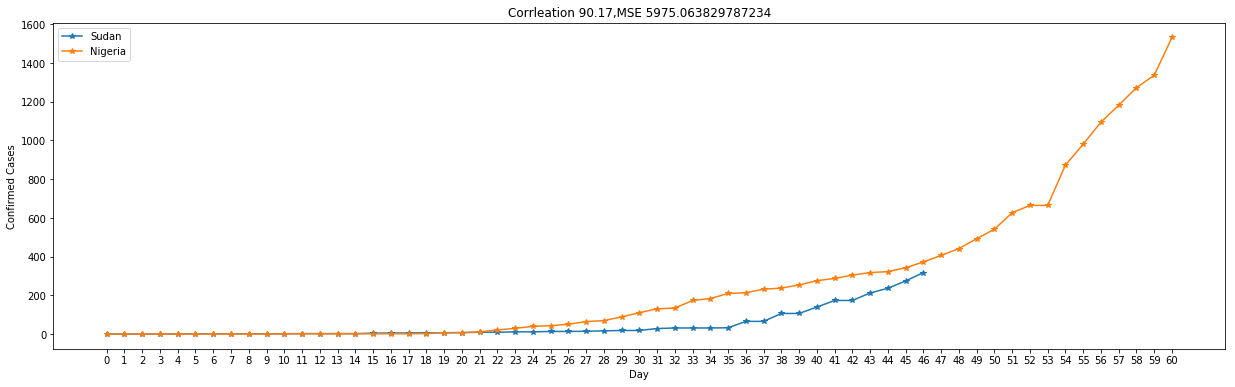

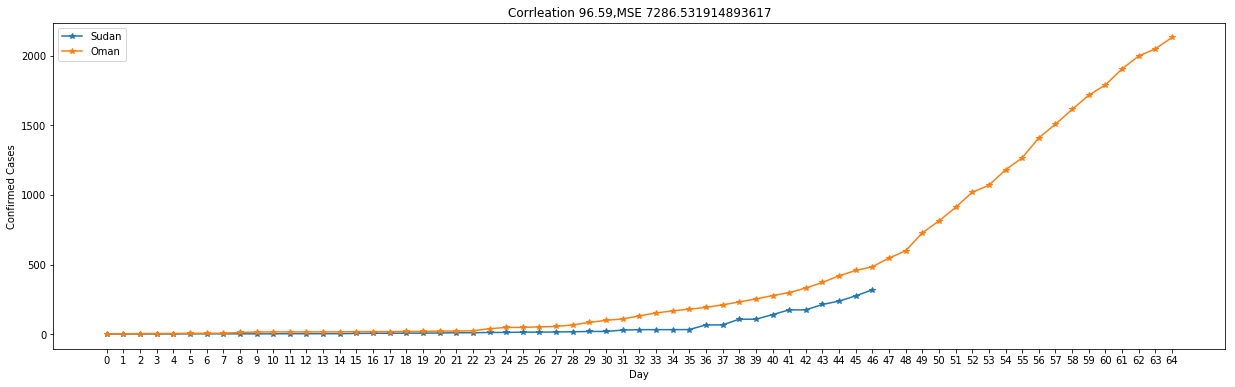

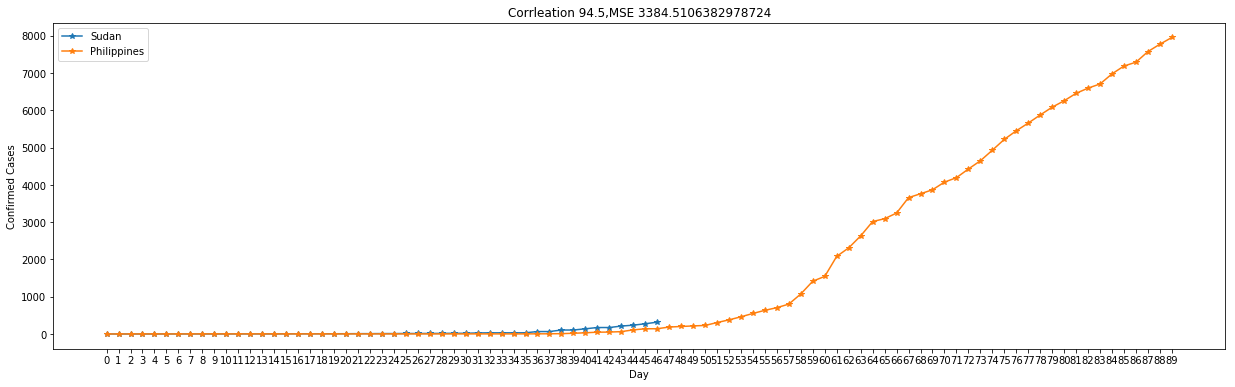

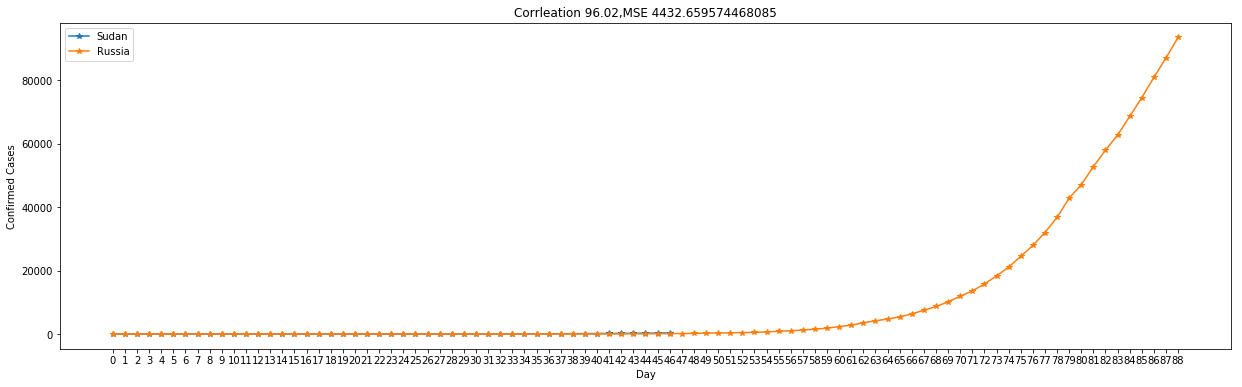

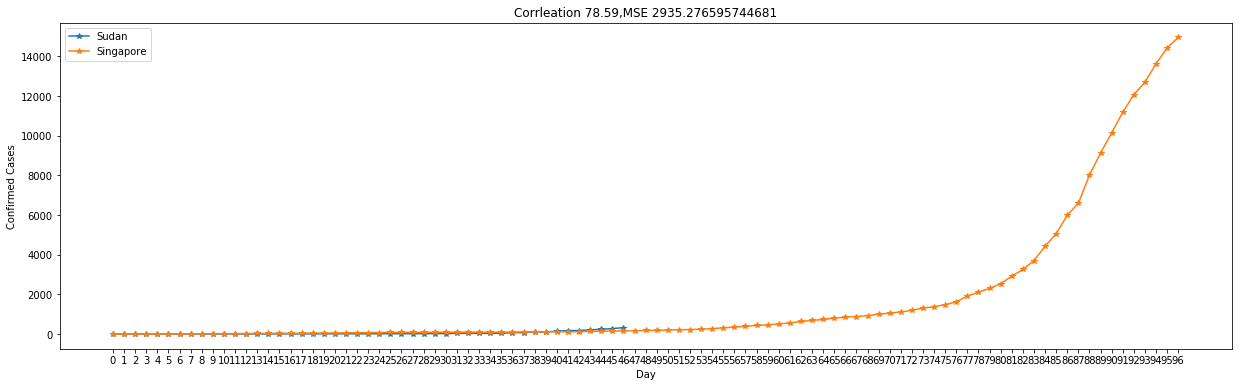

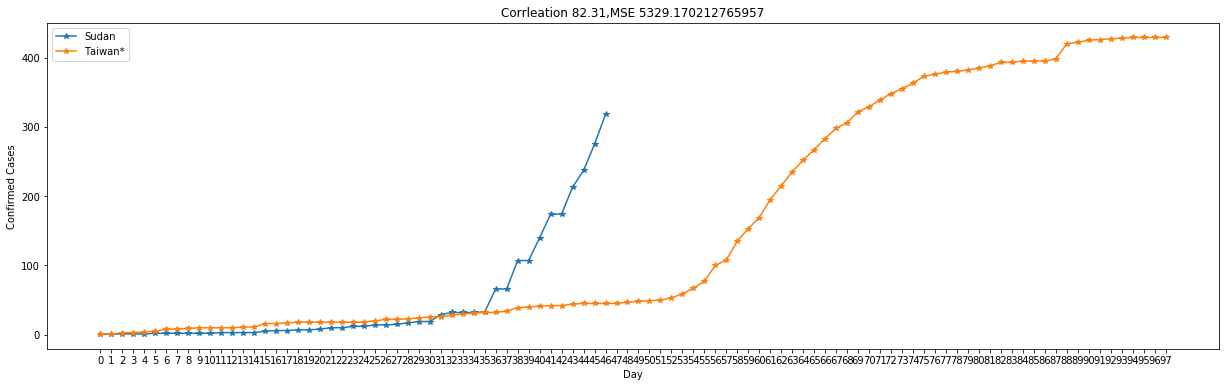

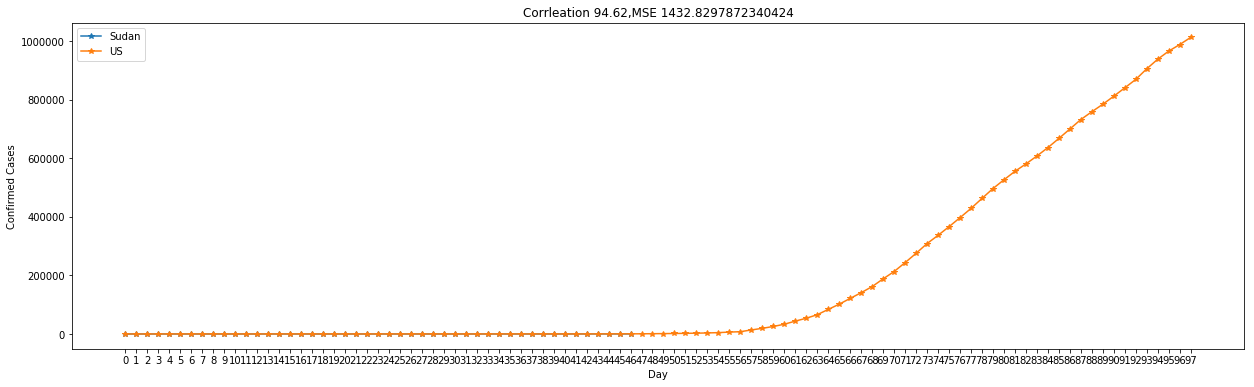

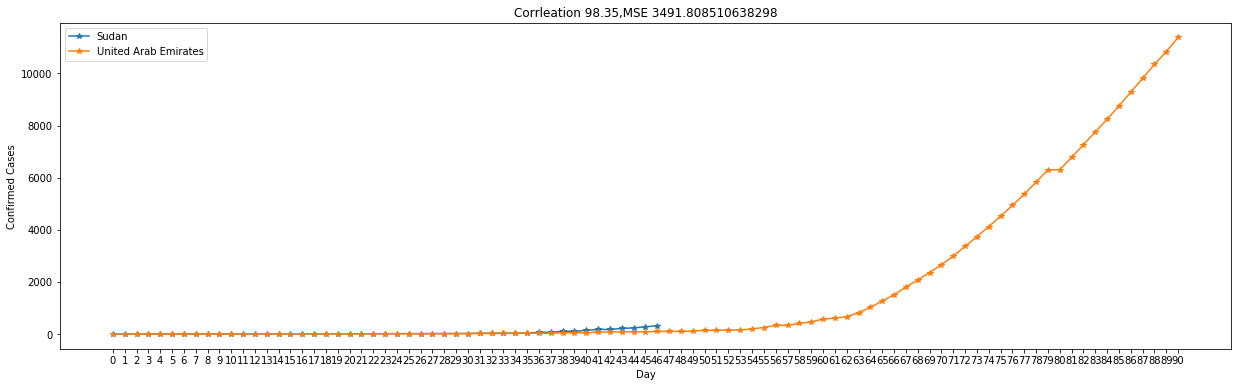

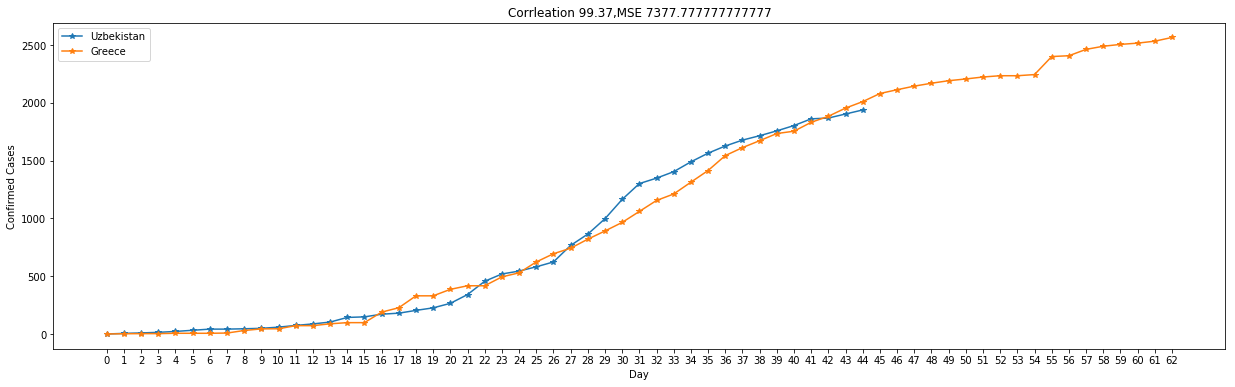

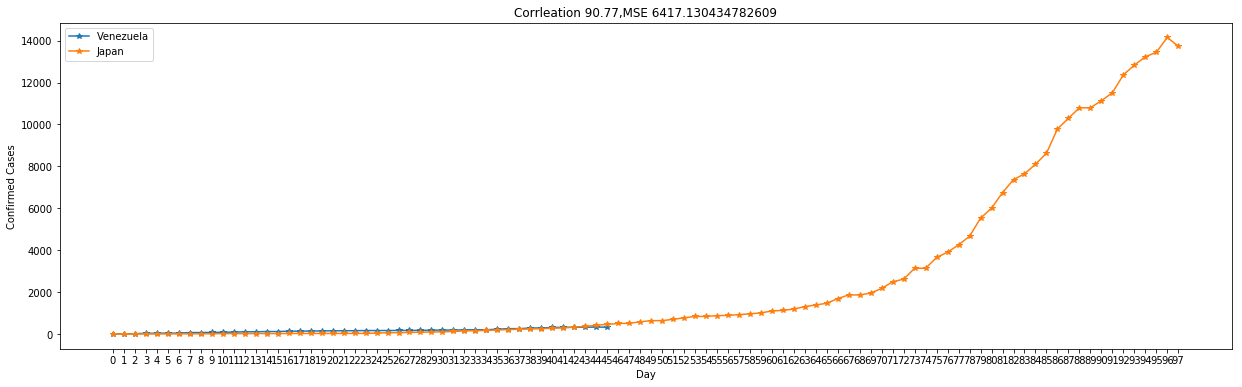

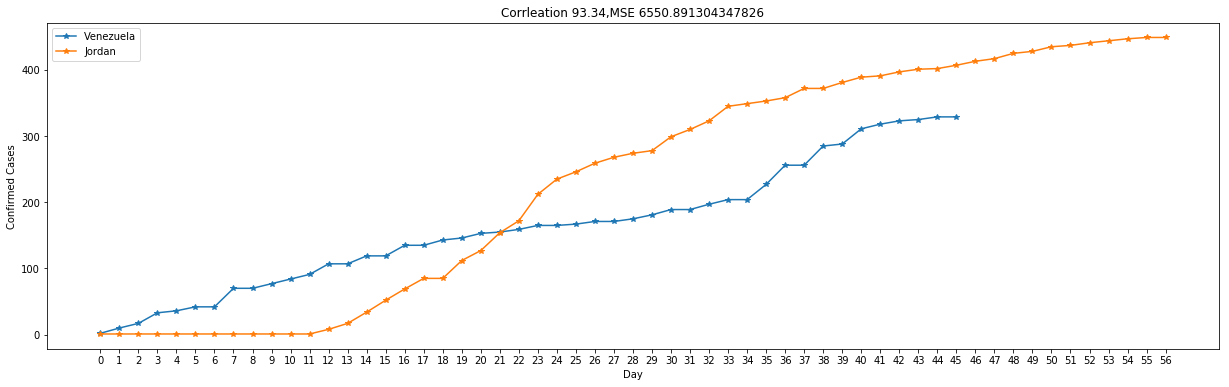

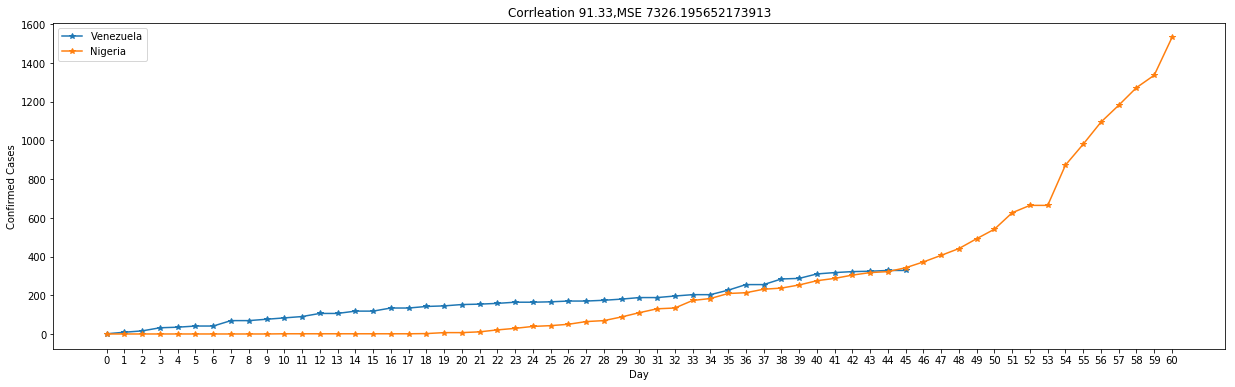

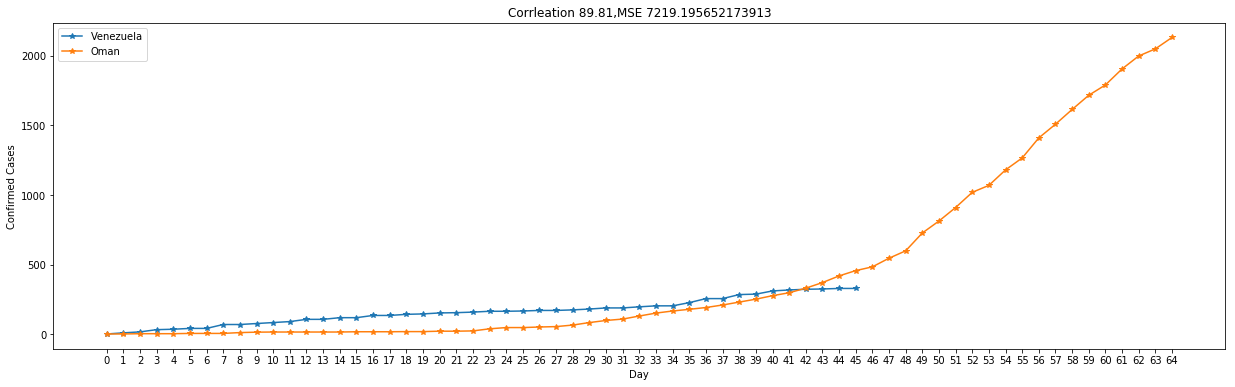

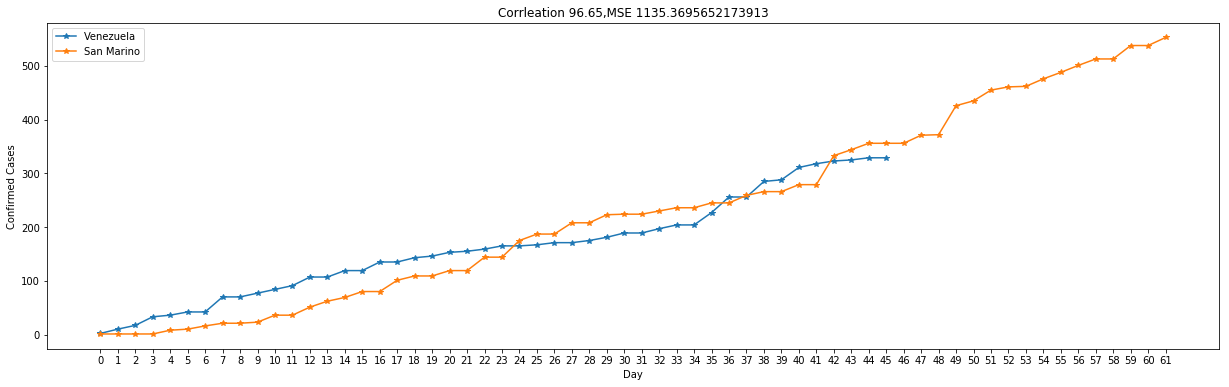

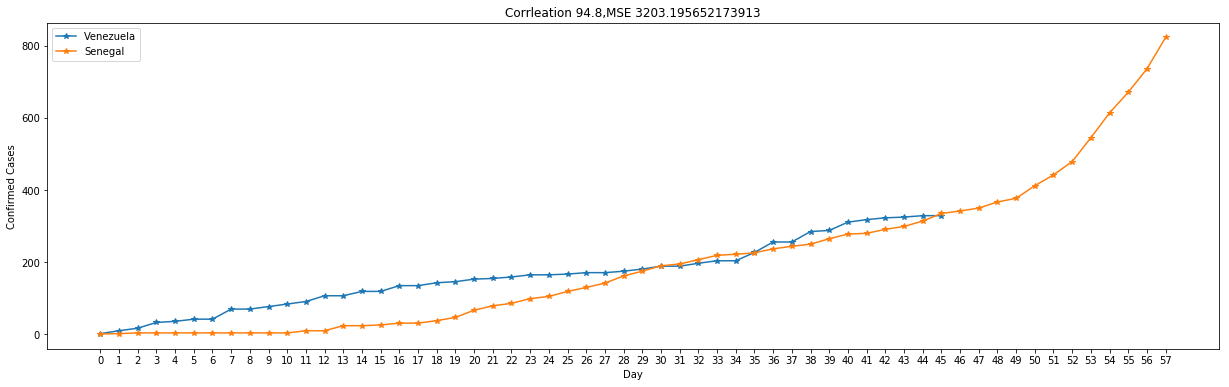

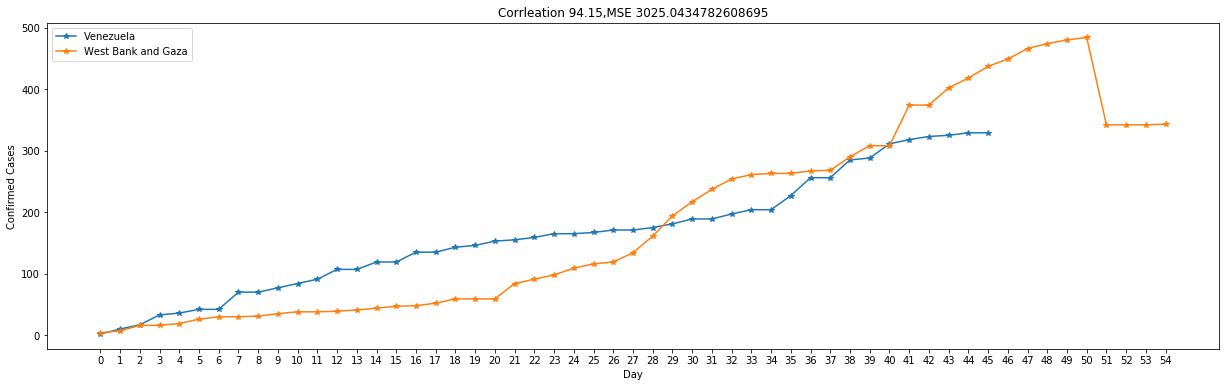

In [4]:
mse_list= []
best_pair = {}
for tt in all_data.columns:
    selected = []
    data = all_data[[tt]]
    data = data[data[tt]> 0].reset_index(drop=True)
    data_list1 = data.iloc[:,0].values
    for rj in all_data.columns:
        if rj != tt:
            data1 = all_data[[rj]]
            data1 = data1[data1[rj]> 0].reset_index(drop=True)
            data_list2 = data1.iloc[:,0].values
            if len(data_list1)<len(data_list2):
                corr = np.corrcoef(data_list1,data_list2[:len(data_list1)])[0,1]
                mse = (np.square(data_list1 - data_list2[:len(data_list1)])).mean()
                mse_list.append(mse)
                if ((mse <9000) & (corr>.7)):
                    if len(data1[rj])> len(data[tt])+7:
                        plt.figure(figsize=(21,6))
                        plt.plot([str(i) for i in data[tt].index],data[tt],marker='*',label=tt)
                        plt.plot([str(i) for i in data1[rj].index],data1[rj],marker='*',label=rj)
                        plt.title("Corrleation {},MSE {}".format(round(corr*100,2),mse))
                        plt.legend()
                        plt.xlabel('Day')
                        plt.ylabel('Confirmed Cases')
                        plt.show()
                        selected.append(data_list2[:len(data_list1)+7])
    if len(selected)>0:
        best_pair[tt]= selected

### Autoarima with exogenous variable

In [6]:
target_name = list(best_pair.keys())[0]
print(target_name)

Slovakia


### Target variable

In [7]:
data = all_data[[target_name]]
Y = data[data[target_name]> 0].reset_index(drop=True).iloc[:,0].values
print(Y)

[   1    1    3    3    7   10   16   32   44   54   63   72  105  123
  137  178  185  186  204  216  226  269  292  314  336  363  400  426
  450  471  485  534  581  682  701  715  728  742  769  835  863  977
 1049 1089 1161 1173 1199 1244 1325 1360 1373 1379 1381 1384]


### Features or exogenous variable

In [8]:
X = pd.DataFrame(np.vstack(best_pair[target_name]).T)
X_train = X.iloc[:len(Y),:].values
X.head()

0
0  1
1  1
2  5
3  7
4  7

### Model Fitting

Here I am using auto arima to predict cases for next 7 days

In [9]:
model =  auto_arima(Y,exogenous=X_train,
                    start_p=1, start_q=1,max_p=3, max_q=3, m=7 ,start_P=0, seasonal=True,
                    d=0, D=0, trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=496.042, BIC=507.976, Time=0.212 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=610.691, BIC=616.658, Time=0.043 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=494.909, BIC=504.854, Time=0.174 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=550.425, BIC=560.370, Time=0.291 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=648.090, BIC=652.068, Time=0.023 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=495.195, BIC=503.151, Time=0.041 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=496.331, BIC=508.265, Time=0.287 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=494.661, BIC=506.595, Time=0.177 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 0, 0)x(0, 0, 1,

### Generating Forecast

In [10]:
forecast = model.predict(7,exogenous =X.iloc[len(Y):,:].values)
y_forec, conf_int  = model.predict(7,exogenous =X.iloc[len(Y):,:].values,return_conf_int=True,alpha=0.05)
print('forecast',y_forec, 'confidence intervel',conf_int)

forecast [1414.30619579 1445.27961048 1475.10157591 1497.93469741 1518.98569158
 1553.66293824 1570.42098148] confidence intervel [[1373.42789178 1455.1844998 ]
 [1389.01188887 1501.54733208]
 [1407.99269104 1542.21046079]
 [1422.43462577 1573.43476904]
 [1436.70038458 1601.27099857]
 [1465.74984387 1641.5760326 ]
 [1477.76214219 1663.07982077]]


### Actual vs forecast DataFrame

In [11]:
Actual_df =pd.DataFrame(Y,columns=['Actuals'])
for i in ['forecast','Ci_low','Ci_high']:
    Actual_df[i] = np.nan
forecast_df= pd.DataFrame(conf_int,columns = ['Ci_low','Ci_high'])
forecast_df['forecast'] =y_forec
forecast_df = Actual_df.append(forecast_df).reset_index(drop=True)
forecast_df.tail(10)

Actuals      Ci_high       Ci_low     forecast
51   1379.0          NaN          NaN          NaN
52   1381.0          NaN          NaN          NaN
53   1384.0          NaN          NaN          NaN
54      NaN  1455.184500  1373.427892  1414.306196
55      NaN  1501.547332  1389.011889  1445.279610
56      NaN  1542.210461  1407.992691  1475.101576
57      NaN  1573.434769  1422.434626  1497.934697
58      NaN  1601.270999  1436.700385  1518.985692
59      NaN  1641.576033  1465.749844  1553.662938
60      NaN  1663.079821  1477.762142  1570.420981

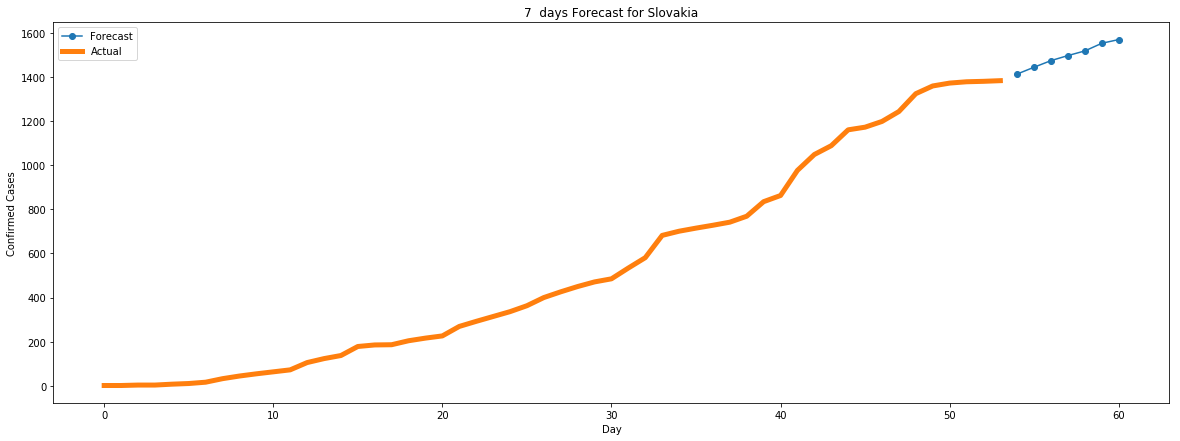

In [12]:
plt.figure(figsize=(20,7))
plt.plot(forecast_df.index,forecast_df.forecast,'-o')
plt.plot(forecast_df.index,forecast_df.Actuals,linewidth=5)
plt.legend(['Forecast','Actual'])
plt.title('7  days Forecast for {}'.format(target_name))
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.show()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=496.042, BIC=507.976, Time=0.193 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=610.691, BIC=616.658, Time=0.049 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=494.909, BIC=504.854, Time=0.185 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=550.425, BIC=560.370, Time=0.268 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=648.090, BIC=652.068, Time=0.023 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=495.195, BIC=503.151, Time=0.042 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=496.331, BIC=508.265, Time=0.285 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=494.661, BIC=506.595, Time=0.171 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 0, 0)x(0, 0, 1,

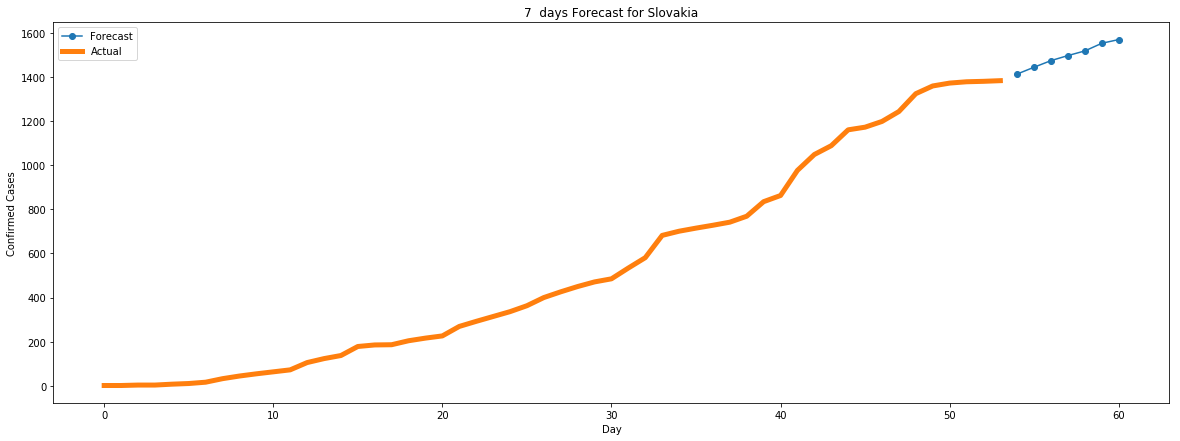

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=460.046, BIC=470.886, Time=0.282 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=526.160, BIC=531.580, Time=0.026 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=466.346, BIC=475.379, Time=0.173 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=489.672, BIC=498.705, Time=0.201 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=524.269, BIC=527.882, Time=0.052 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=460.100, BIC=469.133, Time=0.126 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=462.666, BIC=475.313, Time=0.332 seconds
Near non-invertible roots for order (1, 0, 1)(1, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 0, 1)x(0, 0, 2, 7) (constant=True); AIC=462.372, BIC=475.019, Time=0.379 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0,

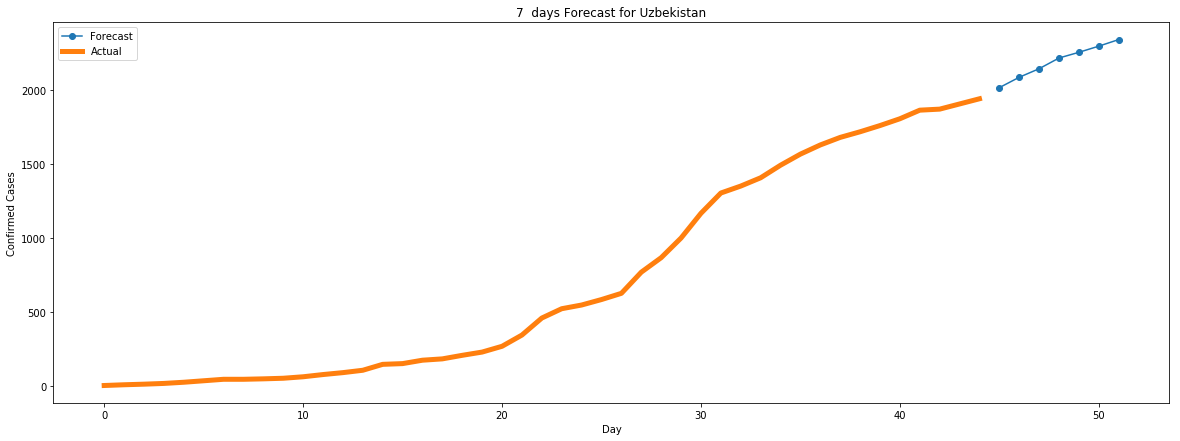

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=220.173, BIC=269.944, Time=1.233 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=208.958, BIC=254.064, Time=0.486 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=211.082, BIC=259.298, Time=1.125 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=210.426, BIC=258.642, Time=1.205 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=208.563, BIC=252.112, Time=0.421 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=210.961, BIC=257.621, Time=0.876 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=212.853, BIC=259.513, Time=1.030 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=213.011, BIC=261.227, Time=1.195 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=208.816, BIC=255.476, Time=0.486 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=209.278, BIC=255.939, Time=0.669 seco

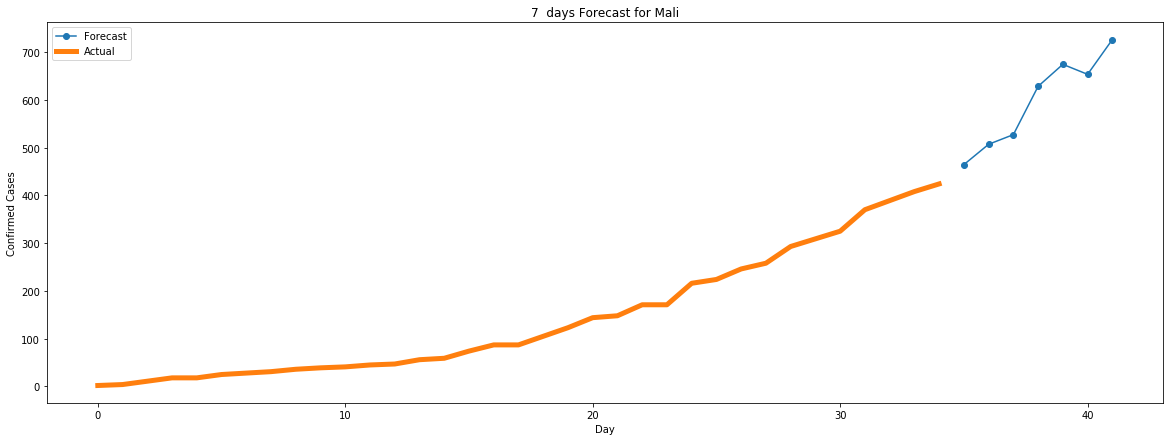

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=423.668, BIC=436.911, Time=0.322 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=464.767, BIC=472.334, Time=0.046 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=425.871, BIC=437.221, Time=0.203 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=430.026, BIC=441.377, Time=0.257 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=480.717, BIC=486.392, Time=0.038 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=422.683, BIC=434.034, Time=0.149 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=423.050, BIC=436.293, Time=0.304 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=424.214, BIC=439.349, Time=0.390 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=428.863, BIC=438.322, Time=0.200 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=423.889, BIC=433.348, Time=0.078 seco

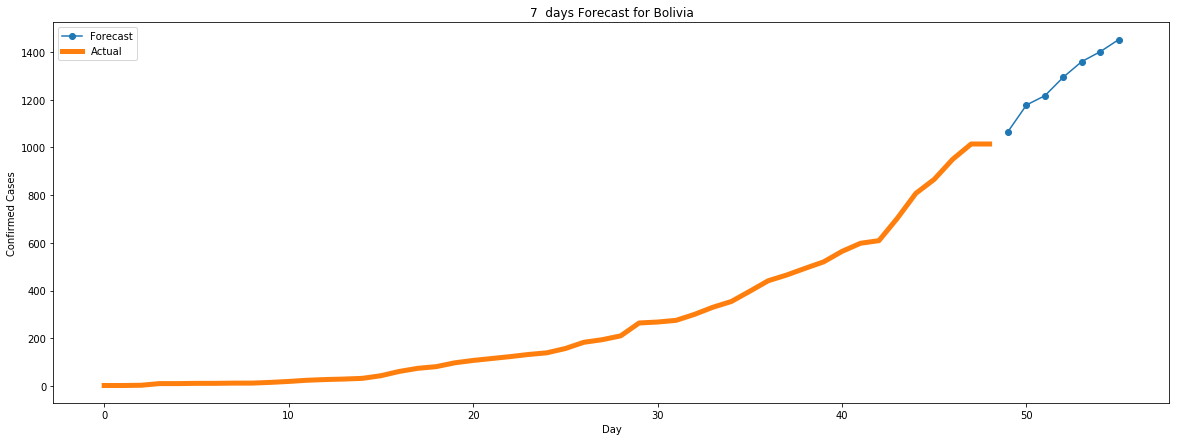

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=322.480, BIC=333.164, Time=0.295 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=357.348, BIC=363.453, Time=0.042 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=320.533, BIC=329.691, Time=0.193 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=331.907, BIC=341.065, Time=0.278 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=365.221, BIC=369.800, Time=0.039 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=319.000, BIC=326.632, Time=0.063 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=320.483, BIC=329.641, Time=0.215 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=322.951, BIC=333.635, Time=0.392 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=320.991, BIC=330.149, Time=0.136 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=320.993, BIC=330.151, Time=0.154 seco

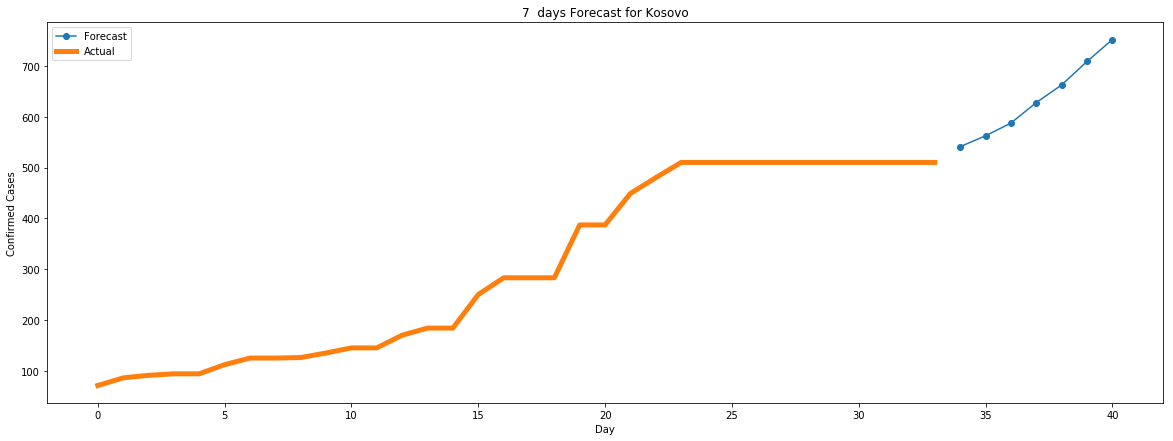

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=393.115, BIC=406.499, Time=0.392 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=488.735, BIC=496.383, Time=0.039 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=391.853, BIC=403.325, Time=0.309 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=444.139, BIC=455.611, Time=0.277 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=503.732, BIC=509.468, Time=0.046 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=393.129, BIC=402.689, Time=0.110 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=393.191, BIC=406.575, Time=0.477 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=392.794, BIC=406.178, Time=0.393 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1,

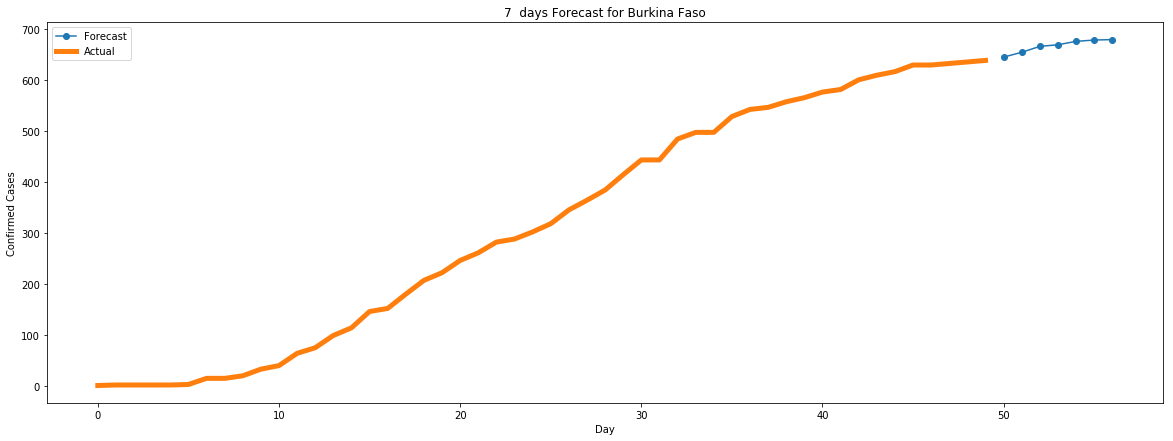

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=322.526, BIC=338.376, Time=0.375 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=393.676, BIC=404.244, Time=0.131 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=326.294, BIC=340.383, Time=0.343 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=394.357, BIC=408.447, Time=0.372 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=412.216, BIC=421.022, Time=0.069 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=320.735, BIC=334.825, Time=0.228 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=322.546, BIC=338.397, Time=0.383 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=324.263, BIC=341.875, Time=0.471 seconds
Near non-invertible roots for order (1, 0, 1)(1, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (0, 0, 1)x(0, 0, 0,

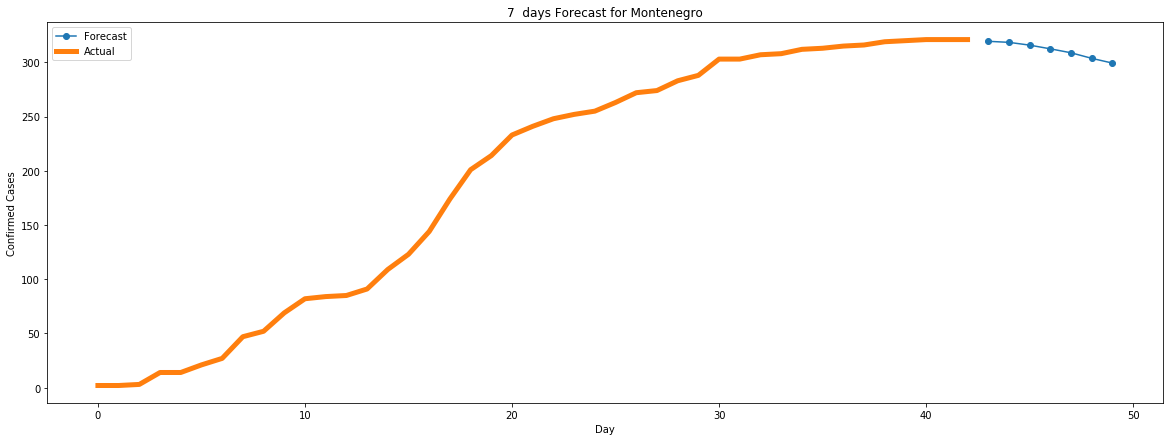

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=353.388, BIC=376.582, Time=0.553 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=347.890, BIC=365.732, Time=0.172 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=351.164, BIC=372.574, Time=0.450 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=351.406, BIC=372.816, Time=0.494 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=346.389, BIC=362.447, Time=0.183 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=349.170, BIC=368.796, Time=0.411 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=349.367, BIC=368.993, Time=0.431 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=350.679, BIC=372.090, Time=0.510 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=349.816, BIC=369.443, Time=0.210 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=349.806, BIC=369.432, Time=0.297 seco

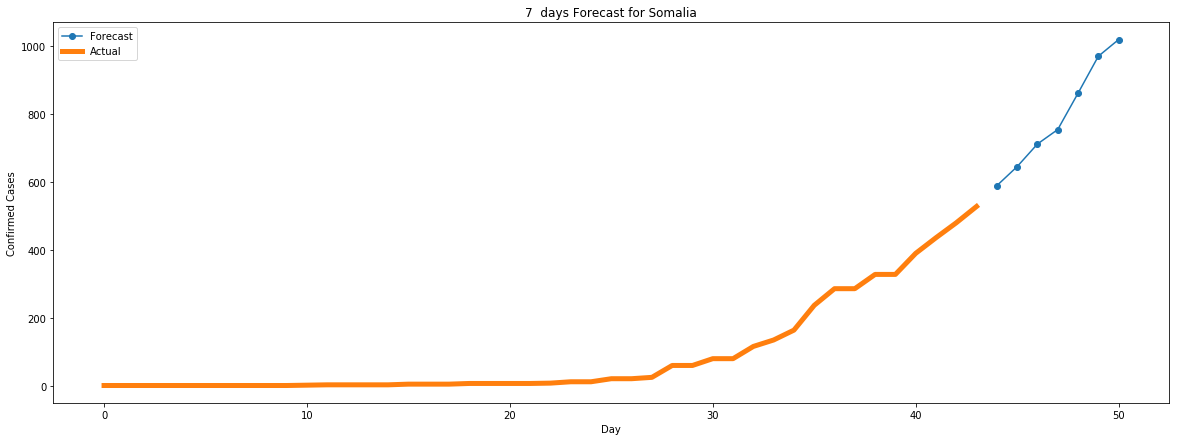

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=219.753, BIC=260.878, Time=0.928 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=213.740, BIC=249.725, Time=0.301 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=217.290, BIC=256.702, Time=0.867 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=217.789, BIC=257.201, Time=0.874 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=212.529, BIC=246.800, Time=0.339 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=215.647, BIC=253.346, Time=1.067 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=215.857, BIC=253.556, Time=0.755 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=217.713, BIC=257.125, Time=0.937 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=215.370, BIC=253.069, Time=0.359 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=215.271, BIC=252.970, Time=0.538 seco

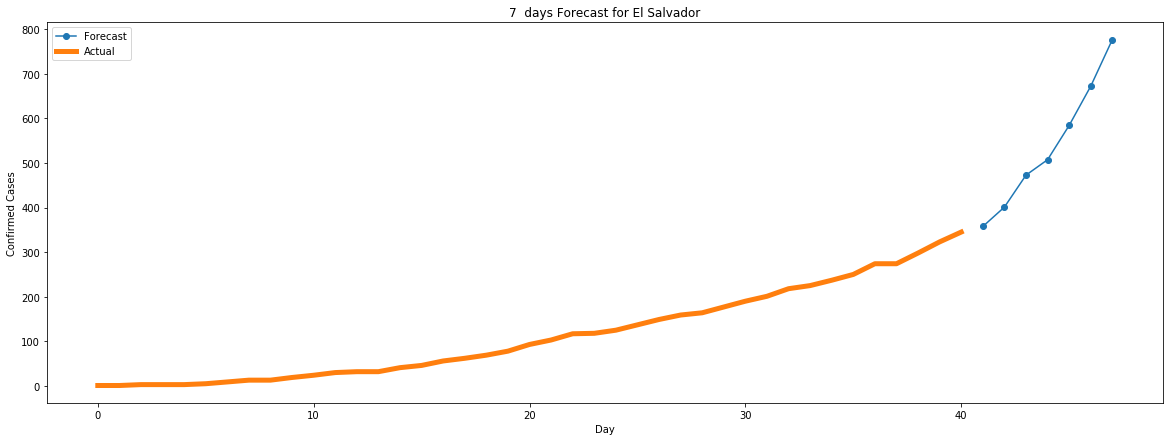

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=323.348, BIC=363.094, Time=0.870 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=331.302, BIC=365.628, Time=0.307 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=331.210, BIC=369.150, Time=0.841 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=320.907, BIC=358.847, Time=0.863 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=329.955, BIC=362.475, Time=0.277 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=321.572, BIC=357.705, Time=0.488 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=328.508, BIC=368.255, Time=0.909 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 2, 7) (constant=True); AIC=326.429, BIC=366.176, Time=1.055 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=323.969, BIC=361.909, Time=0.783 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 2, 7) (constant=True); AIC=329.290, BIC=370.843, Time=1.236 seco

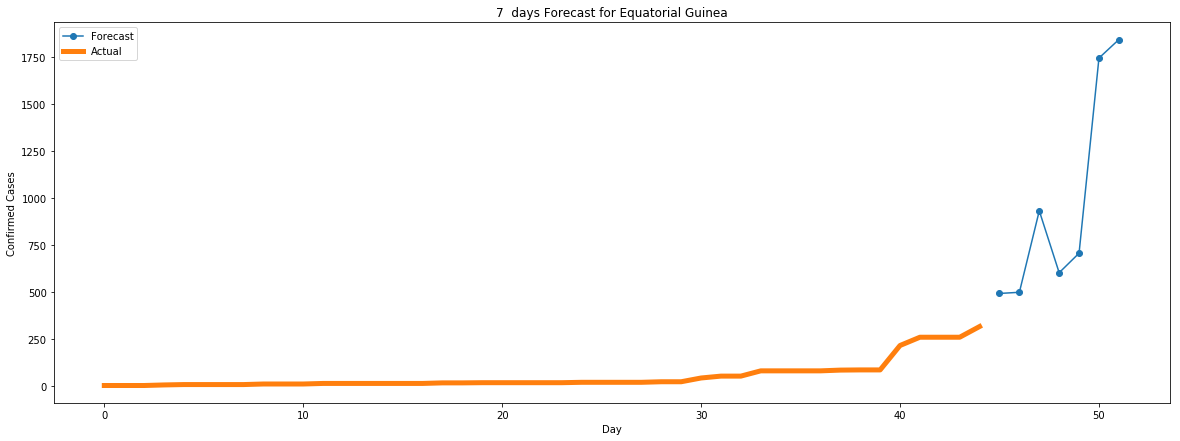

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=435.776, BIC=448.727, Time=0.323 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=467.413, BIC=474.814, Time=0.046 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=432.770, BIC=443.871, Time=0.268 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=435.390, BIC=446.491, Time=0.188 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=474.439, BIC=479.989, Time=0.035 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=444.885, BIC=454.136, Time=0.091 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=432.863, BIC=445.814, Time=0.490 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=433.277, BIC=446.228, Time=0.323 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=436.258, BIC=447.359, Time=0.202 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 1, 7) (constant=True); AIC=434.835, BIC=449.636, Time=0.566 seco

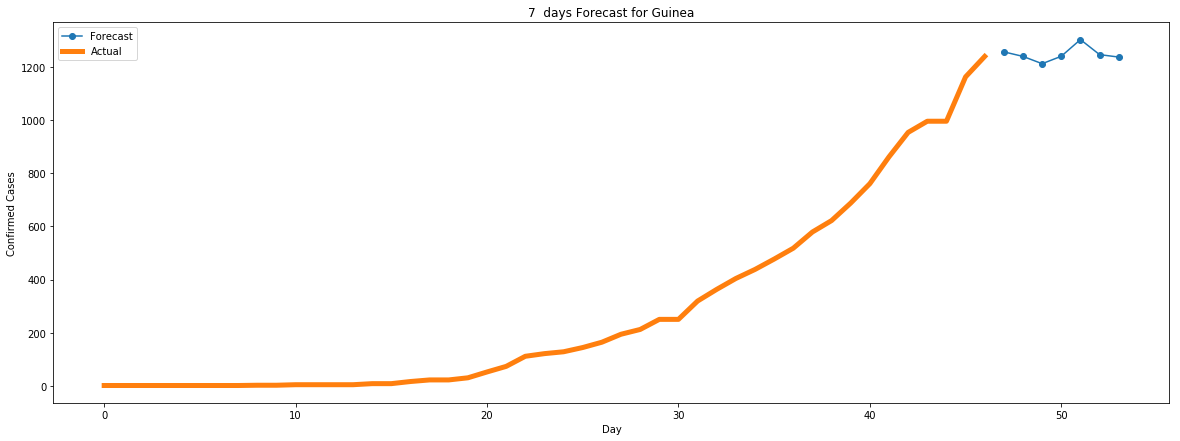

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=423.556, BIC=440.583, Time=0.437 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=487.185, BIC=498.536, Time=0.103 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=422.732, BIC=437.867, Time=0.331 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=448.003, BIC=463.137, Time=0.388 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=487.320, BIC=496.779, Time=0.099 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=421.197, BIC=434.440, Time=0.089 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=422.404, BIC=437.539, Time=0.305 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=424.244, BIC=441.271, Time=0.418 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=422.289, BIC=437.424, Time=0.229 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=422.534, BIC=437.669, Time=0.091 seco

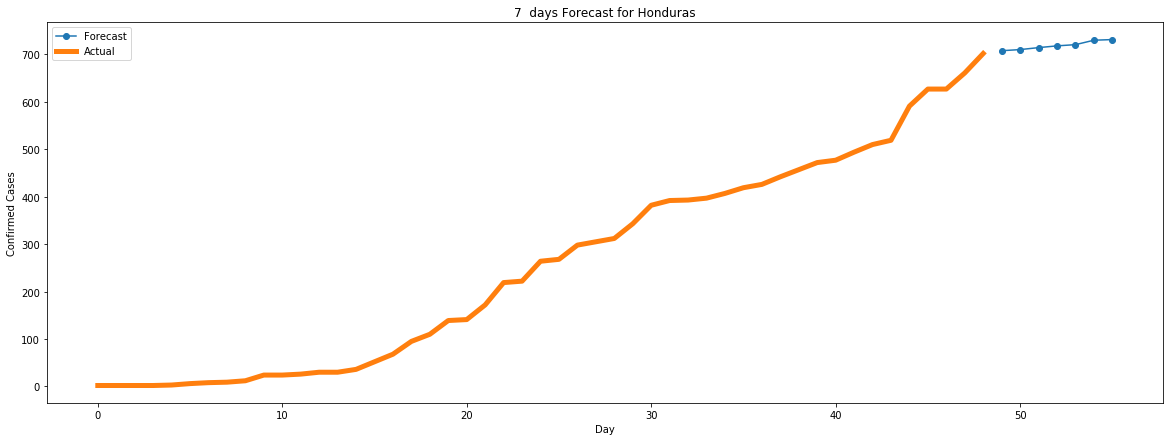

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=293.524, BIC=321.276, Time=0.647 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=336.930, BIC=359.132, Time=0.199 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=305.829, BIC=331.731, Time=0.586 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=306.173, BIC=332.075, Time=0.568 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=337.380, BIC=357.731, Time=0.181 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=293.572, BIC=319.474, Time=0.414 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=296.513, BIC=326.115, Time=0.761 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 2, 7) (constant=True); AIC=294.613, BIC=324.216, Time=0.855 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=292.016, BIC=319.768, Time=0.648 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 0, 7) (constant=True); AIC=294.116, BIC=323.718, Time=0.974 seco

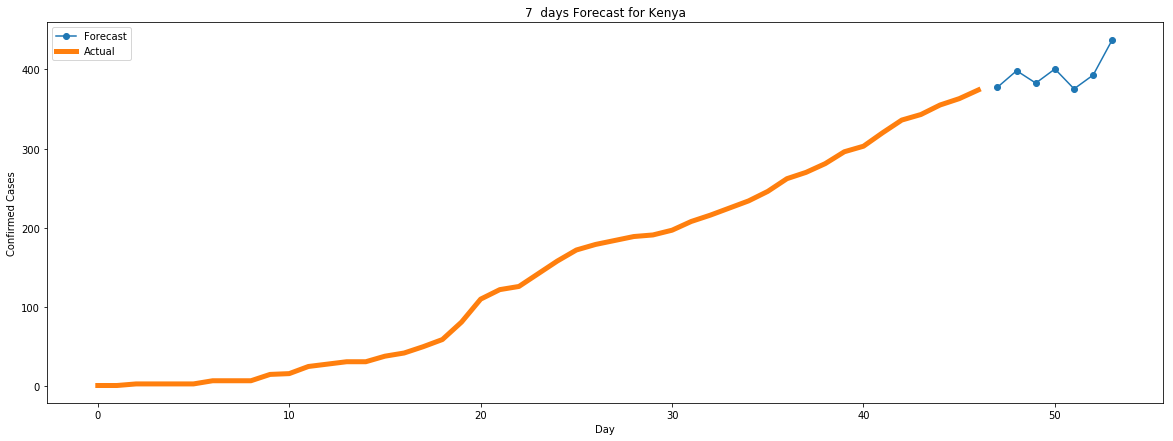

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=349.833, BIC=379.091, Time=0.693 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=352.766, BIC=376.539, Time=0.301 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=348.517, BIC=375.946, Time=0.589 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=353.002, BIC=380.431, Time=0.601 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=350.895, BIC=372.838, Time=0.210 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=354.807, BIC=380.408, Time=0.267 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=348.648, BIC=377.906, Time=0.930 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=358.830, BIC=388.088, Time=0.690 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=352.693, BIC=380.123, Time=0.593 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 1, 7) (constant=True); AIC=353.015, BIC=384.102, Time=1.078 seco

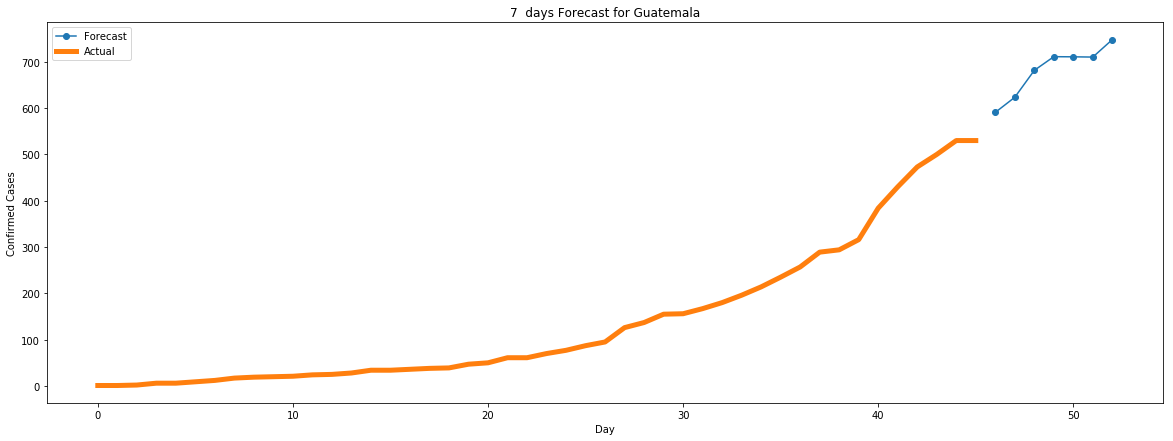

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=455.849, BIC=468.708, Time=0.291 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=699.087, BIC=705.517, Time=0.037 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=462.601, BIC=473.317, Time=0.169 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=618.306, BIC=629.022, Time=0.277 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=701.320, BIC=705.606, Time=0.024 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=454.436, BIC=465.152, Time=0.104 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=455.597, BIC=468.456, Time=0.228 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=458.433, BIC=473.435, Time=0.377 seconds
Near non-invertible roots for 

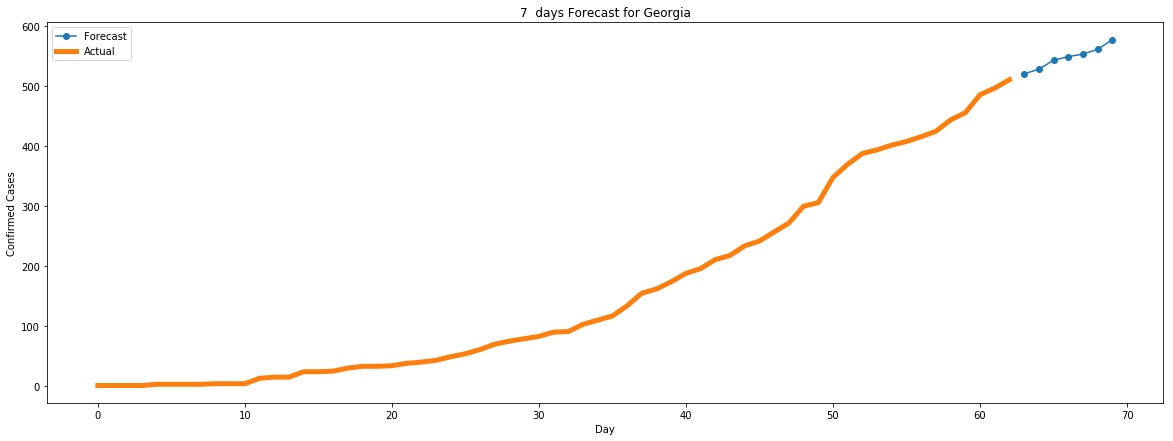

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=408.389, BIC=427.503, Time=0.494 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=406.212, BIC=420.113, Time=0.144 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=408.510, BIC=425.887, Time=0.412 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=408.426, BIC=425.802, Time=0.443 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=407.496, BIC=419.659, Time=0.123 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=407.096, BIC=422.735, Time=0.384 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=406.146, BIC=421.785, Time=0.345 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=408.437, BIC=425.813, Time=0.450 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 2, 7) (constant=True); AIC=408.644, BIC=426.020, Time=0.550 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 2, 7) (constant=True); AIC=410.683, BIC=429.797, Time=0.652 seco

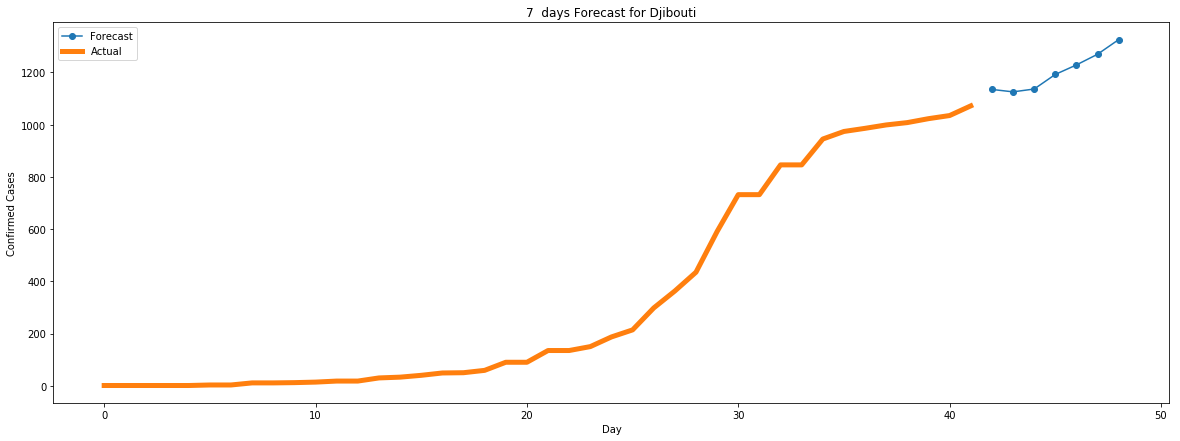

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=433.846, BIC=445.073, Time=0.244 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=468.396, BIC=474.010, Time=0.028 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=432.483, BIC=441.839, Time=0.175 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=444.420, BIC=453.776, Time=0.209 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=466.409, BIC=470.151, Time=0.058 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=430.526, BIC=438.010, Time=0.057 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=432.465, BIC=441.821, Time=0.183 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=434.312, BIC=445.539, Time=0.299 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=431.568, BIC=440.924, Time=0.113 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=431.982, BIC=441.338, Time=0.119 seco

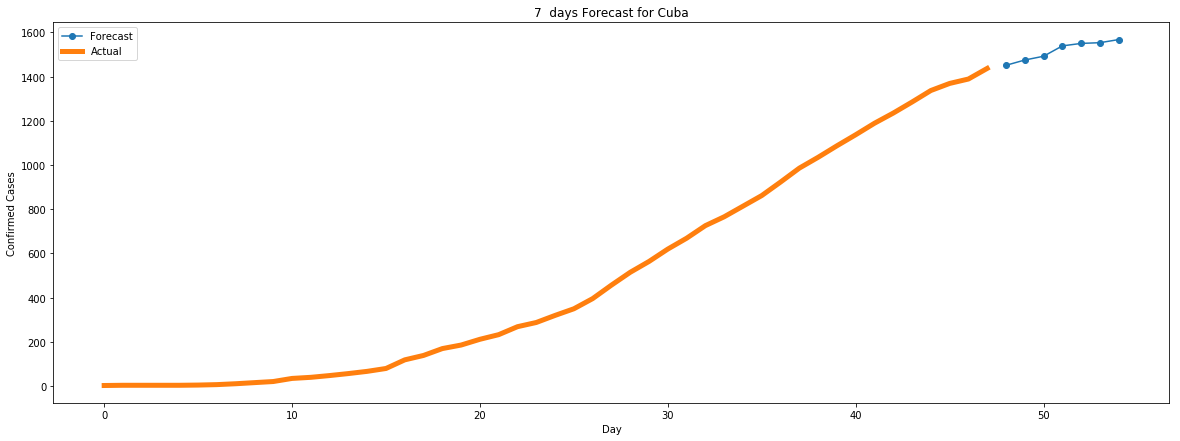

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=410.434, BIC=424.226, Time=0.342 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=519.659, BIC=527.540, Time=0.045 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=411.606, BIC=423.428, Time=0.234 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=474.042, BIC=485.864, Time=0.315 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=532.949, BIC=538.860, Time=0.055 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=413.622, BIC=425.444, Time=0.164 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=411.768, BIC=427.530, Time=0.414 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 2, 7) (constant=True); AIC=411.863, BIC=427.626, Time=0.516 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=411.912, BIC=425.704, Time=0.298 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 2, 7) (constant=True); AIC=414.037, BIC=431.770, Time=0.592 seco

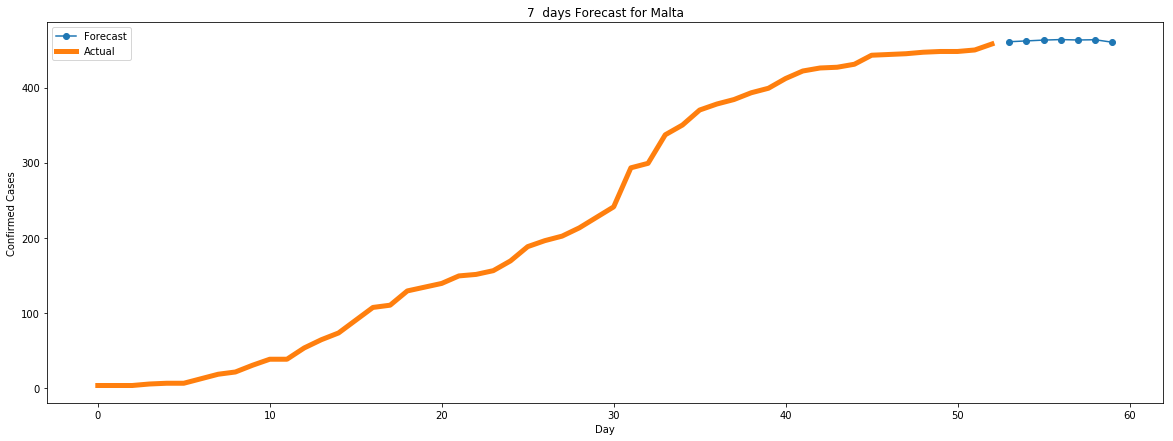

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=374.939, BIC=407.100, Time=0.750 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=374.650, BIC=401.135, Time=0.240 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=372.981, BIC=403.251, Time=0.669 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=375.268, BIC=405.537, Time=0.686 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=377.140, BIC=401.733, Time=0.290 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=374.509, BIC=402.886, Time=0.275 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=374.473, BIC=406.634, Time=1.042 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=375.590, BIC=407.751, Time=0.773 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=373.122, BIC=403.391, Time=0.669 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 1, 7) (constant=True); AIC=374.028, BIC=408.081, Time=1.128 seco

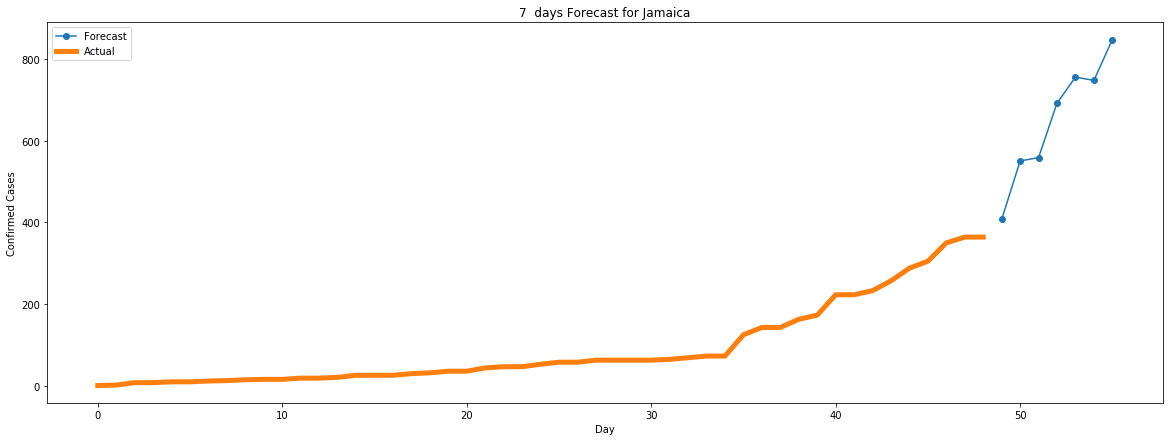

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=346.320, BIC=356.453, Time=0.333 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=444.856, BIC=449.923, Time=0.024 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=357.557, BIC=366.001, Time=0.150 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=396.920, BIC=405.364, Time=0.315 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=443.801, BIC=447.179, Time=0.025 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=344.767, BIC=353.212, Time=0.124 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=348.729, 

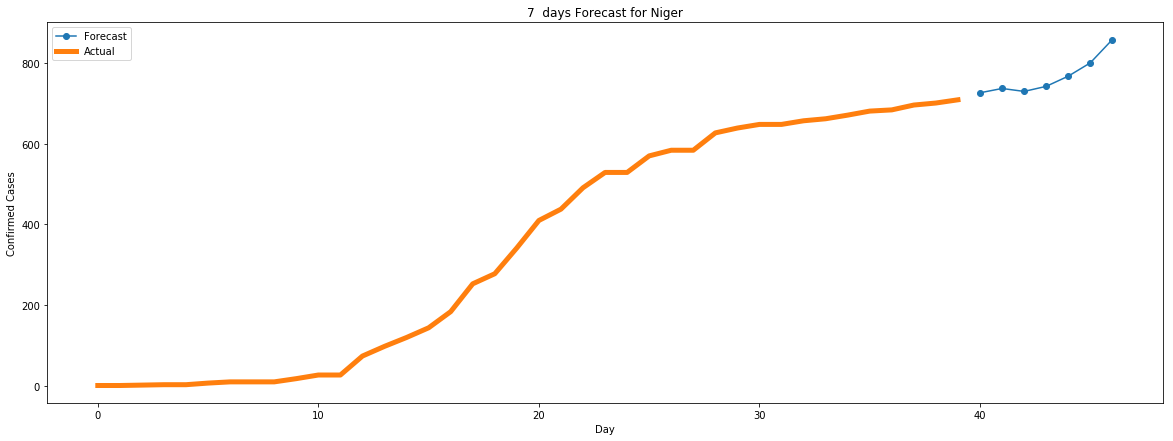

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=302.488, BIC=341.341, Time=0.951 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=302.900, BIC=336.203, Time=0.041 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=302.146, BIC=339.149, Time=0.820 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=303.587, BIC=340.590, Time=0.899 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=300.905, BIC=332.357, Time=0.387 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=300.527, BIC=335.680, Time=0.748 seconds
Fit ARIMA: (0, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=301.271, BIC=338.274, Time=1.206 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=303.206, BIC=340.209, Time=0.872 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=301.672, BIC=336.824, Time=1.058 seconds
Fit ARIMA: (0, 0, 0)x(2, 0, 1, 7) (constant=True); AIC=303.813, BIC=342.666, Time=1.686 seco

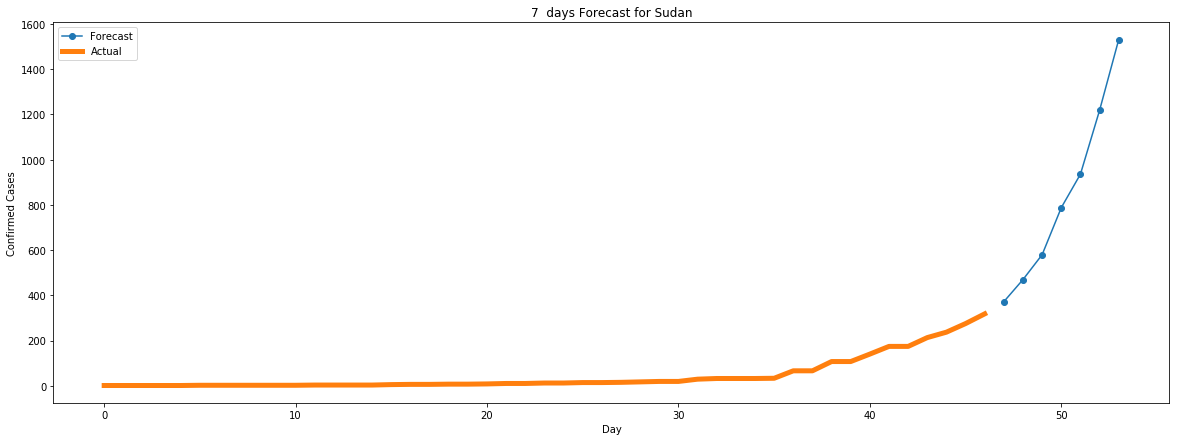

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=337.158, BIC=351.059, Time=0.343 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=446.784, BIC=455.472, Time=0.089 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=337.617, BIC=349.780, Time=0.206 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=412.310, BIC=424.474, Time=0.337 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=451.931, BIC=458.881, Time=0.038 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=335.160, BIC=347.324, Time=0.171 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=337.156, BIC=351.057, Time=0.371 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=336.148, BIC=351.787, Time=0.460 seconds
Near non-invertible roots for order (1, 0, 1)(1, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: (0, 0, 1)x(0, 0, 0,

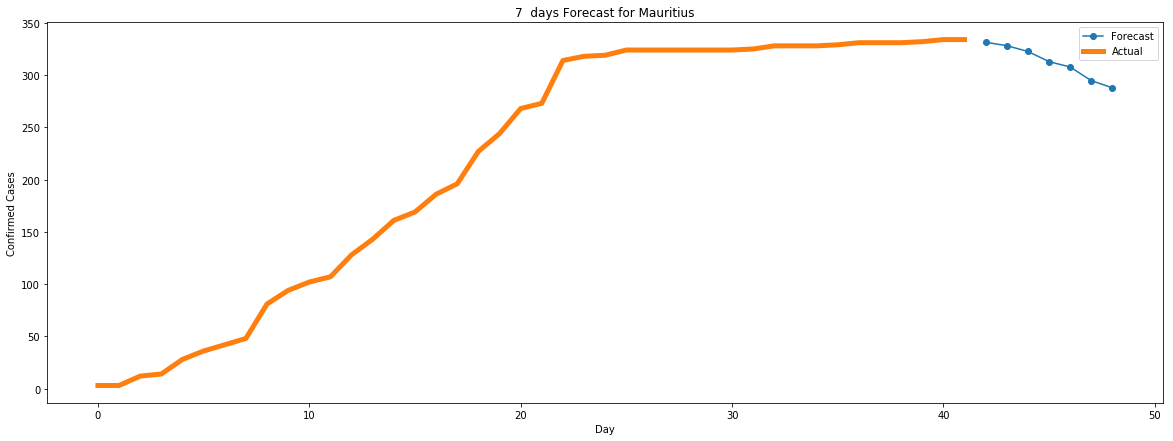

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=344.293, BIC=368.887, Time=0.593 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=350.745, BIC=369.663, Time=0.181 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=342.716, BIC=365.417, Time=0.514 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=343.534, BIC=366.236, Time=0.542 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=350.622, BIC=367.648, Time=0.164 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=340.759, BIC=361.569, Time=0.223 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=342.621, BIC=365.323, Time=0.459 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=344.866, BIC=369.460, Time=0.641 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=342.552, BIC=365.253, Time=0.323 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=342.869, BIC=365.571, Time=0.334 seco

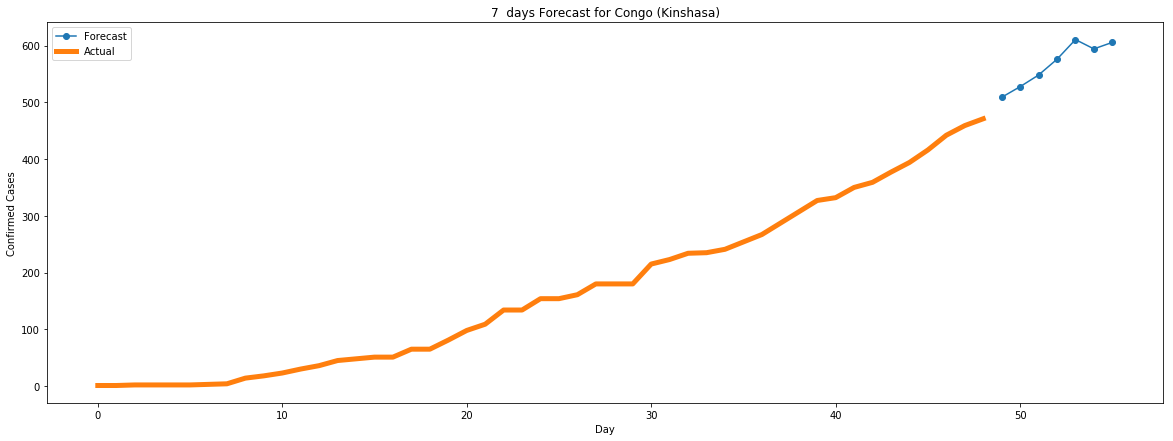

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=342.563, BIC=368.628, Time=0.648 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=336.122, BIC=356.974, Time=0.228 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=342.182, BIC=366.509, Time=0.670 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=342.355, BIC=366.682, Time=0.690 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=336.911, BIC=356.026, Time=0.248 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=338.771, BIC=361.361, Time=0.534 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=340.305, BIC=362.894, Time=0.504 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=342.237, BIC=366.564, Time=0.656 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=340.291, BIC=362.881, Time=0.086 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=340.107, BIC=362.697, Time=0.342 seco

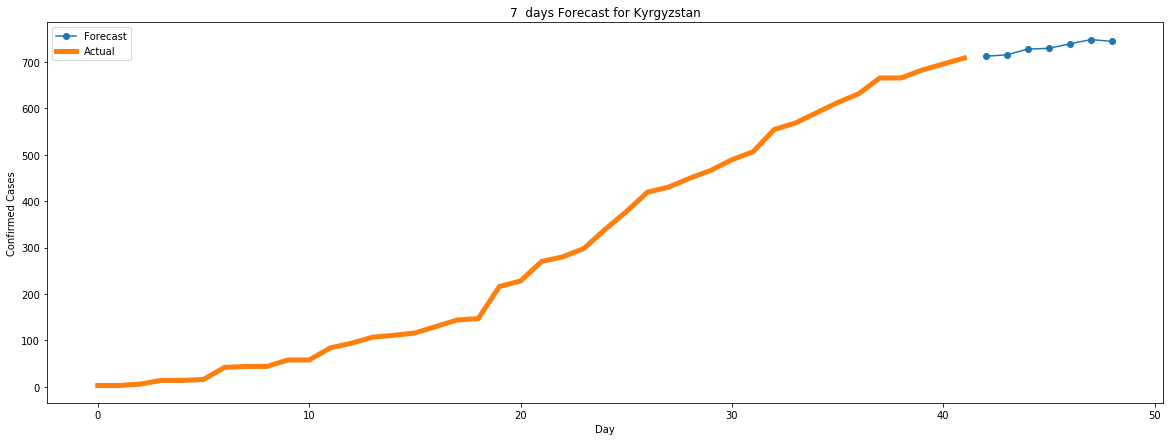

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=363.567, BIC=385.511, Time=0.543 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=423.116, BIC=439.574, Time=0.172 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=361.884, BIC=381.999, Time=0.501 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=421.265, BIC=441.380, Time=0.514 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=446.648, BIC=461.277, Time=0.176 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=360.163, BIC=378.450, Time=0.217 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=361.571, BIC=381.686, Time=0.469 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=364.233, BIC=386.176, Time=0.553 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0,

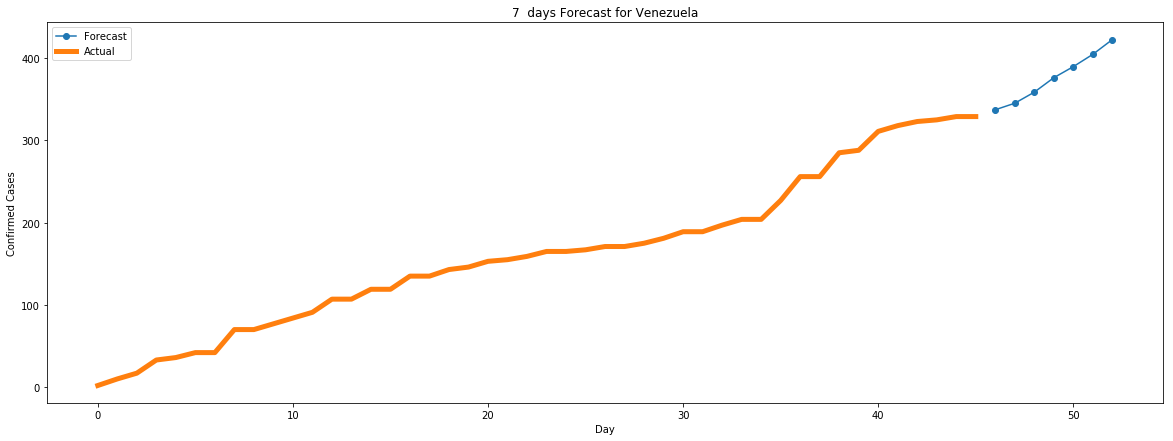

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=459.288, BIC=474.422, Time=0.423 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=471.883, BIC=481.342, Time=0.076 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=457.271, BIC=470.514, Time=0.329 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=460.308, BIC=473.551, Time=0.321 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=473.082, BIC=480.649, Time=0.049 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=454.775, BIC=466.126, Time=0.142 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=457.120, BIC=470.363, Time=0.316 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=458.270, BIC=473.405, Time=0.421 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=457.353, BIC=470.596, Time=0.221 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=457.365, BIC=470.608, Time=0.211 seco

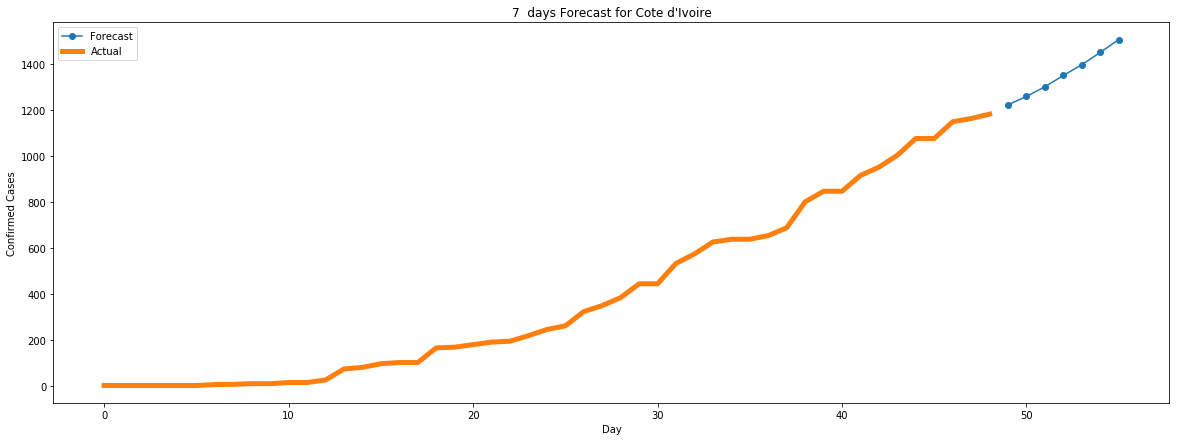

In [13]:
for target_name in list(best_pair.keys()):
    data = all_data[[target_name]]
    Y = data[data[target_name]> 0].reset_index(drop=True).iloc[:,0].values
    X = pd.DataFrame(np.vstack(best_pair[target_name]).T)
    X_train = X.iloc[:len(Y),:].values
    model =  auto_arima(Y,exogenous=X_train,
                        start_p=1, start_q=1,max_p=3, max_q=3, m=7 ,start_P=0, seasonal=True,
                        d=0, D=0, trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
    forecast = model.predict(7,exogenous =X.iloc[len(Y):,:].values)
    y_forec, conf_int  = model.predict(7,exogenous =X.iloc[len(Y):,:].values,return_conf_int=True,alpha=0.05)
    Actual_df =pd.DataFrame(Y,columns=['Actuals'])
    for i in ['forecast','Ci_low','Ci_high']:
        Actual_df[i] = np.nan
    forecast_df= pd.DataFrame(conf_int,columns = ['Ci_low','Ci_high'])
    forecast_df['forecast'] =y_forec
    forecast_df = Actual_df.append(forecast_df).reset_index(drop=True)
    plt.figure(figsize=(20,7))
    plt.plot(forecast_df.index,forecast_df.forecast,'-o')
    plt.plot(forecast_df.index,forecast_df.Actuals,linewidth=5)
    plt.legend(['Forecast','Actual'])
    plt.title('7  days Forecast for {}'.format(target_name))
    plt.xlabel('Day')
    plt.ylabel('Confirmed Cases')
    plt.show()